In [1]:
import pandas as pd
import os
import pydot
import logging
import glob
import re
from string import printable
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [2]:
from keras.models import  Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Lambda,Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, ELU, LSTM, GRU, Embedding, Convolution2D, MaxPooling2D, BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras import optimizers

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.layers import Bidirectional, SimpleRNN
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [31]:
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import logging
import numpy as np
import dill as dpickle
from annoy import AnnoyIndex
from tqdm import tqdm, tqdm_notebook
from random import random
from nltk.translate.bleu_score import corpus_bleu


def load_text_processor(fname='title_pp.dpkl'):
    """
    Load preprocessors from disk.
    Parameters
    ----------
    fname: str
        file name of ktext.proccessor object
    Returns
    -------
    num_tokens : int
        size of vocabulary loaded into ktext.processor
    pp : ktext.processor
        the processor you are trying to load
    Typical Usage:
    -------------
    num_decoder_tokens, title_pp = load_text_processor(fname='title_pp.dpkl')
    num_encoder_tokens, body_pp = load_text_processor(fname='body_pp.dpkl')
    """
    # Load files from disk
    with open(fname, 'rb') as f:
        pp = dpickle.load(f)

    num_tokens = max(pp.id2token.keys()) + 1
    print(f'Size of vocabulary for {fname}: {num_tokens:,}')
    return num_tokens, pp


def load_decoder_inputs(decoder_np_vecs='train_title_vecs.npy'):
    """
    Load decoder inputs.
    Parameters
    ----------
    decoder_np_vecs : str
        filename of serialized numpy.array of decoder input (issue title)
    Returns
    -------
    decoder_input_data : numpy.array
        The data fed to the decoder as input during training for teacher forcing.
        This is the same as `decoder_np_vecs` except the last position.
    decoder_target_data : numpy.array
        The data that the decoder data is trained to generate (issue title).
        Calculated by sliding `decoder_np_vecs` one position forward.
    """
    vectorized_title = np.load(decoder_np_vecs)
    # For Decoder Input, you don't need the last word as that is only for prediction
    # when we are training using Teacher Forcing.
    decoder_input_data = vectorized_title[:, :-1]

    # Decoder Target Data Is Ahead By 1 Time Step From Decoder Input Data (Teacher Forcing)
    decoder_target_data = vectorized_title[:, 1:]

    print(f'Shape of decoder input: {decoder_input_data.shape}')
    print(f'Shape of decoder target: {decoder_target_data.shape}')
    return decoder_input_data, decoder_target_data


def load_encoder_inputs(encoder_np_vecs='train_body_vecs.npy'):
    """
    Load variables & data that are inputs to encoder.
    Parameters
    ----------
    encoder_np_vecs : str
        filename of serialized numpy.array of encoder input (issue title)
    Returns
    -------
    encoder_input_data : numpy.array
        The issue body
    doc_length : int
        The standard document length of the input for the encoder after padding
        the shape of this array will be (num_examples, doc_length)
    """
    vectorized_body = np.load(encoder_np_vecs)
    # Encoder input is simply the body of the issue text
    encoder_input_data = vectorized_body
    doc_length = encoder_input_data.shape[1]
    print(f'Shape of encoder input: {encoder_input_data.shape}')
    return encoder_input_data, doc_length


def viz_model_architecture(model):
    """Visualize model architecture in Jupyter notebook."""
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))


def free_gpu_mem():
    """Attempt to free gpu memory."""
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))


def test_gpu():
    """Run a toy computation task in tensorflow to test GPU."""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    hello = tf.constant('Hello, TensorFlow!')
    print(session.run(hello))


def plot_model_training_history(history_object):
    """Plots model train vs. validation loss."""
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def extract_encoder_model(model):
    """
    Extract the encoder from the original Sequence to Sequence Model.
    Returns a keras model object that has one input (body of issue) and one
    output (encoding of issue, which is the last hidden state).
    Input:
    -----
    model: keras model object
    Returns:
    -----
    keras model object
    """
    encoder_model = model.get_layer('Encoder-Model')
    return encoder_model


def extract_decoder_model(model):
    """
    Extract the decoder from the original model.
    Inputs:
    ------
    model: keras model object
    Returns:
    -------
    A Keras model object with the following inputs and outputs:
    Inputs of Keras Model That Is Returned:
    1: the embedding index for the last predicted word or the <Start> indicator
    2: the last hidden state, or in the case of the first word the hidden state from the encoder
    Outputs of Keras Model That Is Returned:
    1.  Prediction (class probabilities) for the next word
    2.  The hidden state of the decoder, to be fed back into the decoder at the next time step
    Implementation Notes:
    ----------------------
    Must extract relevant layers and reconstruct part of the computation graph
    to allow for different inputs as we are not going to use teacher forcing at
    inference time.
    """
    # the latent dimension is the same throughout the architecture so we are going to
    # cheat and grab the latent dimension of the embedding because that is the same as what is
    # output from the decoder
    latent_dim = model.get_layer('Decoder-Word-Embedding').output_shape[-1]

    # Reconstruct the input into the decoder
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)

    # Instead of setting the intial state from the encoder and forgetting about it, during inference
    # we are not doing teacher forcing, so we will have to have a feedback loop from predictions back into
    # the GRU, thus we define this input layer for the state so we can add this capability
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')

    # we need to reuse the weights that is why we are getting this
    # If you inspect the decoder GRU that we created for training, it will take as input
    # 2 tensors -> (1) is the embedding layer output for the teacher forcing
    #                  (which will now be the last step's prediction, and will be _start_ on the first time step)
    #              (2) is the state, which we will initialize with the encoder on the first time step, but then
    #                   grab the state after the first prediction and feed that back in again.
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])

    # Reconstruct dense layers
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input],
                          [dense_out, gru_state_out])
    return decoder_model


class Seq2Seq_Inference(object):
    def __init__(self,
                 encoder_preprocessor,
                 decoder_preprocessor,
                 seq2seq_model):

        self.pp_body = encoder_preprocessor
        self.pp_title = decoder_preprocessor
        self.seq2seq_model = seq2seq_model
        self.encoder_model = extract_encoder_model(seq2seq_model)
        self.decoder_model = extract_decoder_model(seq2seq_model)
        self.default_max_len_title = self.pp_title.padding_maxlen
        self.nn = None
        self.rec_df = None

    def generate_issue_title(self,
                             raw_input_text,
                             max_len_title=None):
        """
        Use the seq2seq model to generate a title given the body of an issue.
        Inputs
        ------
        raw_input: str
            The body of the issue text as an input string
        max_len_title: int (optional)
            The maximum length of the title the model will generate
        """
        if max_len_title is None:
            max_len_title = self.default_max_len_title
        # get the encoder's features for the decoder
        raw_tokenized = self.pp_body.transform([raw_input_text])
        body_encoding = self.encoder_model.predict(raw_tokenized)
        # we want to save the encoder's embedding before its updated by decoder
        #   because we can use that as an embedding for other tasks.
        original_body_encoding = body_encoding
        state_value = np.array(self.pp_title.token2id['_start_']).reshape(1, 1)

        decoded_sentence = []
        stop_condition = False
        while not stop_condition:
            preds, st = self.decoder_model.predict([state_value, body_encoding])

            # We are going to ignore indices 0 (padding) and indices 1 (unknown)
            # Argmax will return the integer index corresponding to the
            #  prediction + 2 b/c we chopped off first two
            pred_idx = np.argmax(preds[:, :, 2:]) + 2

            # retrieve word from index prediction
            pred_word_str = self.pp_title.id2token[pred_idx]

            if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
                stop_condition = True
                break
            decoded_sentence.append(pred_word_str)

            # update the decoder for the next word
            body_encoding = st
            state_value = np.array(pred_idx).reshape(1, 1)

        return original_body_encoding, ' '.join(decoded_sentence)


    def print_example(self,
                      i,
                      body_text,
                      title_text,
                      threshold):
        """
        Prints an example of the model's prediction for manual inspection.
        """
        if i:
            print('\n\n==============================================')
            print(f'============== Example # {i} =================\n')

        print(f"Issue Body:\n {body_text} \n")

        if title_text:
            print(f"Original Title:\n {title_text}")

        emb, gen_title = self.generate_issue_title(body_text)
        print(f"\n****** Machine Generated Title (Prediction) ******:\n {gen_title}")

        if self.nn:
            # return neighbors and distances
            n, d = self.nn.get_nns_by_vector(emb.flatten(), n=4,
                                             include_distances=True)
            neighbors = n[1:]
            dist = d[1:]

            if min(dist) <= threshold:
                cols = ['title', 'body']
                dfcopy = self.rec_df.iloc[neighbors][cols].copy(deep=True)
                dfcopy['dist'] = dist
                similar_issues_df = dfcopy.query(f'dist <= {threshold}')

                print("\n**** Similar Issues (using encoder embedding) ****:\n")
                display(similar_issues_df)
                
        return gen_title


    def demo_model_predictions(self,
                               n,
                               issue_df,
                               threshold=1):
        """
        Pick n random Issues and display predictions.
        Input:
        ------
        n : int
            Number of issues to display from issue_df
        issue_df : pandas DataFrame
            DataFrame that contains two columns: `body` and `issue_title`.
        threshold : float
            distance threshold for recommendation of similar issues.
        Returns:
        --------
        None
            Prints the original issue body and the model's prediction.
        """
        # Extract body and title from DF
        body_text = issue_df.body.tolist()
        title_text = issue_df.title.tolist()

        col_names =  ['body', 'actual_title', 'generated_title']
        resultDF  = pd.DataFrame(columns = col_names)
        
        #demo_list = np.random.randint(low=1, high=len(body_text), size=n)
        demo_list = list(range(1,n+1))
        for i in demo_list:
          
            tmp_title = self.print_example(i,
                               body_text=body_text[i],
                               title_text=title_text[i],
                               threshold=threshold)
            tmpDF = pd.DataFrame({"body": [body_text[i]], 
                                  "actual_title": [title_text[i]], 
                                  "generated_title": [tmp_title]})
            resultDF = pd.concat([resultDF, tmpDF], ignore_index=True)

        resultDF.to_csv('resultDF.csv', encoding='latin-1')

            

    def prepare_recommender(self, vectorized_array, original_df):
        """
        Use the annoy library to build recommender
        Parameters
        ----------
        vectorized_array : List[List[int]]
            This is the list of list of integers that represents your corpus
            that is fed into the seq2seq model for training.
        original_df : pandas.DataFrame
            This is the original dataframe that has the columns
            ['issue_url', 'issue_title', 'body']
        Returns
        -------
        annoy.AnnoyIndex  object (see https://github.com/spotify/annoy)
        """
        self.rec_df = original_df
        emb = self.encoder_model.predict(x=vectorized_array,
                                         batch_size=vectorized_array.shape[0]//200)

        f = emb.shape[1]
        self.nn = AnnoyIndex(f)
        logging.warning('Adding embeddings')
        for i in tqdm(range(len(emb))):
            self.nn.add_item(i, emb[i])
        logging.warning('Building trees for similarity lookup.')
        self.nn.build(50)
        return self.nn

    def set_recsys_data(self, original_df):
        self.rec_df = original_df

    def set_recsys_annoyobj(self, annoyobj):
        self.nn = annoyobj

    def evaluate_model(self, holdout_bodies, holdout_titles):
        """
        Method for calculating BLEU Score.
        Parameters
        ----------
        holdout_bodies : List[str]
            These are the issue bodies that we want to summarize
        holdout_titles : List[str]
            This is the ground truth we are trying to predict --> issue titles
        Returns
        -------
        bleu : float
            The BLEU Score
        """
        actual, predicted = list(), list()
        assert len(holdout_bodies) == len(holdout_titles)
        num_examples = len(holdout_bodies)

        logging.warning('Generating predictions.')
        # step over the whole set TODO: parallelize this
        for i in tqdm_notebook(range(num_examples)):
            _, yhat = self.generate_issue_title(holdout_bodies[i])

            actual.append(self.pp_title.process_text([holdout_titles[i]])[0])
            predicted.append(self.pp_title.process_text([yhat])[0])
        # calculate BLEU score
        logging.warning('Calculating BLEU.')
        
        #must be careful with nltk api for corpus_bleu!, 
        # expects List[List[List[str]]] for ground truth, using List[List[str]] will give you
        # erroneous results.
        bleu = corpus_bleu([[a] for a in actual], predicted)
        return bleu

In [16]:
news = pd.read_csv("articles2.csv", encoding='utf-8')
#news.dropna(inplace=True)
#news.reset_index(drop=True, inplace=True)
print(list(news))
print(news.shape)


['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']
(49999, 10)


In [17]:
news = news.filter(items=['title', 'content'])

In [18]:
print(list(news))

['title', 'content']


In [19]:
news = news.rename(index=str, columns={"title": "title", "content": "body"})
print(list(news))

['title', 'body']


In [20]:
news = news.head(5000)
print(news.shape)

(5000, 2)


In [11]:
print(news["title"][0])
print(news["body"][0])

Patriots Day Is Best When It Digs Past the Heroism
Patriots Day, Peter Berg’s new thriller that recreates the 2013 Boston Marathon bombing and the ensuing manhunt that followed it, is a surprisingly oblique, morally ambiguous movie from a typically straightforward filmmaker. Patriots Day takes an unexpectedly cynical view of the chaos, rash   and bureaucratic infighting that followed the bombing —  the question is whether that was Berg’s intended message. For its grim   running time, the movie celebrates the men on the ground who helped bring the bombers to justice, but it’s the glimpses of something more complicated than jingoism that really linger. The scene that best illustrates this dichotomy comes late in Patriots Day. As the search for one of the bombers, Dzhokhar Tsarnaev, intensifies, his brother’s wife Katherine (Melissa Benoist) is brought in for interrogation on her connections to the case. As she asks for a lawyer, protesting that she “has rights,” her steely interviewer (K

In [21]:
tmp_traindf, testdf = train_test_split(news, test_size=.10)

traindf = pd.concat([tmp_traindf, tmp_traindf, tmp_traindf, tmp_traindf], 
                      ignore_index=True)

#print out stats about shape of data
print(traindf.shape)
print(testdf.shape)

(18000, 2)
(500, 2)


In [22]:
train_body_raw = traindf['body'].tolist()
train_title_raw = traindf['title'].tolist()
#preview output of first element
train_body_raw[0]

'   I want to receive updates from partners and sponsors. CHICAGO  —   Earlier this month in Chicago’s Wicker Park —  once a warren of   bars and shops that has given way to boutiques and juice bars —  the apotheosis of ‘90s   worship opened its doors. Saved By the Max, a Saved By the     diner that takes its name from the show’s fictitious   hangout, is a Bayside High yearbook come to life, an eerily faithful blitzkrieg of red vinyl, neon and pastel decor, cast photos, and blaring theme music. (Licensing fees are, of course, paid to NBC.) The entranceway is flanked by a row of instantly familiar red lockers beside a wall on which memorable quotes and visual homages (caffeine pills, Zack Morris’s brick cellphone, and Becky [RIP]) are haphazardly painted. If there’s one thing we know about the target audience for a ‘    those tirelessly analyzed Millennials, it’s that they prefer to spend what money they have on experiences, like travel, and quality items, especially food. And so, while

In [23]:
print(train_title_raw[0])

The New Nostalgia


In [24]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

In [25]:
%%time
# Clean, tokenize, and apply padding / truncating such that each document length = 70
# also, retain only the top 8,000 words in the vocabulary and set the remaining words
# to 1 which will become common index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

Wall time: 4min 27s


In [26]:
print(train_body_raw[0])
print(train_body_vecs[0])

   I want to receive updates from partners and sponsors. CHICAGO  —   Earlier this month in Chicago’s Wicker Park —  once a warren of   bars and shops that has given way to boutiques and juice bars —  the apotheosis of ‘90s   worship opened its doors. Saved By the Max, a Saved By the     diner that takes its name from the show’s fictitious   hangout, is a Bayside High yearbook come to life, an eerily faithful blitzkrieg of red vinyl, neon and pastel decor, cast photos, and blaring theme music. (Licensing fees are, of course, paid to NBC.) The entranceway is flanked by a row of instantly familiar red lockers beside a wall on which memorable quotes and visual homages (caffeine pills, Zack Morris’s brick cellphone, and Becky [RIP]) are haphazardly painted. If there’s one thing we know about the target audience for a ‘    those tirelessly analyzed Millennials, it’s that they prefer to spend what money they have on experiences, like travel, and quality items, especially food. And so, while 

In [27]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=17, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

In [28]:
print(train_title_raw[0])
print(train_title_vecs[0])

The New Nostalgia
[   2    4   29 1369    3    0    0    0    0    0    0    0    0    0
    0    0    0]


In [29]:
#### Serialize all of this to disk for later use

import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

# Define Model Architecture

### Load the data from disk into variables

In [32]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (18000, 70)
Shape of decoder input: (18000, 16)
Shape of decoder target: (18000, 16)


In [33]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 8,002
Size of vocabulary for title_pp.dpkl: 4,502


### Define the model architecture

In [34]:
#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 600

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')


In [37]:
seq2seq_Model.summary()
#viz_model_architecture(seq2seq_Model) #Did not work

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 600)    2701200     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 600)    2400        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

### Train the model

In [38]:
script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                  save_best_only=True)

batch_size = 1200
epochs = 10
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 15840 samples, validate on 2160 samples
Epoch 1/10
15840/15840 [==============================] - ETA: 8:23 - loss: 8.478 - ETA: 7:04 - loss: 7.272 - ETA: 6:14 - loss: 6.550 - ETA: 5:31 - loss: 6.062 - ETA: 4:47 - loss: 5.701 - ETA: 4:09 - loss: 5.407 - ETA: 3:32 - loss: 5.159 - ETA: 2:57 - loss: 4.949 - ETA: 2:22 - loss: 4.773 - ETA: 1:47 - loss: 4.620 - ETA: 1:13 - loss: 4.484 - ETA: 40s - loss: 4.368 - ETA: 6s - loss: 4.2628 - 457s 29ms/step - loss: 4.2429 - val_loss: 2.7486


C:\Users\ohmgs\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 600) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
15840/15840 [==============================] - ETA: 6:32 - loss: 2.844 - ETA: 6:17 - loss: 2.810 - ETA: 5:39 - loss: 2.786 - ETA: 5:00 - loss: 2.756 - ETA: 4:25 - loss: 2.723 - ETA: 3:53 - loss: 2.694 - ETA: 3:21 - loss: 2.665 - ETA: 2:49 - loss: 2.634 - ETA: 2:16 - loss: 2.606 - ETA: 1:43 - loss: 2.583 - ETA: 1:11 - loss: 2.559 - ETA: 39s - loss: 2.532 - ETA: 6s - loss: 2.5091 - 451s 28ms/step - loss: 2.5046 - val_loss: 2.4640
Epoch 3/10
15840/15840 [==============================] - ETA: 6:41 - loss: 1.990 - ETA: 6:16 - loss: 1.975 - ETA: 5:41 - loss: 1.996 - ETA: 5:06 - loss: 2.018 - ETA: 4:34 - loss: 1.991 - ETA: 4:00 - loss: 1.958 - ETA: 3:28 - loss: 1.927 - ETA: 2:54 - loss: 1.903 - ETA: 2:20 - loss: 1.877 - ETA: 1:47 - loss: 1.848 - ETA: 1:13 - loss: 1.821 - ETA: 39s - loss: 1.791 - ETA: 6s - loss: 1.7669 - 457s 29ms/step - loss: 1.7632 - val_loss: 1.8642
Epoch 4/10
15840/15840 [==============================] - ETA: 6:40 - loss: 1.263 - ETA: 6:15 - loss: 1.248 - ETA:

In [39]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial.h5')

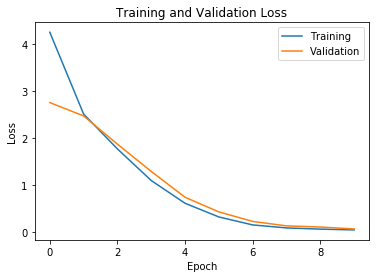

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# See Results On Holdout Set

In [41]:
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [42]:
# this method displays the predictions on random rows of the holdout set
seq2seq_inf.demo_model_predictions(n=len(testdf), issue_df=testdf)



============== Example # 1 =================

Issue Body:
    I want to receive updates from partners and sponsors. South America was once a land of giants. Its plains and forests were home to   ground sloths,   armadillos the size of a car, and huge creatures that resembled humpless camels. Hunting them were a large subspecies of jaguar,   cats, and the gigantic   bear, several times heavier than a grizzly. All of these giants —  the aptly named megafauna —  are now gone. Why? In the 1930s, Junius Bird, an American archaeologist in the mold of Indiana Jones, found a clue in an innocuous rock shelter near the southernmost tip of Chile. Within it, he uncovered ancient knives, spear points, arrowheads and other stone tools, together with the bones of large animals like horses and lumbering ground sloths. Those discoveries, in what is now known as Fell’s Cave, were among the first to suggest that prehistoric humans hunted the megafaunal menagerie to extinction. Paleontologists would soo


Original Title:
 America by Air: Descending Into a Dust Storm

****** Machine Generated Title (Prediction) ******:
 america by air calm before the storm


============== Example # 3 =================

Issue Body:
    I want to receive updates from partners and sponsors. Iceland may be beautiful, but it s dangerously close to full. This is the message currently filtering out from the North Atlantic island as it struggles to absorb unprecedented numbers of visitors. Last year, the nation hosted 1. 26 million tourists, a staggering number for a chilly island whose population barely scrapes past 330, 000 citizens. Those numbers are powered partly by a  Game of Thrones Effect ? that has seen fans of the TV series flock to its shooting locations. The 2010 eruption of the EyjafjallajÃ¶kull volcano, which has since become a tourist attraction, also helped to push up its profile as a vacation spot ”perversely so, given that the eruption initially led to 107, 000 flights across Europe being can


Issue Body:
 An ongoing reader discussion led by James Fallows regarding Donald Trump’s rise through the primaries and his potential role as president. (For a related series, see “Trump Time Capsule. ”) To sound off in a substantive way, please send us a note: hello@theatlantic. com. Many more of your smart emails are coming in over Trump and what he means for the election, the GOP, and the country. The first one comes from reader Reid, who describes a familiar outlook that is more relevant than ever, as Trump’s campaign continues to implode while taking the Republicans down with him. (Sarah Palin’s “going rogue” in 2008 seems quaint by comparison.) Here’s Reid: The fact that the GOP isn’t pushing back on Trump’s attack on the election is appalling and reprehensible to me. McConnell’s silence stands out in particular. The GOP is dead, and the GOP is certainly dead to me (and that is not a good thing for our country). I once had a theory: People like Christie, Pence, McConnell, and Rya


Original Title:
 The Trap the GOP Should Have Seen Coming

****** Machine Generated Title (Prediction) ******:
 the cultural destruction of became politician


============== Example # 6 =================

Issue Body:
 The Roots of the New Urban Crisis, In Cities of Tomorrow’s grim future, there is a technologically advanced infrastructure that’s owned by an elite cadre known as ControlNet. The mayor can do things to limit their power, but only at the risk of stifling the city’s economic growth. Too little growth, and the city devolves into dystopian squalor too much, and it becomes so unequal that its citizens can hardly afford to live in it. To succeed, players must find and navigate the precarious path between those two equally unpalatable urban alternatives. Sound familiar? The futuristic city might be an   fiction, but the basic dilemma that the game describes is playing out in real cities today. The most important and innovative industries and the most talented, most ambitious, 


Original Title:
 Why America’s Richest Cities Keep Getting Richer

****** Machine Generated Title (Prediction) ******:
 the end of the world s largest protest


============== Example # 7 =================

Issue Body:
 , I want to receive updates from partners and sponsors. When we take a test, we have some idea of how well we re going to do. When we start a task, we can predict how long it ll take us to finish it. When we field a question, we can judge whether we need to consult the oracle of Google. We can do all of this because of a skill called metacognition ”the ability to reflect upon our own minds, to monitor their degree of certainty, to have knowledge about our knowledge. Now, a new study from Louise Goupil, Margaux   and Sid Kouider at Paris Sciences et Lettres Research University suggests that we have this ability from a very early age. Even    infants have some sense of how well they remember the location of a hidden toy, and they ll ask for help if they re uncertain. Tha


Original Title:
 What Conservatives Get Wrong About Trump’s Immigration Order

****** Machine Generated Title (Prediction) ******:
 obama is not the economy is terrible no good very fake news


============== Example # 9 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, The cult television series Buffy the Vampire Slayer is now indisputably one of the most widely analyzed texts in contemporary popular culture. The end of the series in 2003 didn’t herald the passing of a fleeting academic fancy, as many must have expected, but instead ushered in an unprecedented number of monographs, edited collections, book chapters, journal articles, and even university courses that grapple with the Buffy phenomenon one way or another. The Rise of Buffy Studies, Gender analysis has been central to popular and academic critiques of Buffy from the seri


Original Title:
 Buffy Summers: Third-Wave Feminist Icon

****** Machine Generated Title (Prediction) ******:
 the atlantic politics policy daily before and the nafta


============== Example # 10 =================

Issue Body:
 , I want to receive updates from partners and sponsors. It’s 2016, so what’s Kanye West going to do now? Kanye asked himself the same sort of question on 2011’s “Monster,” and helpfully provided a reply: Whatever I wanna do! Gosh, it’s cool now! Know I’m gonna do: Ah, it’s the new now! Which is a nice distillation of Kanye West’s musical attitude. He sets trends by following his whims, often while referencing bro comedies of the  . American Mozart, A year ago, he began a campaign to show the world just how little he cares about its expectations. The New Year in 2015 brought a tender ode to fatherhood recorded with Paul McCartney, later followed by a country song, an ambient mood piece, a remix from an experimental classical arranger, a lot of weird clothes, an


Original Title:
 When Factory Jobs Vanish, Men Become Less Desirable Partners

****** Machine Generated Title (Prediction) ******:
 what happens at the stanford rape case


============== Example # 12 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Sequels have been the lifeblood of the movie business for more than a decade. In 2011, the seven top films were all sequels, including Fast 5 and the final Harry Potter installment. Last year, the eight biggest opening weekends were all sequels, including Furious 7 and the latest Star Wars installment. But in the last six months, the sequel strategy seems to be deflating. Several   —  including Teenage Mutant Ninja Turtles: Out of the Shadows, Zoolander 2, The Huntsman: Winter’s War, Neighbors 2: Sorority Rising, The Divergent Series: Allegiant, Barbershop: The Next Cut, and Alice Through the Looking Glass —  have “disappointed or flopped outright,” The New York Times reported. Perhaps Hollywood’s fun


Original Title:
 Hollywood Has a Huge Millennial Problem

****** Machine Generated Title (Prediction) ******:
 the should only the world s largest family tree


============== Example # 13 =================

Issue Body:
 “Right now, widespread abuse in our immigration system is allowing American workers from all backgrounds to be replaced by workers brought in from other countries to fill the same job, for, sometimes, less pay,” Trump said, adding that for several decades American workers have faced an unlevel playing field when put in competition with foreign workers. His executive order represents a first step toward making the system less reliant on a lottery —  a mechanism he called “totally random” and “wrong,” since it didn’t simply award visas to the   workers. Depending on what Trump means by “widespread abuse” —  he did not elaborate —  he may find that   reforms actually have fairly broad political appeal. The program is supposed to provide American employers with workers th


Original Title:
 Is the Refugee Deal With Australia ‘Dumb’?

****** Machine Generated Title (Prediction) ******:
 after the election day


============== Example # 16 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here.     After weeks of buildup for today’s decisive primaries, the Associated Press announced that Hillary Clinton already had enough delegates to lock up the Democratic nomination for president —  hours before the polls in six states even opened. While Clinton was expected to get those delegates tonight, the AP’s surprise report prompted outcry from the Bernie Sanders campaign, which said the race is far from over. But as the delegate math stands now, Clinton is indeed the presu


Original Title:
 Not Walgreens, Not CVS: Life as an Independent Pharmacist

****** Machine Generated Title (Prediction) ******:
 one reason why are so much about money


============== Example # 18 =================

Issue Body:
 , I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     President Obama advised world leaders to be aware of terrorists trying to obtain nuclear weapons, saying a nuclear attack “would change our world. ” The Labor Department said that employers added 215, 00 jobs in March. Last month was also a good one for Bernie Sanders whose campaign raised $44 million, mostly from small donors. And classes were cancelled for more than 300, 000 public school students in Chicago as a result of a   walkout. Day Two at


Original Title:
 Careening to the Finish in New Hampshire

****** Machine Generated Title (Prediction) ******:
 how trump s new deportation plan


============== Example # 21 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Some of the wealthiest,   towns in the United States have the biggest   gaps between white students and their peers of color. That is one of the depressing facts emerging from a   new analysis of more than 200 million test scores of 40 million students from around the country between 2009 and 2013 by Stanford University researchers. Comparing   data across states is complicated because not all students take the same tests. The researchers created a database that allows these comparisons, providing what they say is the most   look at academic disparities across the country. They found wide disparities in prosperous university towns like Berkeley, California, Chapel Hill, North Carolina, and Evanston, Illinois —  cities often he


Original Title:
 In Wealthier School Districts, Students Are Farther Apart

****** Machine Generated Title (Prediction) ******:
 congress and an illusion


============== Example # 22 =================

Issue Body:
    I want to receive updates from partners and sponsors. The fourth week of protests against Kenya’s electoral commission turned violent Monday as demonstrators clashed with police, leaving three dead and several others injured. The BBC reports: Security and medical sources have now confirmed that three people were killed in clashes between police and opposition supporters in Kenya. Two men were killed in western Siaya town while another man was killed in the lake city of Kisumu. Police used water cannons and tear gas in multiple Kenyan cities to disperse groups rallied by the opposition Coalition for Reforms and Democracy (CORD) ahead of general elections in August 2017. The party views the election commission as “ . ” CORD leaders and supporters marched on the Independen


Original Title:
 Even Former Boy-Banders Are Making Music About the End Times

****** Machine Generated Title (Prediction) ******:
 what when trump had a shot at person of the century of humiliation


============== Example # 25 =================

Issue Body:
    A reader debate over the leading Democratic candidates in the presidential primary. I figured our   discussion thread in Notes would have ended with Clare’s note about the “end of the [Sanders] political revolution,” but never underestimate the Clintons’s ability to attract controversy. The latest scandal within the Dem establishment is again over emails, this time with WikiLeaks revealing how DNC officials regularly discussed how to undermine the Sanders campaign. Many Atlantic readers are sounding off over the bombshell news. This one doesn’t have much sympathy for Sanders: Everything about the emails was both stupid and wrong, but can we still give it some context? Mr. Sanders is a brand new Dem and not a particularly loya


Original Title:
 Another Clinton Email Scandal, Cont’d

****** Machine Generated Title (Prediction) ******:
 how republicans finally got a victory on obamacare


============== Example # 26 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Donald Trump’s proposed ban on Muslim immigration to America has come in all shapes and sizes. First, shortly after the San Bernardino terrorist attack, it was a “total and complete shutdown of Muslims entering the United States until our country’s representatives can figure out what is going on” with the “great hatred towards Americans by large segments of the Muslim population. ” Trump hinted at the indefinite nature of the prohibition by premising his plan on the need for comprehension —  “Where this hatred comes from and why we will have to determine” —  even as he lamented that “the hatred is beyond comprehension. ” Then it gradually became a temporary ban with exceptions, a “suggestion” really. On Monday, 


Original Title:
 Here’s ‘What’s Going On’ With Muslims

****** Machine Generated Title (Prediction) ******:
 atlantic daily america are you re fired no really like to be a doctor for


============== Example # 27 =================

Issue Body:
 It was to be the realization of a   dream. “The universal library has been talked about for millennia,” Richard Ovenden, the head of Oxford’s Bodleian Libraries, has said. “It was possible to think in the Renaissance that you might be able to amass the whole of published knowledge in a single room or a single institution. ” In the spring of 2011, it seemed we’d amassed it in a terminal small enough to fit on a desk. “This is a watershed event and can serve as a catalyst for the reinvention of education, research, and intellectual life,” one eager observer wrote at the time. On March 22 of that year, however, the legal agreement that would have unlocked a century’s worth of books and peppered the country with access terminals to a universal libr


Original Title:
 Torching the Modern-Day Library of Alexandria

****** Machine Generated Title (Prediction) ******:
 the end of the number year old


============== Example # 28 =================

Issue Body:
 It’s best to begin this story in March of last year, when the New York Times published a profile of the company’s founder Doug Evans, a former Army paratrooper who had already started and sold the successful Organic Avenue line of   juices and healthy snacks. Evans was not a Silicon Valley veteran, but he spoke like one, rhapsodizing his product with   grandiosity. “Not all juice is equal,” he told The Times. “How do you measure life force? How do you measure chi?” Evans beguiled investors with the promise of a miniaturized   juicer that could one day serve as kitchen candy in millions of households looking for a quick way to liquefy fruits and veggies. Lo and behold, the storytelling worked. Juicero raised $120 million from   firms, including Google Ventures and Kleiner Perkins


Original Title:
 A New Focus on Aspirin in Preventing Strokes

****** Machine Generated Title (Prediction) ******:
 the dark of time capsule number


============== Example # 30 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, What would it take for more Republicans to abandon Donald Trump? One might imagine that a week in which the presidential nominee, among other things, picked a very public fight with the parents of a slain American soldier, advocated for ceding Crimea to Russia, and blatantly lied about receiving a letter from the NFL might do it. (And that’s just a few lowlights —  Rick Klein has a more complete list.) A trickle of defections has began. The highest profile so far is Meg Whitman, a tech executive who ran for California governor in 2010. At a Mitt   confab in June, she reportedly said she might back Hillary Clint


Original Title:
 Where Republicans Stand on Donald Trump: A Cheat Sheet

****** Machine Generated Title (Prediction) ******:
 trump s what happens when a coworker tells you to smile


============== Example # 31 =================

Issue Body:
 So when the    Roger Federer threw his hands up and leapt in celebration after beating his longtime nemesis Rafael Nadal           in a thrilling final of the Australian Open Sunday morning, the expression on his face seemed to suggest that he had just cheated history. It was a tearful smile of disbelief and awe, a rare look for a man who has played almost 30 Grand Slam finals and had just clinched an 18th. It was a beautifully cyclical moment, a display of raw emotion tennis fans haven’t often seen on the famously stoic Swiss. The Frail and Human Roger Federer, The    Nadal had a similar look a couple of days earlier, when he collapsed to the floor after clinching an exhausting fifth set in his   against Grigor Dimitrov, burying his face in his


Original Title:
 What Good is a Library Full of Dead Plants?

****** Machine Generated Title (Prediction) ******:
 have leftovers gone bad


============== Example # 33 =================

Issue Body:
    I want to receive updates from partners and sponsors. The U. S. Treasury reportedly will announce Wednesday that Harriet Tubman, the African American woman who helped slaves cross into freedom, will replace Andrew Jackson, the nation’s seventh president and a   on the front of the new $20 note. Treasury Secretary Jack Lew also is expected to introduce several redesigns to the $5 and $10 bills that would honor other important figures in American history, including leaders of the civil rights and women’s suffrage movements, according to Politico. Alexander Hamilton will remain on the $10 bill, much to Hamilton fans’ delight Lew floated the idea of replacing him with a woman last year. My colleague and newsroom historian Yoni Appelbaum points out a moment in Tubman’s life that involved t


Original Title:
 The Jihad Will Be Televised 

****** Machine Generated Title (Prediction) ******:
 the legend of skinny s on the skinny s


============== Example # 35 =================

Issue Body:
    I want to receive updates from partners and sponsors. NEWS BRIEF Bernie Sanders’s campaign may have lost steam after Hillary Clinton became the Democratic party’s presumptive nominee, but he’s still making his presence felt. On Wednesday, Clinton’s campaign announced a set of new proposals on higher education, chief among them eliminating college tuition for families with annual incomes under $125, 000. It would apply to   public colleges and universities. On the campaign trail, Clinton repeatedly pushed for   college, but the latest move is a shift toward Sanders’s position —  that the federal government assume the responsibility for providing a free college education. It stops short, though, of extending that to all students, as Sanders had proposed to do. “American families are dro


Original Title:
 S-Town Is a Well-Crafted Monument to Empathy

****** Machine Generated Title (Prediction) ******:
 the teenagers pushing israel to the right


============== Example # 37 =================

Issue Body:
 Now a   bill in the House that clarifies GINA rules as part of healthcare    has kicked up a controversy. H. R. 1313 says that parts of GINA do not apply to workplace wellness programs. These programs, originally promoted in the Affordable Care Act, are meant to encourage a healthy lifestyle, and employees who participate may end up with lower premiums. If a company’s wellness program includes genetic tests to identify health risks —  as some are starting to do —  then employees who refuse the tests may pay hundreds or thousands more per year than their colleagues. The uproar after STAT News reported on the bill is a reminder that fears about genetic discrimination are still very real. GINA exists for good reason. Despite the landmark nature of GINA, the law has real l


Original Title:
 Republican Billionaires Break for Clinton

****** Machine Generated Title (Prediction) ******:
 waiting for kasich


============== Example # 39 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Beyoncé is selling   and phone cases that say “BOYCOTT BEYONCÉ” at her current tour, which kicked off last night in Miami. The slogan’s swiped from calls by some   organizations to shun her after her “Formation” video and Super Bowl performance. Now, for $45, you can confuse all who encounter you as to whether you’re a cop or a Beyoncé fan with a sense of irony, or both. Beyoncé is selling ”Boycott Beyoncé” shirts on her Formation tour. https:  .  pic. twitter.  Beyoncé is one of the most popular singers in the world, and the notion of her as someone who’s defined by controversy would have seemed strange until recently. Her acclaim was so unanimous that in 2014 SNL aired a sketch about the Beygency, a shadowy group that punishes anyone who


Original Title:
 The Diseases You Only Get if You Believe in Them

****** Machine Generated Title (Prediction) ******:
 why the trump administration s reversal on syria


============== Example # 41 =================

Issue Body:
         This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     Donald Trump’s campaign manager Corey Lewandowski was charged with battery for allegedly grabbing a Breitbart reporter’s arm on March 8. Scott Walker endorsed Ted Cruz. The Supreme Court reached a   decision in Friedrichs v. California Teachers Association, the   fees case. And the White House announced new actions to address the epidemic of heroin and prescription drug abuse in the United States. Trump Staffer Arrested for Battery. Florida authorities charged Corey Lewandowski with assau


Original Title:
 The Atlantic Daily: The Great British Break-Off

****** Machine Generated Title (Prediction) ******:
 the edge we were fearing terrorist attacks and that has now happened


============== Example # 43 =================

Issue Body:
 The South Korean news agency Yonhap confirmed the missile test with South Korea’s joint chiefs of staff. The type of missile tested was not known, but it reportedly launched at 5:30 a. m. local time from a site in South Pyongan Province. In a terse statement, the White House said it was aware of the test, and that the president had been briefed. U. S. President Donald Trump had previously ordered the USS Carl Vinson aircraft carrier and a nuclear submarine to the area, and both are reportedly in position near the Korean Peninsula. Earlier this week the U. S. also deployed the Terminal High Altitude Area Defense (THAAD)   system to South Korea. U. S. officials have said the system will be operational within days. For some two decades North 


Original Title:
 A Tiny Jellyfish Relative Just Shut Down Yellowstone River 

****** Machine Generated Title (Prediction) ******:
 the the atlantic daily obama in vietnam


============== Example # 45 =================

Issue Body:
 , I want to receive updates from partners and sponsors. As in previous years, I’m   the latest season of Netflix’s House of Cards, the TV show that helped popularize the idea of “binge watching” when it premiered in 2013. Don’t read farther than you’ve watched. Episode 4 (Chapter 43) If you’re don’t like how the table’s set, flip it over. House of Cards has taken Frank’s maxim to heart, resolving an intractable —  and, honestly, preposterous —  stalemate between the Underwoods by shooting one of them. A work of plausible storytelling caused by carefully set plot dominos falling into place, this is not: A lot of coincidences had to happen for Lucas to get free, and then to get homicidal. But as a work of   thematic convergence meant to keep this TV show liv


Original Title:
 ’There’s Enough Time to Change Everything’

****** Machine Generated Title (Prediction) ******:
 and now something more positive thinking


============== Example # 47 =================

Issue Body:
 But by 2020, about 2 million fewer people would get insurance through work if the GOP’s proposed Obamacare replacement bill, the American Health Care Act, passes, according to a scorecard report released today by the Congressional Budget Office, a nonpartisan agency that tracks the financial impact of legislation. The CBO projects this will happen because the AHCA would repeal Obamacare’s individual mandate, so some people might not sign up for their employer’s health plan, with no threat of being fined later. But also, the GOP bill might induce more employers to stop offering health insurance. That’s because the bill would also repeal the employer mandate, which requires businesses above a certain size to offer health coverage to their workers.  The AHCA would also offer


Original Title:
 Simon & Schuster’s Completely Avoidable Milo Yiannopoulos Disaster

****** Machine Generated Title (Prediction) ******:
 the atlantic politics policy daily nothing says summer friday like tax returns


============== Example # 49 =================

Issue Body:
 “I am very proud now that we have a museum on the National Mall where people can learn about Reverend King, so many other things, Frederick Douglass is an example of somebody who’s done an amazing job and is getting recognized more and more, I notice. Harriet Tubman, Rosa Parks, and millions more black Americans who made America what it is today. Big impact. ” Within moments, he was   talking about some of his favorite subjects: CNN, himself, and his feud with CNN. My President Was Black  Trump’s comments about King were less transparently empty but maybe even stranger. “Last month we celebrated the life Reverend Martin Luther King Jr. whose incredible example is unique in American history,” Trump said, employi


Original Title:
 The Story of Making a Murderer Isn’t Over Yet

****** Machine Generated Title (Prediction) ******:
 why the is not so southern strategy


============== Example # 51 =================

Issue Body:
 , I want to receive updates from partners and sponsors. More than 2 billion people live in parts of the world where researchers say environmental conditions are suitable for the spread of Zika, a   virus that is known to cause severe birth defects in babies born to infected mothers. A team of researchers from the United Kingdom, the United States, Canada, Australia, Sweden, Germany, and Brazil estimated in a new study this week that over 2. 17 billion people on four continents live in areas at risk for transmission of the virus. Researchers say these locations have the ingredients necessary for Zika transmission: warm, humid weather, high population density, and the presence of Aedes mosquitoes, the insects that carry the virus. Their map shows much of Latin America and vir


Original Title:
 Will the Pro-Life Movement Split With Trump on Issues Other Than Abortion?

****** Machine Generated Title (Prediction) ******:
 how what s next for gawker


============== Example # 53 =================

Issue Body:
 It’s an idea that I touched on in discussing the leaks. While there are various examples of activity that has been labeled as originating from a “deep state,” from Latin America to Egypt, the most prominent example is Turkey, where state institutions contain a core of diehard adherents to the secular nationalism of Mustafa Kemal Ataturk, which is increasingly being eroded by the government of Recep Tayyip Erdogan. Turkey has seen a series of coups, stretching back to 1960, as well as other activity attributed to a deep state. Are   Leakers Defending Democracy or Corroding It?  It’s tempting to view the leaks about General Michael Flynn and other matters as a push to undermine the Trump presidency, though well short of coup, and therefore to compare it to


Original Title:
 There Is No American ’Deep State’

****** Machine Generated Title (Prediction) ******:
 what trump is actually going to live


============== Example # 54 =================

Issue Body:
 At the zoning board meeting, one woman called Islam a “  religion. ” Residents claimed the Muslim Brotherhood would control the mosque. The Facebook page of the group “Stop the Mosque in Bayonne” features a man holding a sign that says “Democracy or Sharia Law. ” What Will Happen to Americans Who Can’t Afford an Attorney? This is the language of Frank Gaffney. For a decade and a half, Gaffney, a former Reagan administration Pentagon official who heads a small Washington think tank called the Center for Security Policy, has been making two interrelated arguments. First, that the Muslim Brotherhood —  which he claims seeks to replace the United States Constitution with a Caliphate based upon Sharia law —  secretly controls most American mosques and Muslim organizations. Second, that Isl


Original Title:
 The Denationalization of American Muslims

****** Machine Generated Title (Prediction) ******:
 remembering chuck berry


============== Example # 55 =================

Issue Body:
    I want to receive updates from partners and sponsors. DENVER —   Colorado businesses are enjoying a robust recovery from the recession. Good jobs and great quality of life are luring college graduates to the state. But Colorado’s own students are at a disadvantage. By 2020,   of Colorado’s jobs are likely to require some kind of education beyond high school. Right now, about 70 percent of jobs require some sort of postsecondary education, said Nicole Smith, the chief economist at the Georgetown University Center on Education and the Workforce. To fill that need with local talent, the state will need to increase the number of credentials and degrees it awards by two percent annually. The state doesn’t seem to have an issue attracting people from elsewhere to fill open positions unemploym


Original Title:
 The Colorado Paradox 

****** Machine Generated Title (Prediction) ******:
 on the writing and the show that is just now


============== Example # 56 =================

Issue Body:
 On this page you’ll find notes arising from American Futures project that Deborah and James Fallows have had underway, with appearances on Marketplace radio, since 2013. Their full archive is here. Deb Fallows has a new post up, about what’s actually involved in settling immigrants from Syria —  or Somalia or Congo or Bhutan —  in the American cities that have taken the lead in doing so. It’s based on our reporting in Sioux Falls, Burlington, Erie, Fresno, Dodge City, and elsewhere. I encourage you to read it on general principles, and for these additional reasons: 1. More and more an axis in this campaign, and in the ongoing struggles to define what comes next for America, is a disagreement over whether America is better as a more racially and culturally diverse society, or as one that i


Original Title:
 
Refugees, Immigrants, and the Battle Over Who Is American


****** Machine Generated Title (Prediction) ******:
 when should hacking be legal


============== Example # 57 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, In recent weeks, ISIS has suffered territorial losses on multiple fronts, including in Iraq, Libya, and Syria. The organization may look nearer to defeat than at any time in the past two years, but there is still a great deal of fighting to be done before the group is destroyed, or more likely beaten back to an underground terrorist organization as it was in 2009. In a previous post, we argued that truly defeating the ISIS threat would be more expensive than most now recognize, and beyond what most Americans would be willing to pay, leaving containment as the only viable option. Ambassador James Jef


Original Title:
 The Problem With Vows to ’Defeat’ the Islamic State

****** Machine Generated Title (Prediction) ******:
 the when of the universe expanding


============== Example # 58 =================

Issue Body:
 , Gorsuch, who Trump tapped on Tuesday to fill the Supreme Court seat left by the late Justice Antonin Scalia, graduated from Harvard Law School in 1991 —  the same year as Obama. But they don’t share many similarities aside from the calligraphy on their diplomas. Despite a shared alma mater, Gorsuch is lauded by many conservatives for his originalist interpretation of the Constitution, whereas Obama’s more liberal approach fits within an evolutionist framework. Of course, it would be odd and problematic if everyone were to graduate from law school with an identical set of beliefs fostering diverse thought and interpretations is one of the foundational goals of education. And the fundamental divide exemplified by Obama and Gorsuch is particularly important at the highe


Original Title:
 The Divergent Classmates

****** Machine Generated Title (Prediction) ******:
 the internet star wars


============== Example # 59 =================

Issue Body:
    I want to receive updates from partners and sponsors. When Larry Wilmore begins his act Saturday night at the White House Correspondents’ Dinner, he’ll have a fan sitting at Table 130 cheering him on —  someone who more than anyone else in the Washington Hilton ballroom knows what it’s like to have such a tough gig. That will be the man who had the gig 70 years ago, forever breaking the dinner’s color barrier —  and, for good measure, desegregating a major Washington hotel. At the 1946 dinner, he was billed as “Frankie Sugar Chile Robinson, the    Negro   prodigy from Detroit. ” He was known in his many performances and appearances in movies back in the 1940s for his enthusiastic and vigorous attacks on the keyboard. When he returns to the dinner this week as the guest of the Association and National Jou


Original Title:
 ’Have We Opened the Gates of Hell With Our Images?’

****** Machine Generated Title (Prediction) ******:
 the mystery of kombucha culture


============== Example # 61 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Strategies for Youth has spent five years essentially going door to door to convince police officers they can dramatically lower the number of youth arrests, recidivism rates, and minor offenses that can lead young people to repeated encounters with the law. One important area of focus for SFY has been mental health. The organization’s  founder and executive director, Lisa Thurau, works with Jeff Bostic, the director of school psychiatry at Massachusetts General Hospital, who specializes in adolescent mental health, to teach   agents how to better engage with young people. Prior to SFY, Thurau worked at 


Original Title:
 ’Policing the Teenage Brain’

****** Machine Generated Title (Prediction) ******:
 a is trump s interests vs america s red cross edition


============== Example # 62 =================

Issue Body:
 Stemming from Sara Mosle’s book review for our October 2016 issue, “Pity the Substitute Teacher,” readers share their horror stories and success stories of being a sub. If you have your own, please drop us a note: hello@theatlantic. com. Substitute teachers are often referred to as babysitters because they typically show up to a classroom just to keep order while the regular teacher is away, keeping the kids preoccupied with a movie or busy work. This reader’s experience, on the other hand, was far more serious: I was first a regular sub, then a   sub (same class assignment for the duration) at the “alternative education program” for boys who had been expelled for behavioral issues. My whole story is way too long to commit to text, but here’s the short version: A   teacher


Original Title:
 From ’Babysitting’ to Stopping Sexual Assault

****** Machine Generated Title (Prediction) ******:
 why a court blocked the obama administration s guidelines on trans students


============== Example # 63 =================

Issue Body:
 Educational aid projects like this one are common enough in the Philippines, where more than 26 million people live in poverty. They are, more often than not, run by Christian groups. Ferrer is a rare exception: She’s an atheist. The Origins of Aggressive Atheism, As one of two women running a community project to provide the children of Alabang with education and food, Ferrer wants to help the local youth —  but she also has her own agenda. She’s a volunteer for Humanist Alliance Philippines, International (HAPI) one of three secular organizations trying to gain a foothold in Filipino society. Their weekend “schools” and food programs are part of a concerted effort by atheists to promote secular, humanist values in a society dominate


Original Title:
 The New Atheists of the Philippines

****** Machine Generated Title (Prediction) ******:
 when a woman to school district borders


============== Example # 64 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The FBI had said the freelance photographer traveled to Syria in September 2012, via Turkey. He was last heard from the following month. Dawes’s release was first reported by The Washington Post, and later by the AP and others. John Kirby, a U. S. State Department spokesman, said an American citizen was “released by Syrian authorities,” but did not name the American. The Post noted: Dawes’s case drew little attention in the media but his release is believed to be a positive sign in securing the freedom of journalist Austin Tice, another American hostage and former U. S. Marine who disappeared in Syria in 2012. U. S. officials reportedly suspected the Syrian government or a group allied with it had detained Dawes —  though Da


Original Title:
 Escaping Is Not a Form of Understanding

****** Machine Generated Title (Prediction) ******:
 spending your childhood in a camp


============== Example # 67 =================

Issue Body:
 They include Patrick Kennedy, who had been the undersecretary of management since the George W. Bush administration, as well as Assistant Secretary of State for Administration Joyce Anne Barr, Assistant Secretary of State for Consular Affairs Michele Bond, and Gentry Smith, who directed the Office of Foreign Missions. Why Trump Is Keeping Some Obama Appointees Around  Trump administration sources told CNN that the officials had been fired rather than quit. State Department spokesman Mark Toner, meanwhile, presented the departures as routine changeover. Longtime AP diplomatic correspondent Matt Lee points out that it’s not unusual to have top appointees resign at the change of administrations. Rogin fills in some context: Kennedy had been working closely with the Trump transition te


Original Title:
 The Reason Suicide Squad Is Crushing? People Love It

****** Machine Generated Title (Prediction) ******:
 trump s a dark time capsule number


============== Example # 69 =================

Issue Body:
 Late Tuesday, I reached Schiff to ask him what exactly he plans to find out —  what his unanswered questions are, how he hopes to broaden congressional investigations into the Trump campaign’s contacts with the Russian government, and why the probes matter in the first place. Below is an edited and condensed transcript of our conversation. Uri Friedman: You’ve called for additional [congressional] investigations. What are the questions, at this juncture, you feel are still unanswered that we need answered? Trump’s Russia Reset Will Survive Flynn’s Ouster, Adam Schiff: There are two broad categories of questions. The first is: What kind of contacts did Flynn   other members of the Trump campaign have with the Russians during the course of Russia’s interference in our e

 Adam Schiff: It’s ’Unlikely’ That Flynn Acted as a Free Agent

****** Machine Generated Title (Prediction) ******:
 what does america s next for gawker


============== Example # 70 =================

Issue Body:
 Trump Begins to Chip Away at Banking Regulations  “I bet it’s   information to people that President Obama had a   ban on the Iraqi refugee program after two Iraqis came here to this country, were radicalized, and were the masterminds behind the Bowling Green Massacre. Most people don’t know that because it didn’t get covered,” Conway said during an interview on MSNBC. Indeed, the statement was   information since, as fact checkers and media outlets quickly pointed out, there is no such thing as “the Bowling Green Massacre. ” Conway herself more or less admitted that on Friday morning when she tweeted that she “meant to say ‘Bowling Green terrorists’” instead. In 2013, the Justice Department announced the sentencing of two Iraqi citizens living in Bowling Green, Kentucky, to


Original Title:
 The 80-55-40 Rule

****** Machine Generated Title (Prediction) ******:
 why westminster


============== Example # 72 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Transportation Security Administrator Peter Neffenger was headed to Brussels for meetings on March 22, the day of the terrorist attacks against that city. He landed “just as the bombs detonated,” he said, deplaning into a fractured and   airport. So when the Senate Commerce, Science, and Transportation Committee held a hearing Wednesday morning, the occasion seemed destined for intense or emotional moments. After all, the senators themselves had just traveled to Washington earlier this week from a long spring recess it seemed reasonable to expect that some might want to know just how safe they’d been in those travels. Plus, this was the Senate’s first chance to grill Neffenger since the bombings, to make impressive   pronouncements, and to press him on his agency’s 


Original Title:
 Paul Ryan Finally Falls in Line

****** Machine Generated Title (Prediction) ******:
 iraq the war report


============== Example # 74 =================

Issue Body:
 , I want to receive updates from partners and sponsors. A man with intense eyes crouches over a laptop in a darkened room, his face and hands hidden by a black ski mask and gloves. The scene is lit only by the computer screen’s eerie glow. Exaggerated portraits of malicious hackers just like this keep popping up in movies and TV, despite the best efforts of shows like Mr. Robot to depict hackers in a more realistic way. Add a cacophony of news about data breaches that have shaken the U. S. government, taken entire hospital systems hostage, and defrauded the international banking system, and hackers start to sound like omnipotent  . But the reality is, as usual, less dramatic. While some of the largest cyberattacks have been the work of   hackers —  the OPM data breach that affected millions of Americans


Original Title:
 How to Preserve Your Mental Health Despite the 2016 Election

****** Machine Generated Title (Prediction) ******:
 the evolutionary power of loneliness


============== Example # 76 =================

Issue Body:
 , I want to receive updates from partners and sponsors. For the fourth season of Orange Is the New Black, Spencer Kornhaber and Sophie Gilbert are discussing the series via recaps, taking turns to analyze one episode at a time. Spoilers abound don’t read further than you’ve watched. Episode 12, “The Animals” Read the review of the previous episode here. This was, beyond doubt, one of the most engrossing,   timely episodes of television that’s come out in years, but I couldn’t watch it again right now if you paid me. I made four pages of notes on a legal pad and they end with the same word written three times: Poussey. The lament that prison changes people is an   truth on Orange Is the New Black, but up until now it’s mostly been prisoners saying it. In this


Original Title:
 The Obsession With Biblical Literalism 

****** Machine Generated Title (Prediction) ******:
 strikes in the u s strikes


============== Example # 78 =================

Issue Body:
    I want to receive updates from partners and sponsors. In his Atlantic article on “What ISIS Really Wants” last March, Graeme Wood insisted that “the Islamic state is Islamic. Very Islamic. ” Wood’s detractors have been similarly emphatic, arguing that ISIS is a perversion of the Islamic faith. For Wood’s critics, secular politics, far more than religion or religious ideology, is the key to understanding the existence and appeal of jihadist violence. In the immediate aftermath of the Orlando massacre in June, the same arguments resurfaced. According to one line of thinking, the shooter Omar Mateen was a repressed homosexual and his actions are inexplicable without understanding the   —  and hence fundamentally secular —  roots of his hatred toward the LGBT community. Correspondingly, “r


Original Title:
 What’s the Right Way to Think About Religion and ISIS?

****** Machine Generated Title (Prediction) ******:
 the atlantic daily the nation primary


============== Example # 79 =================

Issue Body:
    I want to receive updates from partners and sponsors. One school district in Uzbekistan is running so low on cash it’s paying its teachers in   chicks. Officials in Nukus, a town in the autonomous republic of Karakalpakstan, say the chicks are worth $2. 50. However, according to the BBC, that’s twice what chicks are worth at local markets. One teacher told Radio Ozodlik: “Last year they paid us with potatoes, carrots and pumpkins. This year they are forcing us to take newborn chickens instead of our wages. If we need chickens, we can buy them from a market at a much cheaper rate. ” Uzbekistan, the former Soviet republic that borders the south of Kazakhstan, continues to face cash shortages and struggles to pay government workers, despite its steady economic gr


Original Title:
 What the Backlash Against Coal Feels Like to a West Virginian Miner

****** Machine Generated Title (Prediction) ******:
 how to make the day s tax returns


============== Example # 81 =================

Issue Body:
 That’s what one student told Shauna Shames, an assistant professor of political science at Rutgers   during her study of more than 700 top grad students in law and public policy. Shames wanted to know whether Millennials are interested in becoming political candidates. She figured that if anyone would be interested in getting elected to government, it would be people at Harvard, one of the top feeder schools for national public service, or Suffolk University Law School, which sends a lot of its grads into state politics. What she found is that elite young people —  even those who are pursuing advanced degrees in law and policy —  think running for office sounds terrible. What America Lost as Women Entered the Workforce, “You have to raise a lot of money 


Original Title:
 ‘Nobody Wants to Run for Office’ 

****** Machine Generated Title (Prediction) ******:
 does and sad girls the week in pop culture writing


============== Example # 82 =================

Issue Body:
 Why Attacks on Jewish Cemeteries Provoke Particular Fear, The complaint tells the story like this. Somewhere in the period of 2015 and 2016, Thompson was in a relationship with a young woman working in the greater New York City area. During the summer of 2016, they broke up. Thompson started sending her false text messages and emails, claiming, for example, that he had been the victim of a shooting and was going to be taken off life support. He emailed her boss, saying she had a sexually transmitted disease. And he sent her nude photographs he had of her, threatening to release them to the public. Faxes and emails started showing up at her work. One email, allegedly sent by an account that had been used by Thompson, claimed she had threatened to kill him. A series of fax


Original Title:
 Dueling Injunctions on Transgender Rights

****** Machine Generated Title (Prediction) ******:
 the nation s capital in egypt


============== Example # 84 =================

Issue Body:
 On Monday, however, the Bureau came under heavy fire when numerous media outlets noticed the piece’s presence not only on ShareAmerica’s website but on that of the U. S. Embassy and Consulates in the United Kingdom and other embassies’ websites and   accounts. The post, as those outlets noted, could constitute an advertisement for    which would arguably violate both the Constitution’s Domestic Emoluments Clause, which bars the president from accepting remuneration from the federal government beyond his official salary, and federal ethics laws constraining the use of government platforms for promoting private businesses. Within hours of Monday’s media reports, the State Department pulled the page and offered a brief clarification: “The intention of the article,” reads the page the ar


Original Title:
 Can Uber Survive Without Self-Driving Cars?

****** Machine Generated Title (Prediction) ******:
 what happened to the white house


============== Example # 86 =================

Issue Body:
    I want to receive updates from partners and sponsors. A U. S. company now operates a hotel in Havana for the first time since the Cuban Revolution more than 55 years ago. The   Gaviota 5th Avenue Hotel will now operate under the Four Points by Sheraton brand. The Cuban government and the company behind the brand, Starwood Hotels  Resorts Worldwide, signed an agreement in March allowing the company to operate two hotels on the island. On Tuesday, Starwood officially took over. Starwood will start operating the second hotel, Gran Caribe Inglaterra Hotel, on August 31. Starwood is now the first American company to invest heavily in the communist country since 1959. As Reuters reports: For decades, such arrangements have been prohibited under the U. S. economic embargo of the   i


Original Title:
 Who’s Afraid of a Big BAT Tax?

****** Machine Generated Title (Prediction) ******:
 the trump administration s reversal on syria


============== Example # 88 =================

Issue Body:
 , I want to receive updates from partners and sponsors. In his standard stump speech, Senator Bernie Sanders vows that millionaires and billionaires will no longer be able to buy elections if he wins the presidency. But what if the most venal corruptors of American democracy are not the buyers but the sellers —  and their   agents? Late Sunday night, CNN reported a remarkable allegation. An anonymous Jeb Bush bundler estimated that Mike Murphy, the director of Bush’s Right to Rise, had billed the super PAC $14 million for his services —  more than 10 percent of all the super PAC’s revenues. Murphy fiercely disputed the claim, and the next day CNN updated the original post with additional information. As you read, ask yourself how you’d feel about this explanation if it were your 


Original Title:
 Twilight of the Super PAC

****** Machine Generated Title (Prediction) ******:
 what can the do you know about the presidential


============== Example # 89 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Donald Trump has repeatedly declared himself the “law and order candidate. ” He’s also promised to place conservative justices on the Supreme Court, in the mold of Antonin Scalia. But would Scalia himself have supported Trump’s views on policing? Antonin Scalia, the hero of conservatives, was known more for the force of his pen than the law that he made. He often chose to write alone, to make a point, or say things in his own indomitable way. As a consequence, Scalia was rarely a powerbroker among the justices, which requires compromise and suppressing one’s own views in order to put together the five votes needed


Original Title:
 Where Were You on September 11, 2001?

****** Machine Generated Title (Prediction) ******:
 number expert predictions for the global economy in number


============== Example # 91 =================

Issue Body:
 , I want to receive updates from partners and sponsors. This year, researchers surveyed residents of 15 states in India and asked them what it is like to live in conditions of contemporary slavery —  the term used to describe human trafficking, forced labor, sexual exploitation, and other forms of illegal enslavement in the 21st century. “I was physically and sexually assaulted when I was working in the field. I had also threat on my life and on my family,” said one unnamed person who was in bonded labor, a type of exploitation in which people are forced to work to repay debt, real or assumed. Another person, who was made a street beggar, said: “Though I am begging I am not paid a single amount. I have to deposit all to them. I am deprived of food and good sl


Original Title:
 The Atlantic Daily: A House Divided

****** Machine Generated Title (Prediction) ******:
 the atlantic politics policy daily millions of americans


============== Example # 93 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF WNBA players are paying for their political activism. The league fined the New York Liberty, Phoenix Mercury, and Indiana Fever each $5, 000 and fined their players $500 for wearing black   shirts following recent deadly   shootings of black men. Teams in the league were warned earlier this week about the uniform policy. Still, those three teams decided to wear the black shirts. WNBA President Lisa Borders explained the league’s reasoning to the Associated Press: We are proud of WNBA players’ engagement and passionate advocacy for   solutions to difficult social issues but expect them


Original Title:
 
‘I Voted for the Wrecking Ball’: Your Pushback


****** Machine Generated Title (Prediction) ******:
 the mystery of amtrak number and the case for positive train control


============== Example # 96 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, The Chicago Cubs just acquired one of the best closing pitchers in professional baseball. But some fans aren’t excited about the man they’re getting in the trade. Aroldis Chapman, who was traded from the New York Yankees, was suspended for the first 30 games of this season for violating the league’s   policy. In December, he allegedly pushed his girlfriend against a wall and choked her. He also fired his gun eight times in his garage during the argument, according to a police report of the incident. Cubs owner Tom Ricketts acknowledged Chapman’s suspension when Ricketts 


Original Title:
 Hulk Hogan vs. Gawker: The Public Arena

****** Machine Generated Title (Prediction) ******:
 gel that s revolutionizing pain treatment


============== Example # 98 =================

Issue Body:
    I want to receive updates from partners and sponsors. After 15 hours of standing on the Senate floor and lamenting congressional inaction on guns, this is what Senator Chris Murphy of Connecticut had won: the chance to vote, again, on measures to expand background checks and keep suspected terrorists from buying firearms. There’s no guarantee those amendments will pass when they come up in the next day or two —  and indeed, it is far more probable that they will fail. Like other senators who have exhausted their voices, their feet, and their bladders with lengthy protest speeches in recent years —  Ted Cruz and Rand Paul the most   among them —  Murphy is unlikely to win an immediate change of policy with his demonstration of verbal endurance. But for him and the dozens 


Original Title:
 America’s Fittest Cities Are Also Its Richest

****** Machine Generated Title (Prediction) ******:
 the the mighty and adored


============== Example # 101 =================

Issue Body:
 , I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here.     At least 28 people were killed and as many as 300 people were wounded in the heart of the Afghan capital when a suicide attacker detonated a bomb and gunmen opened fire outside government buildings. The assault was claimed by the Taliban, which made a comeback at the end of 2014 when most American and NATO forces left Afghanistan and now controls more territory in the country than at any point since the U. S. invasion. The Earthquake Aftermath: The death toll in the


Original Title:
  The New Television

****** Machine Generated Title (Prediction) ******:
 the silent victims of the gop health care proposal


============== Example # 103 =================

Issue Body:
    I want to receive updates from partners and sponsors. Following last month s underwhelming jobs report, during which only 160, 000 jobs were added to the U. S. economy and   rates fell slightly, there was some better news this week: More Americans quit their jobs in March. Wait, it s a good thing that people are quitting?  When do people quit their jobs? They quit their jobs when they re moving to another job or they think another job is out there and available for them, ? Guy Podgornik, an economist at the Bureau of Labor Statistics, told Marketplace s Sabri   in 2013.  It s a good indicator of where the economy is and what people s perceptions are. ? The  quits rate, ? part of the BLS s monthly Job Openings and Labor Turnover Survey and a favored metric of Federal Reserve Chair 


Original Title:
 Thelma & Louise Holds Up Well—A Little Too Well

****** Machine Generated Title (Prediction) ******:
 the squirrel found by iron maiden


============== Example # 106 =================

Issue Body:
    I want to receive updates from partners and sponsors. What’s a good use of money? For investors, that question comes down to a relatively straightforward calculation: Which of the available options has the greatest expected return on the investment? But investors are far from the only people who are using the “return on investment” framework to weigh different options. “This has become a very, very powerful tool for decision making, not only in business, but in our culture as a whole,” said Moses Pava, an ethicist and a dean of the Sy Syms School of Business at Yeshiva University, at the Aspen Ideas Festival,   by the Aspen Institute and ​The Atlantic. In particular, Pava sees this kind of thinking dominating the world of education, both on the part of students in choos

 the atlantic daily zika and the week in pop culture writing


============== Example # 109 =================

Issue Body:
 This test will likely fail. Launching an ICBM successfully is hard, and there are many points where failure can occur. The regime spent much of 2016 conducting component tests and rolling out propaganda images and video to promote its capability. While North Korea is notorious for faking images of its weapons programs, there were several images that stood out as probably true. Officials in the U. S. and abroad have become increasingly wary of North Korea’s space launch program at Sohae on the country’s west coast. The rocket launched there as the    in 2012 and 2016 is in many ways similar to an ICBM. Like a space launch vehicle, an ICBM can consist of two or more component parts called stages, each of which carries fuel and an engine. The stages burn and drop off into the ocean one by one, until the payload —  whether a satellite or a warhead —  is in space. Howe


Issue Body:
 Nevertheless, the Grammys command an audience of millions for good reason: The show can deliver great performances, kick off fascinating conversations, and expose new talents to a wide audience. Below are thoughts on the four general awards categories, a few of the   categories of particular note this year, and the likely trends of the night’s performances. Album of the YearContenders: Adele, 25 Beyoncé, Lemonade Justin Bieber, Purpose Drake, Views Sturgill Simpson, A Sailor’s Guide to EarthLast year’s winner: Taylor Swift, 1989The state of play: The conventional wisdom says that this year’s ceremony is a clash between two recent Grammy titans, Adele and Beyoncé —  and that Adele’s   but unspectacular 25 is a safer bet than Beyonce’s provocative Lemonade. But watch for Sturgill Simpson. Though the relatively unfamous   singer seems like an underdog, as the sole white guy with a guitar he may benefit from a split vote among the four commercially minded radio stars, recalli


Original Title:
 Your 2017 Grammys Crib Sheet

****** Machine Generated Title (Prediction) ******:
 how the week in global affairs writing


============== Example # 111 =================

Issue Body:
 Will Tracking ’Honor Killings’ Help Victims of Abuse?  “To his adversaries,” wrote Peter Baker and Maggie Haberman, “Mr. Trump’s   seems like a calculated strategy to distract from another story he wants to avoid,” the story of “Attorney General Jeff Sessions, who recused himself last week from any federal investigation into the Trump campaign’s links with Russia in response to reports that he had met with Russia’s ambassador during the presidential race. ” But the Times questioned the wisdom of that strategy. “In shifting the story,” Baker and Haberman noted, “Mr. Trump also kept the Russia investigation front and center, rather than his initiatives on health care, taxes or jobs. His first address to Congress, which won him plaudits for being presidential, was last week but now feels a


Original Title:
 The Atlantic Daily: Debate Night in Texas, Sandoval Out, Apple’s FBI Reply

****** Machine Generated Title (Prediction) ******:
 will the republican party recover among latino voters


============== Example # 113 =================

Issue Body:
    I want to receive updates from partners and sponsors. The first two telephone numbers a little kid learns are usually 911 and their own. When I was about 5 years old, I decided to call 911 —  just to see what would happen, even though I knew I wasn’t supposed to. When a dispatcher answered, I promptly hung up. They promptly called back. This led to a conversation I suspect many mothers have had with many curious children. It must have been around the same era when I learned of what seemed at the time to be a great secret of telephony. There was another number I could call, and I could call it any time and as many times as I wanted, without getting in trouble. In Baltimore in the 1980s, if you dialed   a pleasant automated v


Original Title:
 A University That Prioritizes the Students Who Are Often Ignored

****** Machine Generated Title (Prediction) ******:
 was twice as bad as we thought


============== Example # 115 =================

Issue Body:
 Here are some items from the archive that bear on the moment’s news:         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below 

Original Title:
 Gawker, Hating the Media, Free Trade, and F-35: Today’s Trips Down Memory Lane

****** Machine Generated Title (Prediction) ******:
 the unexpected progressivism of a hybrid


============== Example # 116 =================

Issue Body:
 Readers recommend their favorites. Submit your own —  especially if the cover goes across genres —  via hello@theatlantic. com, and please include a short description of why you love it so much. Reader Jay is blown away by this cover from Donny Hathaway: This is the best li


Original Title:
 Track of the Day: ’You’ve Got a Friend’

****** Machine Generated Title (Prediction) ******:
 the campaign s bad just wait until it s over


============== Example # 117 =================

Issue Body:
 In a press conference at the Capitol Friday morning, Nunes announced that Paul Manafort, Donald Trump’s former campaign manager, had offered through his attorney to testify before the committee as it investigates Russian interference in the presidential election. But Nunes also announced he wanted to cancel an open hearing scheduled for next week, with former Acting Attorney General Sally Yates, former CIA Director John Brennan, and former Director of National Intelligence James Clapper, until the committee had a chance to have a closed hearing with FBI Director James Comey and NSA Director Mike Rogers. He said his decision did not have anything to do with new documents he received this week. What Devin Nunes’s Bombshell Does and Doesn’t Say  About an hour later, Schiff


Original Title:
 The Fairness Factor

****** Machine Generated Title (Prediction) ******:
 the baltimore police department itself reform


============== Example # 119 =================

Issue Body:
    I want to receive updates from partners and sponsors. It’s been more than 70 years since he was an SS guard at Auschwitz, but Reinhold Hanning, now 94, was sentenced to five years in prison on Friday for his role in the death camp in   Poland during World War II. Around 1. 1 million Jews and other ethnic and political minorities were killed in Auschwitz. A court in Detmold, a city in western Germany, found Hanning guilty of being an accessory in the murders of 170, 000 people at the notorious camp. While reading the verdict, presiding judge Anke Grudda told Henning he was a cog in a “perfectly functioning machinery of destruction,” reports the Associated Press. Further, she said: “You were in Auschwitz for two and a half years and performed an important function. You were part of a cri


Original Title:
 Meet Minnesota’s Mini-Trump

****** Machine Generated Title (Prediction) ******:
 how is obama s new equal pay rules


============== Example # 121 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Judy Van de Water got into autism research precisely because she wasn’t an expert in autism. She is an immunologist, studying the strategies our bodies employ to defend us against pathogens, and the ways those strategies sometimes misbehave or overreact. But about 15 years ago, the   MIND Institute, which sought to bring fresh eyes to understanding disorders of brain development and function, set up shop near her lab at the University of California, Davis. When the institute asked for grant proposals from specialists in fields outside brain development, Van de Water heeded the call. Her proposal eventually led her to pursue an outsider idea: the possibility that immune responses in an expectant mother’s body, unleashed in the wrong plac


Original Title:
 A Mother’s Immune System, a Child’s Autism

****** Machine Generated Title (Prediction) ******:
 the art of growing problem


============== Example # 122 =================

Issue Body:
 , I want to receive updates from partners and sponsors. In January ‘77, I was old enough to be allowed to watch   TV with my sister, brother, and parents. During our viewings, I would either sit in Mama’s lap, or on the floor, my back resting against her legs because it was comfortable, and because she could easily clasp her hand over my eyes if something was too intense for me to see. On one of those nights, we were all engrossed watching a man named Kunta Kinte try to escape slavery again and again. Suddenly, in one scene, we saw an ax heading toward Kunta’s foot. I turned away from the screen and buried my face in Mama’s legs and cried. Everybody cried. Underground: A Thrilling Quest Story About Slavery, Such was my experience watching Roots for the first time. Adapted from the Ale

 Why the Roots Remake Is So Important

****** Machine Generated Title (Prediction) ******:
 pregnant woman gets zika what s the risk on student debt


============== Example # 123 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Governor Chris Christie on Friday endorsed his former rival Donald Trump for the presidency, adding another stunning development to a race for the White House that has surprised at nearly every turn. The New Jersey governor gave Trump his backing during a press conference before a rally in Fort Worth, Texas, in a joint appearance that was kept secret until Christie appeared before the cameras. “There is no better fighter than Donald Trump, and he’s going to fight for the American people,” Christie said. Trump, he said, was “rewriting the playbook of American politics” and was the strongest Republican candidate “to take on the D. C. establishment. ” For Trump, the endorsement materialized like a life raft on what was arguab


Original Title:
 The Revolt of Working Parents

****** Machine Generated Title (Prediction) ******:
 there no place for indigenous healers in australia s health system


============== Example # 126 =================

Issue Body:
            For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, On a balmy summer’s day near the tip of the Antarctic Peninsula, I found myself sipping a   scotch cooled by a   old iceberg. It was my last day in Antarctica, and I was determined to enjoy it in the style of the Heroic Age of Antarctic Exploration —  a splash of whisky warming my throat and a sprinkle of fat snowflakes in my hair. The moment was inspired by (but probably less significant than) the 2007 discovery of Ernest Shackleton’s highland blend, buried a century before at his base camp at Cape Royds. An iceberg begins to die from the moment of its birth. The chip of it cooling my G


Original Title:
 Sipping Scotch Chilled by an Iceberg

****** Machine Generated Title (Prediction) ******:
 remembering gordie howe


============== Example # 127 =================

Issue Body:
    I want to receive updates from partners and sponsors. Southwyck House in South London is a block of flats so intimidating that it is often mistaken for a prison. Locally known as the Brixton ‘barrier block,’ it has a stark exterior of brick and concrete that literally looms over you, giving the impression that unseen people are staring down through the sparse rectangular windows. It was built as a social housing project, designed to shield its residents from the noise of a phantom motorway that was intended to run from Blackheath to Battersea. The road was never built due to petty political squabbles, but the building now stands as a   barricade against its illusory traffic. If you’re not used to the   environment of the inner city, the block can certainly feel unsettling. But here, urban a


Original Title:
 Fancy Math Can’t Make Aliens Real

****** Machine Generated Title (Prediction) ******:
 the trump administration s reversal on the syria strike


============== Example # 129 =================

Issue Body:
 Damn is the blazingly talented rapper’s fourth proper album, following up the sprawling jazz catharsis of 2015’s To Pimp a Butterfly with a set of songs that, as hinted by its terse title and   artwork, makes a virtue of straightforwardness.   ’70s soul textures provide atmosphere, but many of the beats drive and whir with the tense energy of vogueish trap music. Some of these choruses, especially one from Rihanna and one from the singer Zacari, seem written with an ear for radio play —  a rarity in Lamar’s career. But his words make no capitulations. Kendrick Lamar Will Battle Until the Apocalypse, He’s here to indict America, himself, his community, and more than anything, human sinfulness (possible thesis quote: “I feel like I’m boxin’ demons, monsters, false pr


Original Title:
 Chance the Rapper and the Lessons of Childhood

****** Machine Generated Title (Prediction) ******:
 the making case against donald trump


============== Example # 131 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF Hillary Clinton has a message for congressional Republicans: Get back to work. At a Florida campaign stop on Tuesday, the Democratic presidential nominee urged members to return to Washington and pass additional funding for Zika, which   officials confirmed last month has spread locally in the Miami area. “I am very disappointed that the Congress went on recess before actually agreeing on what they would do to put the resources into this fight, and I really am hoping that they will pay attention. In fact, I would very much urge the leadership of Congress to call people back for a special sess


Original Title:
 Who Won the Iowa Caucuses?

****** Machine Generated Title (Prediction) ******:
 the atlantic daily neanderthal secrets politicians and pitch the legacy of casual fridays


============== Example # 133 =================

Issue Body:
    I want to receive updates from partners and sponsors. Why Nice was an unsurprising location for a terrorist attackThe Economist“With its ornate churches and    beaches, Nice is best known as a tourist destination. Less   is the fact that it faces one of France’s most intractable problems of Islamic radicalisation outside the Paris region. ” * * * The ISIS CorrespondentIsaac Chotiner | Slate“I had thought of these jihadis —  you know Osama bin Laden, all of these people —  as just black and white, almost caricatures of evil. And suddenly, I’m seeing a shade of gray, that they are more complex than we give them credit for. ” * * * In Paris, Where Food Is King, Refugee Chefs Show What They Have To OfferEleanor Beardsley | NPR“The kitchen 


Original Title:
 Australia’s Other Great Reef Is Also Screwed

****** Machine Generated Title (Prediction) ******:
 what the u s sanctions in panama


============== Example # 135 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Are Americans’ fears about immigration rooted in economic concerns, or cultural anxieties? A new PRRI   The Atlantic poll suggests the answer to that question is helping to shape the presidential race. The poll asked voters whether it bothers them when they come in contact with immigrants who speak little or no English. It found that 64 percent of Donald Trump supporters say immigrants who speak little or no English bother them. Only 46 percent of Ted Cruz supporters share that belief. The findings suggest that people who back Cruz are likely less culturally anxious about immigration than those who back Trump. Why? Cruz and Trump have sparred over immigration, pegging it both as a threat to American society and an economi


Original Title:
 The Call of the Billboard

****** Machine Generated Title (Prediction) ******:
 the atlantic daily the atlantic daily devin nunes and the mystery on the white house correspondents dinner


============== Example # 139 =================

Issue Body:
 , I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     All eyes are on the Hawkeye State as voters head to their caucus sites. The World Health Organization declared the Zika virus a “public health emergency of international concern. ” A suicide bomber killed at least 20 people at a police headquarters in Kabul. And the National Transportation Safety Board released a report that rules out some potential factors of last year’s deadly Amtrak derailment. And We’re Off.


Original Title:
 The Divorce Gap

****** Machine Generated Title (Prediction) ******:
 daniel on creating a new star wars


============== Example # 141 =================

Issue Body:
    I want to receive updates from partners and sponsors. In 345 B. C. E. two men took a trip that changed the way we make sense of the natural world. Their names were Theophrastus and Aristotle, and they were staying on Lesbos, the Greek island where tens of thousands of Syrian refugees have recently landed. Theophrastus and Aristotle were two of the greatest thinkers in ancient Greece. They set out to bring order to nature by doing something very unusual for the time: they examined living things and got their hands dirty. They turned away from Plato’s idealism and looked at the real world. Both Aristotle and Theophrastus believed that the study of nature was as important as metaphysics, politics, or mathematics. Nothing was too small or insignificant. “There is something awesome in all natural things. 


Original Title:
 Donald Trump’s Great Gay Rock-Star Spectacle

****** Machine Generated Title (Prediction) ******:
 what do you know


============== Example # 143 =================

Issue Body:
 , I want to receive updates from partners and sponsors. By a handful of indicators —  unemployment rates, overall economic growth, even average hourly earnings —  the U. S. economy isn’t doing so badly right now. And yet, when it comes to the number of Americans who go hungry, it’s almost like the recovery never happened. The U. S. Department of Agriculture defines food security as ”access by all people at all times to enough food for an active, healthy life,” and in 2006, the year before the housing market stumbled, the USDA estimated that fewer than 10. 9 percent of American households were food insecure. By 2009, that figure had spiked to 14. 7 percent. And now? As of 2014, the most recent year on record, 14 percent of all American households are not food secure. That’s approximately 17. 4


Original Title:
 Uber’s Secret Program Raises Questions About Discrimination

****** Machine Generated Title (Prediction) ******:
 trump i was never going to kill


============== Example # 145 =================

Issue Body:
    I want to receive updates from partners and sponsors. Millennials are so frequently hyped as the first digital generation that people tend to forget that we were raised first and foremost with books. TV and the Internet may have shaped our identities, but so did   printed stories. And looking back now, it’s hard to think of a children’s author who better prepared young readers for growing up than Arnold Lobel. Lobel’s Frog and Toad series, published in four volumes containing five stories each during the 1970s, remains his most popular and enduring work. Frog and Toad, two very different characters, make something of an odd couple. Their friendship demonstrates the many ups and downs of human attachment, touching on deep truths about life, philosophy, and huma


Original Title:
 The Atlantic  Politics & Policy Daily: Sally Bradshaw to Trump—Boy, Bye

****** Machine Generated Title (Prediction) ******:
 the atlantic politics policy daily trump jet goes for a cruz


============== Example # 147 =================

Issue Body:
    I want to receive updates from partners and sponsors. Donald Trump on Monday made perhaps the most important hire of his presidential campaign to date, choosing Chris Christie to lead his transition team if he wins the White House in November. The announcement might seem early for a man who has been the GOP’s presumptive nominee for less than a week. But it answers the call of   advocates who —  as I wrote last month —  are urging all campaigns to begin thinking about and planning for a presidential transition months in advance. “Governor Christie is an extremely knowledgeable and loyal person with the tools and resources to put together an unparalleled Transition Team, one that will be prepared to take over the White H


Original Title:
 America’s Great Divergence    

****** Machine Generated Title (Prediction) ******:
 the unfortunate consequences for men who work part time


============== Example # 149 =================

Issue Body:
 Instead, the president turned the Memorial Wall into a political prop and delivered a campaign speech. The speech was offensive in both style and substance. It made me think back to my own introduction to the Agency. In the spring of 1999, when I was a junior in college, one of my professors asked to see me. I had hardly distinguished myself academically at the University of Pennsylvania up until that point, and in a class filled mostly with wealthy northerners —  including the eldest son of the president —  I was an outsider: from East Tennessee and paying my way through college via an Army ROTC scholarship. Nonetheless, I made friends easily and was popular with my professors —  mainly because I always came to class eager to learn but didn’t seem to care about my gr


Original Title:
 The Benefits of Teaching in Two Languages

****** Machine Generated Title (Prediction) ******:
 what the is a growing problem for city


============== Example # 151 =================

Issue Body:
 “In the past three weeks, to me as a Republican appointed by a Republican governor, I’m not reassured by the progress the Congress and the administration are making,” Thomas said at a meeting of electricity regulators. “If they don’t get it together, we’re going to have a different administration in four years, and that’s when folks might wish they had the Clean Power Plan. ”   Thomas is chairman of the Arkansas Public Service Commission, which regulates the 24 electricity utilities that operate in the state. His quote attracted national attention because it was, in effect, exactly what climate advocates wanted to hear: that the disappearance of the Clean Power Plan would not alter states’ plans to remove coal power plants from their fleets. This week, President Donald Trum


Original Title:
 The (Feminist) Case for Women’s Happiness

****** Machine Generated Title (Prediction) ******:
 how a high school dare


============== Example # 153 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Novak Djokovic won his first French Open title Sunday, becoming the eighth man in history to complete the career Grand Slam. The Serbian player beat Scotland’s Andy Murray         in the men’s singles tournament Sunday in Paris. Djokovic is ranked No. 1 in men’s tennis. A day earlier,   Garbiñe Muguruza of Spain won her first major event in the women’s tournament, defeating defending champion Serena Williams of the United States in straight sets. The French Open’s official Twitter account marked Sunday’s results with a heart emoji: ”This is something that’s so rare in tennis. .. it’s gonna take a long time for it to happen again”Andy to Novak ❤️ pic. twitter.  Rare, indeed: Djokovic, 29, is only the third player in tennis history to h


Original Title:
 Do Healthy Lunches Improve Student Test Scores?

****** Machine Generated Title (Prediction) ******:
 beyond the debt is a problem


============== Example # 156 =================

Issue Body:
 , Each week for the past two years, OCR, an office within the Department of Education, has released the list of active probes, but it failed to do so through   Thursday, bucking the routine of earlier release. The absence was interpreted by some —  including the Health, Education, Labor and Pension Committee’s ranking Democrat, Senator Patty Murray —  as a signal that the Trump Administration would be less transparent about and aggressive against sexual assault. When the Education Department did eventually release the contemporary list of investigations, it attributed the delay to a “misunderstanding. ” That being said, Education   Betsy DeVos’s commitment to decentralized education —  via her positions on school choice and the incorrect assertion she made at her Senate confirm


Original Title:
 Russia Goes to Rio

****** Machine Generated Title (Prediction) ******:
 the atlantic daily europe s most wanted man a new migrant romney vs trumpism


============== Example # 158 =================

Issue Body:
    I want to receive updates from partners and sponsors. If fire is a metaphor for man’s primal nature, it can also describes a child’s innocence: Only kids stare directly at the sun, or try to touch a candle’s flame, because they don’t know any better. The narrator of Jesse Ball’s latest novel, How To Set A Fire And Why, is a young woman named Lucia for whom fire signifies both naiveté and power. She’s a high schooler who suddenly loses her parents, rendering her hapless and vengeful she also has pyromaniacal tendencies. As Lucia confesses partway through the book: “When I think about what my future holds, it is a bit like looking into the sun. I flinch away, or I don’t and my eyes get burned down a bit, like candles, and then I can’t see for a while. ” In H


Original Title:
 Why the Trumps’ Travel Expenses Matter

****** Machine Generated Title (Prediction) ******:
 you can t tell kaine from rich


============== Example # 160 =================

Issue Body:
 The source for Trump’s convictions seems to be a Twitter account run by Texan businessman and former public official Gregg Phillips, the founder of VoteStand, a mobile app designed to allow users to report incidents of voter fraud. Using data from conservative nonprofit True the Vote, Phillips claimed that he identified millions of illegal votes. Those claims went viral when published, were amplified by the   website InfoWars, and ultimately reached the president himself. But those data have not yet been released, and questions about the credibility of their purveyor and his methods and claims abound. Even Phillips himself is now backing off the original 3 million number that sparked the president’s demand for an investigation, explaining that he needs more time before he’s willing to


Original Title:
 Trump’s Favorite Voter-Fraud Activist Hedges His Claims

****** Machine Generated Title (Prediction) ******:
 will ethics


============== Example # 161 =================

Issue Body:
 , I want to receive updates from partners and sponsors. As of Monday morning, the death toll of Sunday’s massacre at an Orlando nightclub stood at 50 including the assailant, making the attack not only the worst mass shooting in U. S. history, but also the deadliest terrorist attack in the United States since September 11, 2001. The toll was more than triple that of the   terrorist attack in the United States since   the San Bernardino shooting of December 2015, in which 14 people were killed. And the weapons used in Orlando, as in San Bernardino, were guns.   Firearms have a long but not straightforward history in terrorist attacks in the United States and around the world. In 2012, The New Yorker’s Jill Lepore reported that “The United States is the country with the highest rate of ci


Original Title:
 The Atlantic Daily: DNC Fallout, Police Violence, Hollywood Whitewashing

****** Machine Generated Title (Prediction) ******:
 the atlantic daily knife attacks in france and japan gun deaths in the u s hillary clinton


============== Example # 163 =================

Issue Body:
 That would be unwise, according to researchers at two German universities. At an upcoming conference on   interactions, they will present a new study that explains how someone armed with a   camera would have little trouble extracting your passcode from the heat signature left on your smartphone’s screen. It even works 30 seconds after you last touched it. In a short video, two of the researchers demonstrate how easy the attack is. A guy enters a PIN to unlock his phone, then turns off the screen and puts it down on a table. He gets up to grab a cup of coffee, as an attacker quietly strides in, points a small handheld thermal camera at the phone for a moment, and walks back out. What happens 


Original Title:
 The Internetâ€™s Favorite Website

****** Machine Generated Title (Prediction) ******:
 how five years after bin laden s death al qaeda lives on


============== Example # 165 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Updated on July 29 at 9:30 p. m. DURHAM, N. C. —  The Fourth Circuit Court of Appeals struck down key portions of North Carolina’s strict 2013 voting law on Friday, delivering a stern rebuke to the state’s Republican General Assembly and Governor Pat McCrory. The   panel in Richmond, Virginia, unanimously concluded that the law was racially discriminatory, and it blocked a requirement that voters show photo identification to vote and restored   voter registration, a week of early voting,   for teenagers, and    voting. “In what comes as close to a smoking gun as we are likely to see in modern tim


Original Title:
 North Carolina’s Deliberate Disenfranchisement of Black Voters

****** Machine Generated Title (Prediction) ******:
 why i don t think you can compromise on civil rights


============== Example # 166 =================

Issue Body:
    NEWS BRIEF With the Democratic convention only a few weeks away, the Hillary Clinton camp can release a sigh of relief after FBI Director James Comey announced that the agency found that “no charges are appropriate” in the probe into the former secretary of state’s emails. “Our judgement is that no reasonable prosecutor would bring such a case,” Comey said. “In looking back at our investigations into mishandling or removal of classified information, we cannot find a case that would support bringing criminal charges on these facts. ” On Tuesday, Comey announced that “The FBI is completing its investigation and referring to DOJ for a prosecutive decision. ” He added that it was going to be “an unusual statement. ” And it was certainly a  


Original Title:
 Trump’s Interests vs. America’s, D.C. Hotel Edition

****** Machine Generated Title (Prediction) ******:
 the edge trump to pro life america


============== Example # 168 =================

Issue Body:
 This may seem   to contemporary urbanites who equate gentrification with microbreweries and doggy   storefronts. In the 1970s, Minneapolis was a demure     city that resembled Portlandia about as much Anchorage resembles Dubai. Which makes it all the more remarkable that the writers of The Mary Tyler Moore Show managed to sense not just the burgeoning revolution in women’s roles but also its relation to the growth of the   city. Remembering Mary Tyler Moore, When they started working on the show, the Mary Tyler Moore Show writers certainly didn’t have many television models for understanding the impending change. After World War II, the situation comedy was often a bourgeois suburban family affair. Shows that are now the butt of knowing contemporary jokes like Father 


Original Title:
 Edgar Mitchell’s Revelation

****** Machine Generated Title (Prediction) ******:
 how the millennials ruined democracy


============== Example # 170 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Chelsea Clinton has lived an unusual life, but the stories she shared in her speech at the Democratic National Convention Thursday night were meant to make her, and her parents, seem more ordinary. Pop culture helped in that effort. She spoke of Hillary reading Goodnight Moon to Chelsea and Chugga Chugga Choo Choo to Chelsea’s daughter. She referenced Bill   Police Academy with her. And she brought up a classic   novel: I remember one week talking incessantly about a book that had captured my imagination, A Wrinkle in Time. Only after my parents had listened to me would they then talk about what they were working on, educ


Original Title:
 How Cash Bail Keeps the Poor in Jail

****** Machine Generated Title (Prediction) ******:
 the white house s plans for zika


============== Example # 172 =================

Issue Body:
 What Is Trump’s Syria Policy?  But Trump’s problem is not just that the problems are tough. It’s that his administration is unable to articulate what American policy even is. This was true of Syria, a realm in which multiple U. S. officials gave conflicting interpretations of U. S. policy in the days after missile strikes on the Assad government. And it is true halfway around the world with North Korea, where, as if the actions of Kim Jong Un’s government were not inscrutable enough on their own, the U. S. line seems to change frequently. Let’s review: Secretary of State Rex Tillerson, speaking in Japan, says that “a different approach is required” on North Korea, though he doesn’t outline quite what that would mean. “Well, I think it’s important to recognize that the diplomatic and o


Original Title:
 The Many North Korea Policies of the Trump Administration

****** Machine Generated Title (Prediction) ******:
 the mystery of kombucha culture


============== Example # 173 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Sometimes a conspiracy theory can be true. Or, to put it another way, just because you’re paranoid doesn’t mean they aren’t out to get you. Take the burgeoning email leaks scandal that hit the Democratic National Committee on Friday. A searchable cache of 20, 000 emails showed up on WikiLeaks. The dump arrived about five weeks after the DNC announced it had been hacked. (Disclosure: I make a cameo in the cache when a staffer suggests my inventory of which Republicans are and aren’t backing Donald Trump “should be helpful. ” And frankly, I agree it is. Please read it!) The dump has already claimed 


Original Title:
 The Atlantic Daily: Syria Cease-Fire, Kalamazoo Shooting, iPhone Debate

****** Machine Generated Title (Prediction) ******:
 the people v o j and the pack the week in pop culture writing


============== Example # 175 =================

Issue Body:
    I want to receive updates from partners and sponsors. Zika is here. But Congress is gone. 

Original Title:
 Fighting Zika Without Additional Funding

****** Machine Generated Title (Prediction) ******:
 congress falls short on zika


============== Example # 176 =================

Issue Body:
 People will look back on this era in our history to see what was known about Donald Trump while Americans were deciding whether to choose him as president. Here’s a running chronicle from James Fallows on the evidence available to voters as they make their choice, and of how Trump has broken the norms that applied to previous   candidates. I may have to adjust the standard   line for the hallowed Time Capsule series. The usual a


Original Title:
 Trump Time Capsule #138: Et Tu, Speaker Ryan?

****** Machine Generated Title (Prediction) ******:
 hillary clinton has enough to claim the democratic nomination


============== Example # 177 =================

Issue Body:
 Just to preempt any rebuttals at this point that Girls is only a television show and thus has no bearing on what people do in the real world, TV pregnancies do matter. Hannah admits as much herself to Elijah, when she details her primary model for single parenthood. “I don’t have to be boring,” she argues. “I could be a cool single mom, like, you know, Lorelai Gilmore. ” Fictional or no, there’s power in how pop culture explores unplanned pregnancies, and how its stories filter down to young women. In 2016, a number of popular TV shows seemed to take a deliberate (and fairly revolutionary) stand when they presented the choice to get an abortion as a   big deal. Hannah’s apparent decision to keep her baby and raise it alone is a statement, whether 


Original Title:
 The Atlantic  Politics & Policy Daily: Rice in the Pressure Cooker

****** Machine Generated Title (Prediction) ******:
 the trump administration s conflicts on interest a crib sheet


============== Example # 179 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The race is on to stop Trump. But with the Republican candidate starting out in the pole position —  or is it the poll position? —  his rivals will have to play a frantic game of   to have any hopes of victory. Ben Carson is expected to depart the race on Friday with a speech at the Conservative Political Action Conference outside Washington. (He already skipped Thursday’s Republican debate in his hometown of Detroit.) That will bring the Republican field down to just four candidates: Donald Trump, who says he’ll skip CPAC, Ted Cruz, Marco Rubio, and John Kasich. Those four will meet in a series of smaller caucuses and primaries over the next few days: Kansas, Kentucky, L


Original Title:
 The 2016 U.S. Presidential Race: A Cheat Sheet

****** Machine Generated Title (Prediction) ******:
 how trump s great escape or a clinton


============== Example # 180 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Imagine what a candidate like the presumptive Republican nominee would sound like, if he were discussed on the stump by Donald Trump. Look, the Republican Party is being led by a man with some dark secrets. Scary dark stuff —  you know people can’t believe it. There’s something going on with Donald Trump. It’s inconceivable. Trump seems to operate by three ground rules. First, facts don’t matter. Second, innuendo is wonderful. Third, “there are a lot of people that think   …    ” counts as a credible source of information. This is the code by which Trump suggested that President Obama is a traitor —  or at least sympathetic to the vile ideology embraced by the terrorist who killed 49 people at a gay nightclub in Or


Original Title:
 Track of the Day: ‘My Foolish Heart’ by Kurt Elling

****** Machine Generated Title (Prediction) ******:
 track of the day get together by lizz wright


============== Example # 182 =================

Issue Body:
    I want to receive updates from partners and sponsors. The U. S. military will allow transgender people to serve openly in the military for the first time in U. S. history. “This is the right thing to do for our people and for the force,” Secretary of Defense Ash Carter said Thursday. “We’re talking about talented Americans who are serving with distinction or who want the opportunity to serve. We can’t allow barriers unrelated to a person’s qualifications prevent us from recruiting and retaining those who can best accomplish the mission.” The new rules will be phased in over the course of one year. Effective immediately, transgender people in the military now will not be discharged. After one year, transgender people will be permitted to join the military,


Original Title:
 The Atlantic Daily: Brazil’s Crisis, Fort McMurray’s Fires, North Carolina’s Bathrooms

****** Machine Generated Title (Prediction) ******:
 the atlantic daily brazil s moment of american health care act


============== Example # 185 =================

Issue Body:
 , I want to receive updates from partners and sponsors. On Sunday, NBC’s The Carmichael Show aired an episode that would have been a shocking departure for any other sitcom. “Perfect Storm” begins with a couple, Jerrod and Maxine (played by Jerrod Carmichael and Amber Stevens West) going out to buy emergency contraception after a condom breaks during sex. Because of a serious storm, they’re diverted to his parents’ house, and Jerrod’s religious mother, Cynthia (Loretta Devine) objects when she finds out about their plan, prompting a discussion about a woman’s right to choose, family planning, and Jerrod’s own fears about being a parent one day. It’s the kind of episode that could easily feel stagey or pole


Original Title:
 The Divided Methodist Church

****** Machine Generated Title (Prediction) ******:
 a short history of candidates relying on hidden voters


============== Example # 187 =================

Issue Body:
    Atlantic readers from across the political spectrum discuss the results of the U. S. presidential election and what it means for the country. (The Atlantic’s overall stance on Donald Trump remains firm.) To join in, especially if you’re a Trump voter, please send us a note: hello@theatlantic. com. Be sure to check out this video —  a   Thanksgiving message that’s right in line with what readers have been debating in this Notes thread (except now with delightful lines like “we can keep shoving our heads up our   asses all we want”). The   liberal redneck has some hard truths for his wounded compatriots: A   reader —  back when the Dish was at The Atlantic —  flagged the video: Long time, no talk, amigo. I’ve been meaning to check in with you, but I had to detox from an


Original Title:
 
Take It From a ‘Liberal Redneck’


****** Machine Generated Title (Prediction) ******:
 how can you tell if the trump administration may have doomed with holocaust history


============== Example # 188 =================

Issue Body:
 The term “ ” is used to describe women who are voluntarily leaving their job for an extended amount of time. In a 2015 survey from Pew Research, nearly 40 percent of women with children reported taking a significant amount of time off work, and 27 percent reported quitting their jobs for responsibilities at home. And for these women, the “on ramps” can be hard to locate when they’re ready to rejoin the workforce. “I guess I had always just expected in my head that I would finish up to a certain point with my children, and then go back to work. When that time came, it was a lot more difficult than I thought it would be,” said Lisa Stephens, who left the workforce in 1992. Stephens had worked at IBM in the software department, and decided

 guess who the nra for president


============== Example # 190 =================

Issue Body:
 In its complaint, Twitter asked a federal district court in California to block a U. S. Customs and Border Protection administrative summons issued to the company in March. The summons demands that Twitter “produce for inspection  …    [a]ll records regarding the [T]witter account @ALT_USCIS to include, User names, account login, phone numbers, mailing addresses, and I. P. addresses. ” The lawsuit says the agency ordered Twitter to provide the information by 11:45 a. m. on March 13, one day before an official from CBP’s Office of Professional Responsibility actually faxed the summons to the company. The Atlantic  Politics  Policy Daily: Slow Nunes Day, @ALT_uscis is one of dozens of pseudonymous Twitter accounts imitating federal agencies that sprung up shortly after President Trump took office in January. The “uscis” part of its name seems to refer to the U. S. Citizenship and Immigration S


Original Title:
 The Atlantic  Politics & Policy Daily: Trump Team to Focus on Defense

****** Machine Generated Title (Prediction) ******:
 the final word we re going to be okay


============== Example # 192 =================

Issue Body:
    I want to receive updates from partners and sponsors. The shootings of Alton Sterling and Philando Castile share several striking,   similarities: They were black men, killed by police, in deeply segregated communities. Both killings were captured on video, a product of an age in which anyone can tape an encounter with police —  and increasingly, anyone, especially anyone black, realizes doing so may be important. But both Castile and Sterling also shared one other thing in common: Both men were apparently carrying guns when they were killed. According to Lavish Reynolds, Castile’s girlfriend who was in a car with him when he was shot and posted a Facebook video of the aftermath, the officer asked Castile for his license and registration. As he


Original Title:
 The Second Amendment’s Second-Class Citizens

****** Machine Generated Title (Prediction) ******:
 landslide donald


============== Example # 193 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Updated on May 20 at 1:07 p. m. Authorities in Baghdad have declared a curfew after Sadr’s supporters stormed Baghdad’s Green Zone. #UPDATE Curfew declared in Baghdad after Moqtada   supporters storm the Green Zone https:  .  Sadr built his reputation in the years following the U. S.  invasion of Iraq as an   firebrand that fought both the Americans and Sunnis. But since those years, much has changed. Sadr’s political bloc is part of Iraq’s ruling coalition, and his Shiite militia is engaged in the fight against ISIS. He has now positioned himself as an   campaigner. It is in this role that he demanded that Prime Minister Haider   the U. S.  prime minister, name a Cabinet of technocrats, a move that, in effect, would imperil the quota sy


Original Title:
 Donald Trump Says ’96 Million’ Are Looking for Work

****** Machine Generated Title (Prediction) ******:
 the arctic s natural heritage


============== Example # 196 =================

Issue Body:
    I want to receive updates from partners and sponsors. The U. S. Supreme Court agreed Monday to consider whether detained immigrants facing deportation must be allowed a bail hearing if they are held for at least six months, a decision that could have significant implications for   groups. The case the court will hear dates back to 2010, when the American Civil Liberties Union brought a   suit against Immigrations and Customs Enforcement, a department of the federal government. The case includes about 1, 000 immigrants in California who have been detained longer than six months, either for crossing the border illegally or because they were legal residents who committed deportable crimes. The ACLU argued that immigrants in detention centers who demonstrate that they will 


Original Title:
 Voting Rights at the Crossroads

****** Machine Generated Title (Prediction) ******:
 the u s police shootings britain s next for leader


============== Example # 198 =================

Issue Body:
 The    Massive Ordnance Air Blast (MOAB) which has a yield of 11 tons, targeted the tunnels and caves used by ISIS in Achin district, Nangarhar province, which is on the border with Pakistan. In comparison, Little Boy, the nuclear device dropped on Hiroshima in 1945, had a blast yield of 15 kilotons. Fat Boy, which was dropped on Nagasaki, was a   bomb. In other words, while the MOAB is one of the largest nonnuclear bombs, it’s far smaller than most nuclear weapons the U. S. possesses or the ones it has used. The    MOAB was first tested in 2003. NPR reports it was then “deployed to bases in the Middle East where it could be loaded aboard an American aircraft” such as the the   Combat Talon, which opens its ramp and releases the weapon, as it did Thursday. The bomb is   m


Original Title:
 Taboo Tattoos in Osaka and Ex-Guerrillas in Colombia: The Week in Global-Affairs Writing

****** Machine Generated Title (Prediction) ******:
 how the world s largest protest gone wrong


============== Example # 200 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The Atlantic’s March issue should be reaching subscribers about now, and going on newsstands soon. (Subscribe!) It includes a long cover story by me, with great pictures from around the country by noted photographer Mark Peterman an illustrated map giving an idea of places we’ve gone, shown above a piece by my wife Deb, about the surprising revival of libraries as civic centers (even in the      age) a   checklist by me, on the ingredients of civic growth and many other features. The Atlantic’s video team has also put together a wonderful video, which you can see below, a place we’ve visited many times in our travels. This is the “Golden Triangle” of Mississippi. What 


Original Title:
 The Latinos Who Died in Orlando

****** Machine Generated Title (Prediction) ******:
 why is trump risking a trade war with canada


============== Example # 202 =================

Issue Body:
    I want to receive updates from partners and sponsors. A University of Connecticut basketball player, born and raised in the United States, is joining an unusual squad this summer: the Armenian national team. Steven Enoch, an    sophomore from Norwalk, Connecticut, is filling out the necessary paperwork to get dual citizenship for Armenia. Come July, he’ll compete with the   team at the Division B European Championships in Greece. Even though he has no Armenian ancestry, and has never visited, Enoch is still allowed to play for them. As the Associated Press explains: Once he plays for Armenia, he won’t be allowed to play for USA Basketball or any other country. Under international rules, players can suit up for only one country after they turn 17, except under special circums


Original Title:
 Can Religious Charities Take the Place of the Welfare State?

****** Machine Generated Title (Prediction) ******:
 it is a mysterious period in earth s early history


============== Example # 205 =================

Issue Body:
 The EPA isn’t the only agency slated to suffer, but it is absorbing the largest blow. Faced with a cut of $2. 6 billion, it would stand to lose approximately   of its total budget, cutting its resources to the lowest level in 40 years, adjusted for inflation. The cuts to the EPA are significantly greater than those suggested by congressional Republicans —  who proposed a modest $291 million cut from former President Obama’s last budget request —  and they’re achieved in part by eliminating 3, 200 positions,   of the staff. President Trump’s ’Hard Power’ Budget, Beyond the raw numbers, the unprecedented budget cuts to the EPA would pose a great danger to Americans’ lives if enacted. Practically speaking, funding for   research would be axed,   


Original Title:
 The Atlantic Daily: Brexit Day

****** Machine Generated Title (Prediction) ******:
 the atlantic daily brexit eve congress sit in women farmers


============== Example # 207 =================

Issue Body:
 Readers share their struggles and successes with conceiving kids. To share your own story, please send us a note: hello@theatlantic. com. Yesterday we heard from a reader with uterus didelphys, a genetic condition that forms two vaginas, two cervixes, and two uteri —  each linked to an ovary through its own fallopian tube. It’s difficult to determine exactly how common the condition is, but it’s between one in every 2, 000 to 3, 000 women, including the following reader. Her uterus didelphys went undetected for many years —  and nine months: I have wanted to share my story since it happened to me, to let other women know it’s OK to have uterus didelphys and that you can successfully carry a baby to term even with the condition. This spring I was 36 weeks pregnant 


Original Title:
 
Born With Two Vaginas—Then Giving Birth


****** Machine Generated Title (Prediction) ******:
 the first victim of white house chaos


============== Example # 208 =================

Issue Body:
 Donald Trump’s Conflicts of Interests: A Crib Sheet, Because the announcement came shortly after Trump announced for the first time his commitment to the   “One China Policy,” in which governments officially recognize the Republic of China but not Taiwan, the decision immediately prompted speculation about conflicts of interest. Senator Dianne Feinstein of California, for instance, wasted little time in declaring the new trademark unconstitutional. “China’s decision to award President Trump with a new trademark allowing him to profit from the use of his name is a clear conflict of interest and deeply troubling,” said Feinstein, adding, “If this isn’t a violation of the Emoluments Clause, I don’t know what is. ” (Feinstein was referring to a section of the constitution that p


Original Title:
 The Story Behind Trump’s Chinese Trademark

****** Machine Generated Title (Prediction) ******:
 the urgency of lgbt history after orlando


============== Example # 209 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Almost everyone has something they want to change about their personality. In 2014, a study that traced people’s goals for personality change found that the vast majority of its subjects wanted to be more extraverted, agreeable, emotionally stable, and open to new experiences. A whopping 97 percent said they wished they were more conscientious. These desires appeared to be rooted in dissatisfaction. People wanted to become more extraverted if they weren’t happy with their sex lives, hobbies, or friendships. They wanted to become more conscientious if they were displeased with their finances or schoolwo


Original Title:
 Can Personality Be Changed?

****** Machine Generated Title (Prediction) ******:
 a hawaii congressman after months long cancer fight


============== Example # 210 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Earlier this week, on June 8,   seniors at Riverside High School in Durham, North Carolina, lined up to accept their diplomas as their families looked on with pride. But    Wildin David Guillen Acosta wasn’t among them. Acosta wasn’t absent because he didn’t care enough, or because he didn’t make the cut. Acosta missed graduation because he has been locked up in a Georgia jail since January, when Immigration and Customs Enforcement (ICE) arrested him on his way to school. (In fact, Acosta cares about school so much that, even while in prison, he asked his teachers to send him his homework assignments. The detention center denied the request.) In an April letter to lawmakers, reproduced in part below, Acosta writes in Sp


Original Title:
 The North Carolina High-Schoolers Fighting Deportation

****** Machine Generated Title (Prediction) ******:
 why is the best election sketch


============== Example # 211 =================

Issue Body:
 On Friday, as results began to come in, Foster told a journalist from Sky News, “This has been a very good day for Sinn Féin. ” Of course, she’s correct. Sinn Féin has gained a good deal of ground, coming within just one assembly seat of the DUP, denying Foster’s party the crucial   plurality that allows any party to employ a veto mechanism, the same mechanism which the DUP recently used to block   marriage legislation. But the DUP and Sinn Féin are still Northern Ireland’s two largest parties, and the issues that precipitated this snap election in the first place remain unresolved. Overall turnout on Thursday was almost 65 percent —  an increase of almost 10 points from the most recent election last May. Perhaps some of that spike in participation stems from the fact


Original Title:
 Brexit’s Shadow Looms Over Northern Ireland

****** Machine Generated Title (Prediction) ******:
 the republican carbon tax is republican say republicans


============== Example # 212 =================

Issue Body:
 How the FBI Is Hobbled by Religious Illiteracy  While this provision of the executive order concerns all “foreign nationals,” it seems to be focused on violence in Muslim communities. It targets immigrants from six   countries and affects a large portion of Muslims living in the U. S.: Pew Research Center estimates that a little more than   of this group are either immigrants or the children of immigrants. “Honor killing” also seems to refer specifically to Muslims. The politically loaded term is sometimes used to describe homicide against women who allegedly “shame” their families, often through sexual impropriety, and is sometimes justified in religious terms. Policy experts,   practitioners, and legal advocates who work with   victims believe the order


Original Title:
 Trump’s ‘Honor Killing’ Tracking System Could Exacerbate Domestic Violence

****** Machine Generated Title (Prediction) ******:
 donald trump s eternal campaign


============== Example # 213 =================

Issue Body:
 A New York Times story from 2001 describes how radically the introduction of this combination therapy changed   peoples’ thinking and priorities: Assuming that their days were numbered in the hundreds, some quit their jobs, took their savings and spent what they had to make the most of their remaining time. Only now, with an   regimen of drugs, many are not dying and instead, like Mr. Schliemann, are living full lives. Now, a new NBER working paper suggests the treatment also gave a group of   women a new lease on life —  so much so that some of them quit using drugs and left their physically abusive partners. For the study, the researchers looked a group of largely minority,   women in the Women’s Interagency HIV Study, a longitudinal study that b


Original Title:
 Track of the Day: ’Sunset Lover’ by Petit Biscuit

****** Machine Generated Title (Prediction) ******:
 why would a new pick for female running mate


============== Example # 215 =================

Issue Body:
 The department’s stated mission is to “supplement and complement the efforts of states, the local school systems, and other instrumentalities of the states, the private sector, public, and private nonprofit educational research institutions,   organizations, parents, and students to improve the quality of education. ” DeVos will now face a vote from the entire Senate, and if confirmed, she would oversee a department with about 4, 400 employees (including political appointees) and an operating budget of about $68 billion. If confirmed, DeVos would be the 11th U. S. secretary of education. Here are some fast facts (and a few quirky tidbits) about the other 10 people to hold this   post: Shirley Hufstedler ( )Appointed by: Jimmy Carter, As the nation’s first educ


Original Title:
 Trump Time Capsule #52: Hobgoblin of Little Minds

****** Machine Generated Title (Prediction) ******:
 for the u s economy is a great video game movie


============== Example # 217 =================

Issue Body:
 Inspired by our March 2016 cover story by James Fallows, “How America Is Putting Itself Back Together,” readers share their best aerial photos from across the U. S. Submit your own via hello@theatlantic. com. (Please provide the location, the story behind the photo, and the largest file size you have. Horizontal photos with a bit of the plane visible —  a wing, the edge of a window —  are ideal. Remaining states needed: CT, GA, ID, IN, IA, ME, MS, NM, ND, RI, VT, and WV.) From a reader in Suffolk, Virginia: Hi. This is a view from a helicopter of a riverboat near Opryland in Nashville, TN [on the Cumberland River]. It was taken in February 2004 during a ferry flight from Seattle, WA to Newport News, VA. Hope this helps. Indeed it does Tennessee is on our dw


Original Title:
 America by Air: Cumberland Riverboat

****** Machine Generated Title (Prediction) ******:
 america by air pyramid lake


============== Example # 218 =================

Issue Body:
    I want to receive updates from partners and sponsors. The 2016 presidential election could be the most     since James Blaine’s allegedly corrupt business deals squared off against Grover Cleveland’s alleged illegitimate child in 1884. On the Democratic side, Hillary Clinton is poised to win the nomination, bringing with her a  ’s worth of baggage. But the Republican   is at least as saddled with controversy as Clinton is —  and while many of the Clinton cases involve suspicion and shadowy links, many of Trump’s are fully documented in court cases and legal proceedings. The breadth of Trump’s controversies is truly yuge, ranging from allegations of mafia ties to unscrupulous business dealings, and from racial discrimination to alleged marital rape. The stretch over more than four decade


Original Title:
 The Many Scandals of Donald Trump: A Cheat Sheet

****** Machine Generated Title (Prediction) ******:
 is there a place for indigenous healers in australia s health system


============== Example # 219 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The Supreme Court Thursday bid a surprisingly firm farewell to Abigail Fisher. Whatever the next chapter in the saga of affirmative action in higher education admissions, this peculiarly persistent plaintiff will not write it. Fisher’s campaign against affirmative action —  which has lasted nearly a decade and occupied the Court’s docket not once but twice —  ended in substantial defeat. Justice Anthony Kennedy wrote for a   majority in Thursday’s decision, Fisher v. University of Texas at Austin. For the first time in his judicial career, Kennedy gave his approval to a     program. And he did so in an opinion that clearly reaffirmed the constitutional rationale for such programs fi


Original Title:
 How Affirmative Action Won the Day

****** Machine Generated Title (Prediction) ******:
 the atlantic daily and the new nominee for labor secretary


============== Example # 220 =================

Issue Body:
 Now, a new survey commissioned by BetterWorks —  a software company that helps workers with setting and tracking goals —  finds that   politics is continuing to take a toll on workplace productivity. The online survey included 500 nationally representative,   American workers, and found that 87 percent of them read political   posts during the day, and nearly 50 percent reported seeing a political conversation turning into an argument in the workplace.   percent of respondents say they’ve been less productive since the election. While simply reading political posts at work isn’t in itself a cause for concern, it’s the potential negative impact it has on workers that could pose a challenge for employers. The issue of “not working at work” is one most employers w


Original Title:
 The Districts Where Democrats Might Find the Next Georgia 6

****** Machine Generated Title (Prediction) ******:
 the man who he wanted to kill trump


============== Example # 222 =================

Issue Body:
    I want to receive updates from partners and sponsors. Brain mapping has come a long way since the days of Korbinian Brodmann. The German neurologist was cutting edge for the early 1900s, using newly invented chemical stains that made it possible to see individual neurons through a microscope. After years of peering at thin slices of brain tissue, Brodmann drew a map to show what he’d discovered: Different regions of the cerebral cortex had different mixes of cells. This might be an important clue, he thought, to each region’s function. Brodmann would be blown away by two new portraits of the brain released in the last few weeks. One is an ultra   map that captures thousands of neurons firing in the brains of mice in response to what the animals see. The ot


Original Title:
 The Many Ways to Map the Brain

****** Machine Generated Title (Prediction) ******:
 why it s so hard to get ahead in the south


============== Example # 223 =================

Issue Body:
    I want to receive updates from partners and sponsors. The leader of the Revolutionary Armed Forces of Colombia (FARC) ordered an end to its decades’  “revolutionary tax” on local businesses in parts of Colombia under its control. Rodrigo “Timochenko” Londoño, the Marxist guerrilla group’s leader, said Monday the tax was no longer needed because of the upcoming peace agreement with the Colombian government. Colombia Reports quoted the FARC leader as saying: “We hadn’t done this before not because of a lack of will but because we need to eat,” said Timochenko. “We’re almost there and we believe that with what we have we will make it to the end,” the FARC chief added. FARC was a political movement that later became a designated terrorist organization. To sustain itself, it long re


Original Title:
 Do the Culture Wars Really Represent America?

****** Machine Generated Title (Prediction) ******:
 the how surveillance of dissent


============== Example # 225 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The year was 1625 and Sir Thomas Roe was stumped. England’s ambassador to the Ottoman Empire had recently waded into the murky world of antiquities collecting. He decried the “sordidness of barbarism” that led to the destruction of ancient artifacts due to the construction of new mosques. But in truth, he knew little about the classical remains in the Turkish lands. However, despite this lack of knowledge, he set his heart on obtaining a group of twelve ancient reliefs from the   triumphal arch erected by the Byzantine Emperor Theodosius the Great, known as the Golden Gate of Constantinople. He admitted he was moved more by “the glory” of taking them than for their beauty, which he thought faded. The fact that they happen


Original Title:
 The Sordid History of Antiquities Collectors

****** Machine Generated Title (Prediction) ******:
 what s trump so angry at judge gonzalo curiel


============== Example # 226 =================

Issue Body:
 In a blow to liberals hoping that grassroots anger at President Trump will help Democrats win back Congress, Jon Ossoff, a Democratic candidate in a Georgia special election that has drawn national attention, fell just short on Tuesday of winning outright in the race to replace former Republican Representative Tom Price. The race isn’t over yet: It will now advance to a June runoff between Ossoff and Republican Karen Handel. Though Ossoff put in a strong showing in a conservative district, winning 48 percent of the vote, his chances of defeating Handel, who won 20 percent of the vote, in a runoff are lower with the GOP field less divided. The seat was vacated by Price, who won reelection by more than 20 points in 2016, after he left to become President Trump’s sec


Original Title:
 A Divided Georgia District Braces for a Runoff as Jon Ossoff Falls Short

****** Machine Generated Title (Prediction) ******:
 republicans to trump s a problem


============== Example # 227 =================

Issue Body:
    I want to receive updates from partners and sponsors. NASA has specific rules about naming its missions. In 2000, a naming committee reviewed more than 200 suggestions for a spacecraft bound for Mars the following year. The group settled on Astrobiological Reconnaissance and Elemental Surveyor, or ARES, like the Greek god of war. The Roman version of that god is Mars, so the name seemed appropriate. But not everyone was on board. “It was not very compelling, was awfully aggressive, and as an acronym was pretty nerdy,” explains Scott Hubbard, a Stanford University professor who served as NASA’s first Mars program director at the time, in his 2012 book on exploring the red planet. Hubbard and others pointed out that the year the spacecraft was set 


Original Title:
 In Syria, Russia Falls Victim to Its Own Success

****** Machine Generated Title (Prediction) ******:
 the isis in egypt


============== Example # 230 =================

Issue Body:
 The Fourth Estate: One of today’s biggest stories was the AP report —  based on a leaked draft memo —  that the Trump administration was considering deploying the National Guard to round up unauthorized immigrants. The memo was real, but the White House denied it, and the saga that unfolded illustrated how the administration’s combat with the media spreads confusion and distrust. That distrust for “fake news” was a major theme of Trump’s press conference yesterday —  and it’s complicated by the fact that coverage of the conference was drastically different for conservative audiences. A new manifesto from Facebook, where millions of people get their news, includes some effort to solve the problem —  but it may end up destroying journalism as we know it. So What’s Really Going On With Immi


Original Title:
 The Donald Trump Cabinet Tracker

****** Machine Generated Title (Prediction) ******:
 trump s sacrifices brazil broken promises living


============== Example # 232 =================

Issue Body:
   On Saturday, an unhappy customer vented online about an     opener he’d bought on Amazon. It was the sort of short, unremarkable comment that’s left thousands upon thousands of times a day by disgruntled shoppers who can’t get the gizmos they just brought home to work. The device, Garadget, connects to existing   hardware. It lets users remotely open and close their garage door from a smartphone, and alerts them whenever the garage is accessed. “iPhone App will not stay open,” wrote Robert Martin (username: rdmart7) on Garadget’s official discussion board. “Wondering what kind of piece of shit I just purchased here  …    ” For good measure, he hopped over to Garadget’s Amazon page, too, and left a   review there. “Junk   DO NOT WASTE YOUR MONEY. ” The routine complaint e


Original Title:
 
The Battle Over Adult Swim’s Alt-Right TV Show, Cont’d


****** Machine Generated Title (Prediction) ******:
 what can learn from a design


============== Example # 234 =================

Issue Body:
 American automakers have been repeated targets of Trump’s tweeting activity, such as the times he admonished GM and Toyota for building cars in Mexico. On Tuesday, Trump took a more conciliatory tone, saying he wasn’t singling out car manufacturers, and wanted to let them know that he plans to make the process of building factories “much more simple for the auto companies. ” Though Trump didn’t specify which regulations he would remove, he said environmental rules in general are “out of control. ” The rest of the conversation was held in private, though it’s likely that NAFTA —  the trade deal Trump has blamed for companies moving manufacturing jobs to Mexico —  came up during the discussion. I spoke with Kristin Dziczek, who researches the impact of public policy on t


Original Title:
 Most Americans Aren’t Ready to Give Up Tipping

****** Machine Generated Title (Prediction) ******:
 how the trump administration s reversal on syria


============== Example # 236 =================

Issue Body:
 In February 1902, the Senate was debating a treaty to annex the Philippines when Senator Benjamin “Pitchfork Ben” Tillman became infuriated that his fellow South Carolina Democrat and onetime close friend, John McLaurin, had switched his position to join Republicans in supporting the accord. McLaurin, Tillman raged, had succumbed to “improper influences” Republicans had showered him with perks and privileges, Tillman charged, and he had caved in return. A former South Carolina governor whose statue still stands on the statehouse grounds, Tillman has drawn more recent attention for being a white supremacist who advocated until his death the lynching of black people who tried to vote. Back then, he was known for his outspokenness and his “less than courteous” m


Original Title:
 Do Some Trauma Survivors Cope by Overworking? 

****** Machine Generated Title (Prediction) ******:
 selling what they re all in the u


============== Example # 238 =================

Issue Body:
 Protected Borders: It’s been a dizzying week of executive orders from President Trump, marking a major   shift toward nationalism. The latest of his signed directives, which suspends the U. S. refugee program and appears to target   nations, is intended to stop potential terrorists from entering the country —  but that’s a “coldhearted folly,” according to Graeme Wood, and it probably won’t work. Meanwhile, history suggests that the consequences of Trump’s order could be devastating for the refugees turned away. Border Costs: As for   already here, Trump’s executive orders to step up deportations of the undocumented and crack down on “sanctuary cities” are likely to be harmful to the health of immigrant children, as constant stress over the threat of deportation interferes 


Original Title:
 Does Trump Want a Government Shutdown?

****** Machine Generated Title (Prediction) ******:
 the number year old israeli girl


============== Example # 240 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     The Justice Department filed a lawsuit challenging North Carolina’s “bathroom bill” shortly after the state announced plans to sue the federal government. The ACLU sued the state of Mississippi over a controversial religious freedom law. Donald Trump announced that Chris Christie will lead his White House transition team. And the U. S. Treasury Secretary took a   visit to Puerto Rico to highlight the commonwealth’s debt crisis. North Carolina vs. DOJ Cont’d. Governor Pat


Original Title:
 The Allegations Against a UN Contractor in Gaza

****** Machine Generated Title (Prediction) ******:
 a lawsuit to keep virginia s felons from voting


============== Example # 242 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, This post contains spoilers. Early on in Looking: The Movie, the group of San Francisco gay men and allies who were chronicled for two seasons by the HBO series of the same name are at a bar celebrating an imminent wedding. No one can believe it’s Agustín, the flaky, hedonistic former artist of the group, who’s getting hitched. Looking Decides Gay Guys Aren’t Just Like Everyone Else, After All, “I think his exact words were, ‘I’d rather seal up my butthole and never suck another cock again than get married,’” an ex recalls. Another friend, Dom, puts on a whiny voice of imitation: “I can’t be


Original Title:
 Trump’s Uneasy Gamble 

****** Machine Generated Title (Prediction) ******:
 why the atlantic politics policy daily a boy band hits wells fargo center


============== Example # 244 =================

Issue Body:
            This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     House Speaker Paul Ryan met with Donald Trump at the Republican National Committee headquarters in Washington, D. C. calling it a “positive step” toward unifying the Republican Party. A federal judge ruled that the Obama administration improperly funded an Affordable Care Act subsidy. The gun George Zimmerman used to kill Trayvon Martin was listed in an online auction. Lawyers for Baltimore Police Officer Edward Nero looked to minimize Nero’s role in Freddie Gray’s arrest. And Brazil’s senators vote


Original Title:
 The White House Exaggerated the Growth of Coal Jobs by About 5,000 Percent

****** Machine Generated Title (Prediction) ******:
 the number years of ago


============== Example # 246 =================

Issue Body:
 , I want to receive updates from partners and sponsors. What we know so far:  —  Egyptian and French investigators say a French vessel looking for the aircraft has detected a signal from one of the data recorders.  —  Egypt’s military says parts of wreckage of EgyptAir Flight MS804 were found in the Mediterranean, some 180 miles north of Alexandria.  —  The Airbus A320, which “disappeared from radar” May 19, had been flying from Paris to Cairo with 66 people on board.    —  The cause of the crash is unclear. Updated on June 1 at 1:37 p. m. Egyptian and French investigators say a French vessel in the Mediterranean has detected a signal from one of the data recorders belonging to EgyptAir Flight 804. “The signal from a beacon from a flight recorder has been 


Original Title:
 The Search for EgyptAir Flight 804

****** Machine Generated Title (Prediction) ******:
 the trump s presidency hurting his businesses


============== Example # 247 =================

Issue Body:
    An ongoing reader discussion led by James Fallows regarding Donald Trump’s rise through the primaries and his potential role as president. (For a related series, see “Trump Time Capsule. ”) To sound off in a substantive way, especially if you disagree with us, please send a note: hello@theatlantic. com. A   reader, Ben, tries to understand what drove so many Americans to elect Donald Trump yesterday: So to get it out of the way: I didn’t vote for Trump. So I don’t like the results any better than you and your magazine do. But I did consider supporting Trump here and there, so I think I probably have a slightly    answer to “how could this have happened?” And I really think it’s kind of simple: Some people voted for Trump, but way more people voted for “stop calling me na


Original Title:
 
Empathizing With Trump Voters Right Now


****** Machine Generated Title (Prediction) ******:
 trump can t easily repair its relationship with the media


============== Example # 248 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF During the years Pablo Escobar’s Medellín Cartel flooded Miami with cocaine, authorities say Anibal Mustelier was one of the city’s more deadly hitmen. In 1989, he allegedly   a local businessman accused of taking money from the cartel. When that failed, he is said to have bombed the man’s car. Mustelier is now 66, and has spent the past 26 years hiding as a fugitive from the FBI, the U. S. Marshals Service, and authorities in several countries. It was that knack for evasion that earned him the nickname “The Ghost. ” He was so successful at hiding, in fact, that when officers 

 What We Know About the Alleged Kalamazoo Shooter

****** Machine Generated Title (Prediction) ******:
 guess who the nra for president


============== Example # 251 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF The parents of  “Star Trek” actor Anton Yelchin have filed a   lawsuit Tuesday against Fiat Chrysler, alleging that defects in the automaker’s Jeep Grand Cherokee led to their    son’s death, according to the Associated Press. Yelchin, who was known for his portrayal of Pavel Chekov in the “Star Trek” franchise, was killed June 19 outside his Studio City home when his 2015 Jeep Grand Cherokee rolled backwards down his steep driveway and crushed him against a security fence. That model of the SUV had previously been recalled in April due to issues with its gearshift system, which was known to confuse drivers and 


Original Title:
 Refugees and the Limits of Economic Logic

****** Machine Generated Title (Prediction) ******:
 what s paul ryan again


============== Example # 255 =================

Issue Body:
 House Speaker Paul Ryan pulled the GOP’s new   bill, after meeting with President Trump to tell him that Republicans didn’t have the votes to pass it. During a news conference, Ryan said it is a “disappointing day” and that Republicans will now “move on with the rest of our agenda. ” In an interview with The New York Times, Trump reportedly blamed Democrats for the bill’s failure, predicting they would want to make a deal after “Obamacare explodes. ” Earlier in the day, House Intelligence Committee Chairman Devin Nunes walked back his claim that communications from Trump and his transition team were collected incidentally by U. S. intelligence. TransCanada, the company behind the Keystone XL pipeline project, said the Trump administration granted them permission to begin construction, reve


Original Title:
 Hackers Get Back to the Basics

****** Machine Generated Title (Prediction) ******:
 an earthquake in ecuador


============== Example # 257 =================

Issue Body:
 , I want to receive updates from partners and sponsors. In a fitting metaphor for the country’s national anxiety, a former cultural icon that peaked in the 1950s and was taken over by multinational interests in the 21st century is now called “America. ” Until the November 2016 election, Budweiser will replace its own name with the country’s, spelled out in the familiar blue cursive. Summer is the   season for beer —  about   of all U. S. sales are between Memorial Day and Labor Day —  and Budweiser has bedecked its cans with the American flag and the Statue of Liberty for several years. In recent Super Bowls, the company has taken pains to remind viewers just how much it loves its country. Domestic drinkers are perhaps just a few years a way from a   Bud brewed “with bits of   American flag. ” This


Original Title:
 Samantha Bee Asks the Right Questions About Orlando

****** Machine Generated Title (Prediction) ******:
 can survive flynn s abrupt departure


============== Example # 259 =================

Issue Body:
 , I want to receive updates from partners and sponsors. As the Powerball jackpot rose late last week, so did the Powerball backlash. The contemporary citizen might revel in devotion to the latest   film adaptation, but the lottery is still considered the lowest of low culture. No intelligent person, many opined in advance of Saturday’s (winnerless) drawing, would buy a Powerball ticket. The dismissal is part of a general decline in lottery play, especially among younger people. Players are bored with draw games and desensitized to giant jackpots. Among      lottery sales have either sunk to new lows or never got started in the first place. Millennials may never have had a relationship with lottery games, either because they opt out of gambling, or because they prefe


Original Title:
 The Coldhearted Folly of Trump’s Proposed Immigration Order

****** Machine Generated Title (Prediction) ******:
 a workplace diversity dilemma


============== Example # 261 =================

Issue Body:
    I want to receive updates from partners and sponsors. Even the biggest fans of the rapper Azealia Banks s music ”I d count myself among them ”have to admit, by now, that her larger ongoing cultural significance stems from her tweets rather than her music. At a time when sensitivity ”or  political correctness ? ”is a hot topic, Banks has played the unique role of reminding people that there s no partisan monopoly on hatefulness. She supports Trump but also parts of   ideology she s flung hate speech at nearly every identity group imaginable, with her latest   slurring the singer Zayn Malik for being Pakistani and the actress Skai Jackson for being young. This time, the results are that she s been dropped from a U. K. music festival and ”this is big, though possib


Original Title:
 Feed the Beast: A Hot Mess of a Restaurant Drama

****** Machine Generated Title (Prediction) ******:
 the cultural destruction of america s largest protest


============== Example # 264 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Turkey’s parliament on Friday passed a bill that would temporarily strip lawmakers of their immunity from prosecution —  a move critics say targets Kurdish lawmakers and other critics of the government. President Recep Tayyip Erdogan told supporters the measure would get rid of “guilty lawmakers” in parliament. It could also allow Erdogan and his ruling Justice and Development Party (AKP) to go after political opponents and expel lawmakers from the   Peoples’ Democratic Party (HDP) as well as other political opponents. According to The Wall Street Journal, this temporary change to the country’s constitution would speed up prosecution of opposition parties. Turkish law grants members of parliament 


Original Title:
 Where Does Fear of Refugees Come From?

****** Machine Generated Title (Prediction) ******:
 s shaky status as a scientific superpower


============== Example # 267 =================

Issue Body:
 Consider the temporary dimming of the Statue of Liberty Tuesday night, which occurred on the eve of a widely publicized women’s strike, shortly after a new executive order curbing immigration to the United States, and at a time of deep uncertainty and partisanship in the country. It had to mean something, right? In a word: Nope. A portion of the lighting system that illuminates the statue had experienced a “temporary, unplanned outage,” Jerry Willis, a spokesman for the monument, told me in a statement emailed shortly before midnight. The outage, he explained, was “most likely” due to renovation work, including a project involving a new emergency generator, that began after Hurricane Sandy in 2012. But the possibility of deeper meaning was too delicious for some to resist —


Original Title:
 The Atlantic Daily: Potentially Explosive

****** Machine Generated Title (Prediction) ******:
 what the u s conservatives really want for health care


============== Example # 269 =================

Issue Body:
 , I want to receive updates from partners and sponsors. In 2014, Abdelhamid Abaaoud, the organizer of the November 2015 Paris attacks, appeared in a video, driving a pickup truck with a mound of corpses in tow. Speaking to the camera before driving off, he said: “Before we towed jet skis, motorcycles, quad bikes, big trailers filled with gifts for vacation in Morocco. Now, thank God, following God’s path, we’re towing apostates. ” This was a derogatory reference to his victims, who, in his mind, were renegades from the Muslim faith and thus legitimate targets for slaughter. But it was also a telling allusion to his own irreligious past, before he found God and joined ISIS and started murdering people. Indeed, Abaaoud was once a wayward soul with a rap sheet.


Original Title:
 Reborn Into Terrorism

****** Machine Generated Title (Prediction) ******:
 what happens when a town is liberated from isis


============== Example # 270 =================

Issue Body:
 Three days before Donald Trump is to be inaugurated as America’s new president, just one Cabinet agency lacks a nominee to lead it: the Department of Agriculture. The pick has become mired in politics and drama, unsettling the agriculture industry and potentially imperiling Trump’s standing with some of his most ardent supporters —  the residents of rural America. In the process, it has become a case study in the difficulty Trump will face as he begins to govern, as his sweeping promises and catchy slogans run up against competing interests. Already, the delay in picking an agriculture secretary has caused alarm. “The lack of quick and decisive action on picking a new Secretary of Agriculture by the Trump administration has given rise to charges that agriculture is not a high priority


Original Title:
 Democrats Go to War Over Neil Gorsuch

****** Machine Generated Title (Prediction) ******:
 the atlantic daily a nation s nuclear waste


============== Example # 272 =================

Issue Body:
 As Secretary of State Rex Tillerson landed in Moscow Tuesday, a fire blazed on the margins of Vnukovo Airport. This provided at least a couple useful metaphors, depending on one’s view of the situation. Russian officials said the fire was at a garbage dump, meaning it was a literal manifestation of that most versatile of epithets, the dumpster fire, which could be applied to the state of   relations at the moment. For a more   analogy, the fire was a smoke screen, obscuring what exactly U. S. policy toward Syria is. It’s hard to tell not only what the policy is but what the reasons for it are, a problem exacerbated, or rather caused, by the fact the administration does not speak with one voice. President Trump himself has been uncharacteristically quiet about why and how h


Original Title:
 What Is Trump’s Syria Policy?

****** Machine Generated Title (Prediction) ******:
 the rebuke of france s political establishment


============== Example # 273 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The Bachelor justifies itself —  its retrograde premises, its gleeful misogynies, its blithe rejections of the moral underpinnings of “diversity” —  by way of the same excuse that many similar shows proffer: ratings. Eight million viewers can’t be wrong, you know? And so, bolstered by the mandate conferred by so many weekly eyes and hearts and minds, the show cheerfully pits   women against each other in the fight for one man’s affections. It operates so far outside the constraints of “reality” as most people experience it as to list, without irony, a guy’s professional occupation as “hipster” and a girl’s as “chicken enthusiast. ” It creates situations that treat romance —  obtained, in its universe, through hot tubs and 


Original Title:
 Why the Russians Aren’t Likely to Break With Assad

****** Machine Generated Title (Prediction) ******:
 the atlantic daily obama doctrine r i p


============== Example # 275 =================

Issue Body:
 Acar tried to enter the school where voting was taking place, but the Muhtar and the local jandarma, or rural law officers, confronted him. “They [asked] me ‘what are you doing here? We don’t want you here.   …     When I introduced myself as a lawyer and said I would take them to court, they let me pass,’” Acar said in a phone interview on Tuesday. He said he then entered the polling site to find four to five armed jandarma in each voting room. Under Turkish law, voting is supposed to be conducted in private booths, without security personnel or others seeking to influence voters present. Turkey’s Referendum: How Democracies Decline, The   observer who called in the violations Acar had come to investigate had left the polling site by the time he arrived. He told 


Original Title:
 What Turkey’s Election Observers Saw

****** Machine Generated Title (Prediction) ******:
 the stabbings on a swiss train


============== Example # 276 =================

Issue Body:
 In November of 2016, just after the U. S. presidential election had been completed, Michael Moore, filmmaker, firebrand, and progressive activist, gave an interview to New York magazine. He talked about the  . He talked about his film Michael Moore in Trumpland. He also talked about The Bachelorette. Moore watches that show, he told E. Alex Jung, along with American Idol and Celebrity Apprentice. And “I think more people on the left should pay attention to what America watches,” he said. And sometimes it’s entertaining. Kaitlyn [on The Bachelorette] everyone thought she was going to pick Nick. She went with Shawn. And the whole country’s coming apart: What the hell is she doing? Clearly Nick was the winner! Shit happens in this country. It’s a large country with lots of different kinds 


Original Title:
 P.J. Harvey vs. Humankind

****** Machine Generated Title (Prediction) ******:
 what happens when they actually do


============== Example # 278 =================

Issue Body:
 Mason, a geneticist at Weill Cornell Medicine in New York City, is one of the researchers participating in NASA’s twins study, an investigation of the effects of space travel on the human body. In 2015, Scott launched to the International Space Station for a   stay while his identical brother Mark Kelly, also an astronaut, went about his life on Earth. For months, the brothers rolled up their sleeves for regular blood draws. Some samples beat Scott back to Earth, hitching a ride with other astronauts on their return trip on the Russian Soyuz. “I’d go to bed at night and check Twitter and see he’d posted another amazing, beautiful view of Earth from space, and was smiling thinking of his DNA comfortably and securely sitting in my freezer,” Mason said. The Kellys actually came up with the idea f

 the trick that hides censored websites inside cat videos


============== Example # 279 =================

Issue Body:
    I want to receive updates from partners and sponsors. A lone white woman walks down an empty city block in the middle of the night clutching her purse. It s pitch black, and the only sounds that can be heard are the clacking of her sensible heels, the sound of implied danger, and Richard Nixon s voice. He delivers terrifying crime statistics and a call to action. This woman, her body, and her livelihood are under threat.  Crimes of violence in the United States have almost doubled in recent years, ? Nixon says.  Today, a violent crime is committed every 60 seconds. A robbery every     minutes. A mugging every six minutes. A murder every 43 minutes  ¦ And it will get worse unless we take the offensive. Freedom from fear is a basic right of every American. We must restore it. ? The commercial fades to black. A slogan appears on the screen:  This Time Vote Like Your 


Original Title:
 Fear and Voting in America

****** Machine Generated Title (Prediction) ******:
 how a conservative wins the presidency in a liberal arts education


============== Example # 280 =================

Issue Body:
 Trump Backs Away From Terminating NAFTA, The president’s aversion toward multilateral trade agreements placed him in a similar ideological camp as   voters in Britain, who narrowly won a referendum last year to withdraw their country from the European Union. Trump celebrated the result at the time and claimed he successfully predicted it, even referring to himself as “Mr. Brexit. ” For him and his supporters, the surprise result across the Atlantic showed their upset victory could also be possible. It additionally demonstrated a broader populist backlash against establishment institutions. Britain’s experience also illustrates how Trump might not be able to carry out his own Amerexit from the   agreement he’s so frequently criticized. To understand the differen


Original Title:
 The Weird, Sweet Comedy of Lady Dynamite

****** Machine Generated Title (Prediction) ******:
 how the day of trump s deportation plan


============== Example # 282 =================

Issue Body:
 Megan Garber leads an ongoing reader discussion about some of the most influential and entertaining films about elections. To sound off, please drop us a note: hello@theatlantic. com. Jeff, the J. S. reader who wrote in before with great thoughts about The Candidate, followed up with a fascinating tidbit I hadn’t been aware of: The movie almost —  almost —  got a sequel. “In case you hadn’t heard,” Jeff writes, “there was talk a few years ago of a sequel, in which an older Robert Redford would play Bill McKay as the president he went on to become later in his career. Redford reportedly wanted to do it, but apparently the project never came off —  unfortunately!” The project was discussed, best I can find, in 2002. Here’s Entertainment Weekly’s   of the sequel that, alas, wa


Original Title:
 The Candidate and the Sequel That Never Was

****** Machine Generated Title (Prediction) ******:
 remembering prince resettling refugees celebrating the queen


============== Example # 283 =================

Issue Body:
    I want to receive updates from partners and sponsors. The competitive world of superhero movies fuels such a brutal news cycle of   numbers and insider gossip that a franchise film can no longer simply stand on its own merits. If a single movie debuts to poor reviews and weak ticket sales, loud online chatter can quickly become a referendum not just on that movie’s quality, but also on the future of its planned sequels. Such was the case with this year’s Batman v. Superman: Dawn of Justice, which makes the news from the set of its sequel, Justice League, all the more compelling. Rather than assuming critics and the franchise’s powerful fandom will see the movie as a fresh start, the studio and the director are already trying to control the narrati


Original Title:
 Lessons About the iPhone, Courtesy of a Depression-Era Children’s Book

****** Machine Generated Title (Prediction) ******:
 how the trump administration won t ask about lgbt americans on the number census


============== Example # 285 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Well, this is crazy. Donald Trump is the presumptive Republican nominee —  even GOP Chair Reince Priebus says so —  and it’s hard to overstate what a bizarre conclusion that is. The litany of reasons is   but it’s still worth repeating. He was a   candidate. He’s repeatedly flirted with running for office, only to back out. His political views were elusive and widely varied, ranging from support for liberal causes to standard   conservatism. When he announced that he was running, back in June 2015, hardly anyone thought he’d really go through with it. They said he’d back out when he had to file financial disclosures, or failing that when campaign fa


Original Title:
 The 2016 U.S. Presidential Race: A Cheat Sheet

****** Machine Generated Title (Prediction) ******:
 the edge trump time capsule number unqualified and unfit


============== Example # 286 =================

Issue Body:
    “It will be the best ever possible sensing network of life on the planet,”  —  Martin Wiselski, who outfits animals with radio tags so they can be studied from space. “I’m excited President Obama and Hillary Clinton are coming together, a black man and a white woman. They can’t talk about prejudice. Let’s talk about love,”  —  Pauline Semuel, an Obama supporter. “They stay with you. They’re in pain. Medication can’t cure everything,”  —  Jim Chastain, a former mentor for people wanting to end their own lives. 

Original Title:
 Quoted

****** Machine Generated Title (Prediction) ******:
 what is the election on day


============== Example # 287 =================

Issue Body:
 , I want to receive updates from partners and sponsors.         This art


Original Title:
 The Jihadist Split in Syria

****** Machine Generated Title (Prediction) ******:
 why the great freedom of information act be fixed


============== Example # 289 =================

Issue Body:
    I want to receive updates from partners and sponsors. It’s hard to   the sense of raw shock in Britain at the murder Thursday of Jo Cox. A Labour Party MP with a track record of   and   campaigning, Cox was both stabbed and shot while meeting the public in her northern English constituency, dying in hospital shortly after. In a country where guns are strictly controlled, a   politician dying in this way seems fantastical, unreal. There’s more to Britain’s shock than this horrific incident alone, however. The country has been on a   for months in the   to next week’s Brexit referendum, which will decide whether the U. K. will leave or remain in the European Union. Cox, a vocal   advocate, was killed by a local man with links to U. S.   groups who, before attacking Cox, alleg


Original Title:
 The Edge: ‘We Got Him’

****** Machine Generated Title (Prediction) ******:
 the edge trump and cameron s have a row


============== Example # 291 =================

Issue Body:
 Once gears spin, it’s possible to add more complications, as watchmakers call them. A date display, for example, can be accomplished by adding a reduction gear mechanism to cause a calendar disc to rotate every two full revolutions of the hour hand. A similar mechanism can track the phases of the moon. A more complex one, called a perpetual calendar, can account for months less than 31 days and even leap years. The more complications, the more complexity, cost, labor, value, and mechanical drama. The Swiss watchmaker Vacheron Constantin recently announced a remarkable mechanical movement with 23 complications. The mechanism contains 514 components but measures less than 9mm thick. In addition to such picayune matters as the perpetual date, the device is geared to track, in part: the Earth’s 


Original Title:
 How a Million-Dollar Superwatch Is Fighting Back Against Computing

****** Machine Generated Title (Prediction) ******:
 what happens to a dead body no one can name


============== Example # 292 =================

Issue Body:
 Megan Garber leads an ongoing reader discussion about some of the most influential and entertaining films about elections. To sound off, please drop us a note: hello@theatlantic. com. J. S. —  a reader who first voted in 1976 and has seen The Candidate, for the record, “four or five times” —  writes in with a really smart answer to my question about the movie and its status as satire: The Candidate is the story of the education of a novice politician. It presents us with various individual lessons he learns, the overall gist of which is that it’s not enough actually to be an attractive, smart young idealist you need to become “the attractive, smart young idealist,” i. e. a certain media type that voters will recognize as such. The satirical poi


Original Title:
 The Candidate Explores the Political Spectacle

****** Machine Generated Title (Prediction) ******:
 hillary clinton tracy flick the reclaiming of female ambition


============== Example # 293 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, In his investigation for The Atlantic into whether America is safer now than it was before the   attacks, Steven Brill rejects the “fantasy” that the threat of terrorism can be eliminated. And he credits the Obama administration with taking steps not only to prevent terrorist attacks, but also to reduce the damage they cause and enable Americans to rapidly recover when attacks occur. “[T]error is destined to become, yes, routine —  a   or     headline event,” Brill writes. The U. S. homeland will never be entirely secure. For years now, Barack Obama has differed from most politi


Original Title:
 Learning to Live With Terrorism

****** Machine Generated Title (Prediction) ******:
 a refugee camp


============== Example # 294 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF A Tennessee college will remove a controversial inscription from one of its dormitories, returning an    donation for the construction of the building. The chancellor of Vanderbilt University, Nicholas Zeppos, announced Monday the school would remove “Confederate Memorial Hall,” the name engraved in the stone above the main entrance of a residence hall. Zeppos called the inscription a “symbol of exclusion” in a statement to the university, a private undergraduate and graduate college in Nashville. “It spoke to a past of racial segregation, slavery, and the terrible conflict over the unrealized high ideals of our nation and our u


Original Title:
 The Anti-Anti-Trump Right

****** Machine Generated Title (Prediction) ******:
 the supreme court isn t a reason why so many american men aren t working


============== Example # 296 =================

Issue Body:
 These violent events were all hallmarks of an erupting underwater volcano, which over 138 days blanketed the seafloor with newly formed volcanic rock. By the time a group of Italian and Spanish scientists sailed to the Tagoro Volcano in 2014, things had quieted down —  geologically, at least. Biologically, something extraordinary was happening. The once barren rock was now covered in a lush carpet of long, white hair, the size of eight tennis courts. “It was an impressive and surreal landscape, like discovering life on Mars,” one of the researchers, Cinzia Corinaldesi, a marine biologist at Polytechnic University of Marche, told me in an email. What was this “life” they had discovered? The team sent a   vehicle to pluck several strands of the white hair, w


Original Title:
 Teaching Neuroscience in Prison

****** Machine Generated Title (Prediction) ******:
 you a stop racism of snapchat


============== Example # 298 =================

Issue Body:
 , I want to receive updates from partners and sponsors. This time, it was oranges. Nathalie Gordon, shopping in a Whole Foods on Thursday, came across an unusual item in the   foods section of the store: a series of oranges, encased in plastic boxes, that the store was selling  . She tweeted about her find: If only nature would find a way to cover these oranges so we didn’t need to waste so much plastic on them. pic. twitter.  The tweet, unsurprisingly, went viral. There are, after all, so many things to object to here: the excess packaging dedicated to a food that, as Gordon pointed out, already comes nicely   by nature. The suggestion that peeling an orange is just so much work. The    labor —  implied, but unseen —  involved for the people who did that work on the behalf of Whole Foods’s p


Original Title:
 The Atlantic Daily: Labor and Leaks

****** Machine Generated Title (Prediction) ******:
 what is reason to vote for trump s travel ban


============== Example # 300 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Each summer, the   researchers behind the world’s best   robots bring their creations together for a tournament. In recent years, three competitors have dominated: First is a group from the University of Alberta, which currently has about a dozen people working on poker programs. Next is a team from Carnegie Mellon University and their champion bot “Tartanian. ” And finally, there is Eric Jackson, an independent researcher who has created a program named “Slumbot. ” The tournament consists of several different competitions, with teams tailoring their bots’ personalities to each one. Some competitions are knockouts, meaning two bots go    in each round, and the one with the smallest pile of chips at the end gets elimin


Original Title:
 Trump’s Interests vs. America’s, Vornado Edition

****** Machine Generated Title (Prediction) ******:
 the white house s shifting story on firing flynn


============== Example # 302 =================

Issue Body:
    I want to receive updates from partners and sponsors. The international aid organization Doctors Without Borders (MSF) said Friday it will no longer accept donations from the European Union or its member states in response to the bloc’s policy on refugees. Over the past 18 months, MSF has treated some 200, 000 men, women, and children who have crossed the Mediterranean. Last year the group received the equivalent of $68 million in donations from EU countries. While it could miss out on that money, the organization said it is a necessary statement to make against the EU’s refugee policies, especially the recent agreement to deport migrants to Turkey. On its website, MSF said: The   deal sets a dangerous precedent for other countries hosting refugees, send


Original Title:
 The Secret Life of Pets Is Redeemed by Good Dogs

****** Machine Generated Title (Prediction) ******:
 more prison time for argentina s last dictator


============== Example # 305 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, With some of the nation’s most devastated schools, Detroit is in desperate need of new ideas, new energy, and lots of money. But when local advocates approach organizations that have invested millions of dollars —  and countless hours of   —  into jumpstarting schools in cities like Washington, Memphis, Indianapolis, and New Orleans, the answer often comes back the same: No. Not Detroit. Not now. “It’s been a struggle for sure,” said Dan Varner, the CEO of Excellent Schools Detroit. Varner says he’s approached “dozens” of   philanthropies like the Gates Foundation, prominent education organi


Original Title:
 Why Detroit Is an Education-Funding Vacuum

****** Machine Generated Title (Prediction) ******:
 on the fast track to give democrats a decisive victory


============== Example # 306 =================

Issue Body:
 , I want to receive updates from partners and sponsors. SEATTLE —  Along downtown’s First Avenue, Starbucks, this city’s native son, is outnumbered. Instead, the street’s caffeine monopoly belongs to Cherry Street Coffee House, a local chain. Each of its five First Avenue locations has a different design, but the northernmost shop has a particularly distinctive character: A metal lattice made up of   stars abuts a quiet indoor fountain, and a shelf near the entrance holds up a brass samovar, an ornate vessel for serving tea often found in Russia and the Middle East. The casual   might not realize that the flowing shapes on the wall near the barista’s counter are actually Persian calligraphy, and may not know that the architectural   in the small framed phot


Original Title:
 Trading Persian Tea for Seattle Coffee

****** Machine Generated Title (Prediction) ******:
 trump s triumph shooting in the munich drugs of the future


============== Example # 307 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, On July 30th, after nearly 20 years in the works and more than doubling its initial cost estimates, the Line 4 subway officially opened in Rio de Janeiro. The mayor, the governor, and the interim president, were all there to inaugurate the   subway line, and to claim some of the credit for finally getting it built. Also on hand was a figure arguably more responsible for the new subway line: Thomas Bach, president of the International Olympic Committee. When it selected Rio to host the 2016 Summer Olympic Games back in 2009, the IOC single handedly catalyzed a suite of   projects like Line 


Original Title:
 The March Madness Application Bump

****** Machine Generated Title (Prediction) ******:
 does ice pressure schools for student


============== Example # 309 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The first episode of Hulu’s new drama The Path follows the template of many contemporary TV dramas. After a barnstorming opening sequence showing the aftermath of a tornado strike on a small town, the series introduces the cult that shows up and pulls survivors out of the wreckage. Their leader, Cal Roberts (Hugh Dancy) is driven and imperious Eddie (Aaron Paul) is another cult member who’s conflicted about his involvement and Sarah (Michelle Monaghan) was born into her role as a recruiter. As soon becomes clear, the organization they’re all part of is mysterious and possibly evil. It’s a compelling premise, and some of the group’s darker secrets do come to the surface —  but only once viewers are 10 or so   episodes in. The F

 The Revolution Will Be Streamed

****** Machine Generated Title (Prediction) ******:
 the best of planet earth


============== Example # 310 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The United States is suing Volkswagen for allegedly violating U. S. federal environmental laws by installing illegal software in thousands of its diesel vehicles and cheating on emissions tests. The U. S. Justice Department, on behalf of the Environmental Protection Agency, on Monday filed a civil complaint against the German automaker, as well as Porsche and Audi, both part of the Volkswagen Group. The complaint, filed in Detroit, Michigan, alleges that Volkswagen breached the Clean Air Act, a major environmental law aimed at reducing air pollution, by selling nearly 600, 000   vehicles in the U. S. that were equipped with devices that deliberately circumvented U. S. regulations on emissions, “resulting in harmful air pollution. ” “Car manufacturers that fai


Original Title:
 Grover Norquist, the Happiest Man in Washington

****** Machine Generated Title (Prediction) ******:
 a how the supreme court s corruption ruling means for the


============== Example # 312 =================

Issue Body:
 Spurred by Olga Khazan’s chronicle of   called “A Diary of Toxic Love,” readers open up about the emotional abuse in their own relationships. To share your story, send us a note: hello@theatlantic. com. (If you’d like to supplement your story with screenshots of texts, we’ll make all redactions necessary for full anonymity on both ends.) For this reader, the line was difficult to see at first: Thank you to Olga for publishing her compelling article on emotional abuse. Normally I would post a Facebook comment to convey my appreciation for a great article, but much like the woman in the story, I am not keen on having my own struggles go fully public. Also much like Lauren, I’m an alumna of an Ivy League university, I grew up with parents who have been


Original Title:
 
The Line Between BDSM and Emotional Abuse


****** Machine Generated Title (Prediction) ******:
 can a data better prosthetic


============== Example # 313 =================

Issue Body:
 Many news stories recommended setting up a virtual private network, or VPN, to shield browsing data. Using a VPN   all your browsing data through an encrypted tunnel, keeping it private from your provider, but it requires shifting your trust from your internet provider to   and unaccountable VPN companies. Another option is Tor, a browser that routes web traffic through a random network of servers to anonymize it —  but Tor can slow down browsing significantly, and breaks some flashy website features. Even HTTPS encryption, which hides the data sent to and from protected websites, could soon be circumvented with clever   attacks. Each of these tools is imperfect, but used in concert, they can reduce the stream of information available to snooping internet providers. Meanwhile, some


Original Title:
 Please, Michael Phelps, Stop Cupping

****** Machine Generated Title (Prediction) ******:
 the russian athletes going to rio


============== Example # 315 =================

Issue Body:
 , I want to receive updates from partners and sponsors. In the early fifteenth century, a new artistic tool spread rapidly throughout Western Europe.   linear perspective —  a geometric technique that involves a rectangular grid stretching toward a central vanishing point —  was a coup in the quest to represent   objects on   surfaces. Art had never looked so realistic, and the technique was ubiquitous for hundreds of years thereafter. A similar embrace of dimensionality awaits in medicine, where decades of evidence collide with established clinical practice. It’s all about time of day. Set to rival the personalized medicine “revolution” in the breadth of its implications, the incorporation of circadian rhythms into our health care systems will require   on a paradigmatic scale. The 


Original Title:
 Throwing Shadism

****** Machine Generated Title (Prediction) ******:
 track of the day is the mighty rio grande


============== Example # 317 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, In late March, Donald Trump sat down with a few reporters from The New York Times for a rare,   interview about his foreign policy ideas. The conversation careened from Middle East alliances to nuclear weapons to trade pacts, touching briefly on the   pressing topic of cyberwar. Trump said the U. S. lagged behind other world powers, and that the “inconceivable power of cyber” should figure “very strongly in our thought process. ” At the time, I called Trump’s responses  . Now, far from being cooked through, his thoughts on cybersecurity and cyberwar seem to have deflated even further. At the Republican National Convention this 


Original Title:
 Trump’s Interests vs. America’s, Reelection-Campaign Edition

****** Machine Generated Title (Prediction) ******:
 the atlantic daily olympic zika vaccines obama on isis


============== Example # 319 =================

Issue Body:
    I want to receive updates from partners and sponsors. Small talk, many argue, is the worst —  a tedious practice that makes personal encounters shallow. In January, an actuary named Tim Boomer wrote a Modern Love column in The New York Times that waxed lyrical about the joyful possibilities of abandoning the custom altogether. Others disagree: Slate’s Ruth Graham argued in February that conversational pleasantries aren’t only necessary, but can also be enjoyable and quite revealing. Surviving Holiday Small Talk, Whatever side of the debate you fall on, it’s difficult to ignore the uniquely American dimensions of small talk. In the 19th century, Alexis de Tocqueville marveled at how citizens of the young country could talk so much withou


Original Title:
 One Secret Ingredient of Great B-Movies

****** Machine Generated Title (Prediction) ******:
 five came back and the power of propaganda


============== Example # 320 =================

Issue Body:
    I want to receive updates from partners and sponsors. A Taiwanese naval boat accidentally fired a supersonic missile in the direction of China on Friday that hit a fishing boat, killing one person. The misfire happened around 8 a. m. local time, during a training drill at a naval base in the southern city of Tsoying. The missile flew about 45 miles, hit a fishing boat, killing one person, and injuring three more. The missile did not explode. Instead, officials said it broke the boat to pieces and then sank in the Taiwan Strait, which separates Taiwan from mainland China. It wasn’t clear how the missile misfired, but officials said it may have been due to human error. The South China Morning Post reported that   Mei   said: . .. navy authorities would take responsibilit


Original Title:
 Cooking in Antarctica and Urban Planning in Beijing: The Week in Global-Affairs Writing

****** Machine Generated Title (Prediction) ******:
 the next gluten


============== Example # 323 =================

Issue Body:
 Flynn, of course, was the national security adviser pushed out after barely three weeks for lying to the vice president about his contacts with Russia. Last week, after Flynn filed papers acknowledging he had lobbied on behalf of the Turkish government between August 2016 and his appointment to the Trump administration, I wondered how Flynn could possibly have gotten appointed. How Did Michael Flynn Ever Get Hired as National Security Adviser?  Gorka is a top terrorism adviser to Trump like Flynn, he has a long record of militant attitudes toward Islam, and like Flynn, his foreign ties are now coming under serious scrutiny. The Forward reports Thursday that officers of Vitézi Rend, an     Hungarian nationalist group, say Gorka is a sworn member. Gorka


Original Title:
 Zimbabwe’s Own U.S. Dollar Bills

****** Machine Generated Title (Prediction) ******:
 the number years of ago in tibet


============== Example # 325 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Elite tennis players have an uncanny ability to clear their heads after making errors. They constantly move on and start fresh for the next point. They can’t afford to dwell on mistakes. Peter Strick is not a professional tennis player. He’s a distinguished professor and chair of the department of neurobiology at the University of Pittsburgh Brain Institute. He’s the sort of person to dwell on mistakes, however small. “My kids would tell me, dad, you ought to take up pilates. Do some yoga,” he said. “But I’d say, as far as I’m concerned, there’s no scientific evidence that this is going to help me. ” Still, the meticulou


Original Title:
 Why One Neuroscientist Started Blasting His Core

****** Machine Generated Title (Prediction) ******:
 the stock market s biggest decline since trump s election


============== Example # 326 =================

Issue Body:
            For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Einstein once described his friend Michele Besso as “the best sounding board in Europe” for scientific ideas. They attended university together in Zurich later they were colleagues at the patent office in Bern. When Besso died in the spring of 1955, Einstein —  knowing that his own time was also running out —  wrote a   letter to Besso’s family. “Now he has departed this strange world a little ahead of me,” Einstein wrote of his friend’s passing. “That signifies nothing. For us believing physicists, the distinction between past, present, and future is only a stubbornly persiste


Original Title:
 The Debate Over Time’s Place in the Universe

****** Machine Generated Title (Prediction) ******:
 how the trump s new deportation rules


============== Example # 327 =================

Issue Body:
            For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, A U. S. airstrike last month in the southern Afghan province of Nangarhar killed Hafiz Sayed Khan, the ISIS leader in the country. Gordon Trowbridge, the deputy press secretary at the U. S. Defense Department, said a U. S. airstrike on July 26 killed Khan in Achin district. “Khan was known to directly participate in attacks against U. S. and coalition forces,”  Trowbridge said, “and the actions of his network terrorized Afghans, especially in Nangarhar. ” Earlier, Omar Zakhilwal, the Afghan ambassador to Pakistan, told Reuters the strike killed several other senior ISIS fighters. A similar claim about


Original Title:
 Donald Trump and the Myth of Mobocracy

****** Machine Generated Title (Prediction) ******:
 andy and the get out of the week in pop culture writing


============== Example # 330 =================

Issue Body:
 The stunning announcement quickly ricocheted across the global news media —  splashing itself across cable news chyrons, dominating homepages in multiple languages, and all but ensuring that the Russia story will receive A1 treatment for the foreseeable future. But if you happen to be one of the millions of Americans who gets your news —  at least in part —  from Trump’s presidential Twitter feed, you saw a very different story unfold Monday. In an unprecedented —  and somewhat surreal —  attempt at   revisionism on the part of the White House, the official @POTUS Twitter account spent the afternoon   the House Intelligence Committee hearing where Comey and NSA Director Michael Rogers were testifying. Over the course of three hours, the presidential Twitter fe


Original Title:
 Treating Addiction in Court

****** Machine Generated Title (Prediction) ******:
 how did the house science s budget against past a


============== Example # 332 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Notify me when the next story is posted in Beyond the Cloud. Complex financial information is hidden in plain sight all over the planet, according to James Crawford, CEO of Orbital Insight. The number of ships docked at a Malaysian port, even the color of a wheat field in western Nebraska, are actually signs, Crawford explained to me, visible indicators of economic activity, not just for a local region but for an entire global industry. Seen this way, mundane landscapes previously deemed unworthy of analysis can, in fact, be meticulously —  and profitably —  scrutinized. This newfound appreciation is not aesthetic, of course, but fiscal, as even the growing shadows of a Chinese construction site can be interpreted as valu


Original Title:
 Obama on What Trump and Cruz Get Wrong About Islam

****** Machine Generated Title (Prediction) ******:
 trump s immigration order is a propaganda victory for isis


============== Example # 334 =================

Issue Body:
 The program, AutoDraw, uses artificial intelligence to figure out what you’re trying to sketch —  from your phone or desktop —  so an algorithm can suggest a polished,   version of that thing instead. To build this, Google trained a neural network to recognize a ton of different objects. Such systems are trained on huge datasets so they can recognize patterns. Basically, the machine lumps together a bunch of   things and says: Based on what I have seen before, I know that these slightly different representations are actually all just this one thing. Meaning, the better the machine gets at recognizing people’s clumsy doodles, the more inclined it is toward visual sameness. Which is what people do, too, of course, from the time we are very small h


Original Title:
 Will Donald Trump Debate Hillary Clinton?

****** Machine Generated Title (Prediction) ******:
 how the clickbait presidency


============== Example # 336 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, NEWS BRIEF Zika is understood to pose the greatest threat to pregnant women and their fetuses, which can be born with severe brain defects if infected with the   virus. But new research suggests Zika may damage adult brains, too, giving scientists another thread to follow in their attempts to understand the virus as the number of infections continues to rise in South America, the Caribbean, and elsewhere. U. S. researchers have found evidence that a certain kind of brain cell present in newborns that remains in some amounts in adulthood can be susceptible to Zika infection, according to a study published Thursday in


Original Title:
 A Chilling Threat of Political Violence in Portland

****** Machine Generated Title (Prediction) ******:
 how should the world s largest protest


============== Example # 339 =================

Issue Body:
 An ongoing collection of cartoons by Sage Stossel, a contributing editor for The Atlantic and an   cartoonist for the Provincetown Banner, the Boston Globe, and elsewhere. She is the   of the children’s books On the Loose in Boston, On the Loose in Washington, D. C. and On the Loose in Philadelphia, and of the graphic novel Starling, which is now being serialized at GoComics. com.      

Original Title:
 
Sage, Ink: ‘Extreme Vetting’ Time


****** Machine Generated Title (Prediction) ******:
 sage ink halloween horrors


============== Example # 340 =================

Issue Body:
 The White House spokesman, Sean Spicer, has since repeatedly emphasized that discussion about a possible move is in its very early stages, suggesting no announcement is imminent for now.


Original Title:
 Is Trump Walking Back the Israel Embassy Move?

****** Machine Generated Title (Prediction) ******:
 the why netflix will martin mcguinness in quotes


============== Example # 341 =================

Issue Body:
 During his address at the National Prayer Breakfast, President Trump promised to “get rid of and totally destroy” the Johnson Amendment, a rule that prohibits some   organizations from endorsing or opposing political candidates. On Twitter, Trump threatened to cut federal funding to the University of California at Berkeley after campus protests prevented Milo Yiannopoulos, a Breitbart editor, from delivering a scheduled speech on Wednesday. Senator John McCain said in a statement that he had called Australia’s ambassador to the United States, Joe Hockey, to express an “unwavering support for the U. S.  alliance. ” Senate committees advanced Scott Pruitt, Trump’s nominee to head the Environmental Protection Agency, and Representative Mick Mulvaney, his pick to


Original Title:
 The Video Game That Claims Everything Is Connected

****** Machine Generated Title (Prediction) ******:
 the trump administration s reversal on syria strike


============== Example # 343 =================

Issue Body:
 , I want to receive updates from partners and sponsors. When Philando Castile was shot to death on Wednesday, he was in his car, restrained by a seatbelt. When Alton Sterling was shot to death early Tuesday morning, he was in the parking lot of the convenience store where he sold CDs, pinned to the ground. This is what two amateur videos —  filmed by trained bystanders or courageous loved ones —  appear to reveal. Twice this week, Americans have found themselves reduced to outrage and mute grief by the killing of a black man by a local police officer. It happened on Wednesday, and then again on Thursday —  just as it also occurred last December, and last August, and last July, and last April, and last January, except the “man” in that final instance wa

 why is more than gop s health care proposal


============== Example # 345 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The new Donald Trump ad has dropped, and it looks a lot like the old Donald Trump campaign. In fact, the TV spot is basically a   package of the Trump campaign: Radical Islamic terrorism! Ban Muslim immigrants! Cut the head of ISIS! Take their oil! Stop illegal immigration! Make Mexico pay! This is Trump’s   entry into the   advertising game. He says he’s spending $2 million per week in Iowa and New Hampshire —  although his campaign has promised to spend heavily before, and failed to deliver. Trump says he hasn’t bought any ads until now because he hasn’t needed them: He likes to brag that his campaign is $35 million under budget, and that his poll numbers show he doesn’t need the ads. But there’s been a nagging undercurrent of naysayers who point out that Trump has fallen behind Ted Cruz in Iowa and that there’s still no e


Original Title:
 The Two Women Who Kicked Off Salesforce’s Company-Wide Salary Review

****** Machine Generated Title (Prediction) ******:
 how women s paying a women lost to an america views from india


============== Example # 348 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, The software update that Apple just released for every iPhone and iPad doesn’t activate any new features —  but it does patch three enormous security holes that would allow a savvy hacker to access just about every corner of an iOS device. If exploited correctly, those flaws allow an intruder unprecedented access to an iPhone. They allow attackers to read every email, text message, calendar item, and file saved on the device peruse photos and videos listen in on phone calls track the device’s location and remotely turn on its microphone and camera. The pho


Original Title:
 The Religious Right’s Donald Trump Dilemma

****** Machine Generated Title (Prediction) ******:
 on not the best election sketch


============== Example # 351 =================

Issue Body:
    I want to receive updates from partners and sponsors. The United States of America has a new   . Carla Hayden, a former Chicago children s librarian who rose to preside over the American Library Association and oversee Baltimore s enormous free library system, was confirmed by the Senate Wednesday to lead the Library of Congress, the nation s largest library and its oldest federal institution.  Hayden is the 14th Librarian of Congress, and the first woman and African American to serve in the role.  Book lovers across the country hailed her confirmation: We’re over the moon that Dr. Carla Hayden has just been approved as the 14th Librarian of Congress! She’s making history  it’s so exciting! Hayden replaces James Billington, an academic historian appointed by President Ronald R


Original Title:
 How Legos Became More Violent

****** Machine Generated Title (Prediction) ******:
 trump is driving some american jews to reclaim citizenship in europe


============== Example # 354 =================

Issue Body:
 , I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     The U. S. State Department said that former Secretary of State Hillary Clinton’s private server contained “top secret” information. A report from the Commerce Department displayed a sluggish fourth quarter in 2015. Michigan’s governor signed a bill allocating $28 million in additional aid to Flint. And overseas, Iran said it flew a surveillance drone near a U. S. aircraft carrier. Emailgate Continues. Hillary Clinton’s private server contained a


Original Title:
 No Kurd Will Die to Restore Iraqi Unity

****** Machine Generated Title (Prediction) ******:
 alice through the looking glass is a usd number million


============== Example # 357 =================

Issue Body:
 For more than a week, House Intelligence Committee Chairman Devin Nunes has provided the hottest topic for speculation in Washington: Where did he receive mysterious reports that suggested intelligence surveillance of Trump transition team officials? Now, there appears to be an answer, courtesy of The New York Times: a pair of officials in the Trump White House. The paper reports: Several current American officials identified the White House officials as Ezra   the senior director for intelligence at the National Security Council, and Michael Ellis, a lawyer who works on national security issues at the White House Counsel’s Office and formerly worked on the staff of the House Intelligence Committee. The White House did not comment. Nunes’s spokesman reiterate


Original Title:
 What Does Chuck Grassley Fear?

****** Machine Generated Title (Prediction) ******:
 the edge trump campaign just got a way to quit overprescribing opioids


============== Example # 359 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Yes, yes, yes. Chelsea Clinton is not the most charismatic orator —  as the Twittersphere was happy to point out during her brief address on Thursday night. She is like her mother that way. There’s something not quite natural about her  . She’s not stilted, exactly. But she can come across as too cautious, too reserved, too conscious of other people’s eyes upon her. But, let’s face it, as the   to Hillary’s big nominating speech, a little bit of boring was called for. Unlike some of this convention’s   speakers, there was zero chance Chelsea was going to upstage Hillary with a barnburn


Original Title:
 The U.S. Government Confronts Its Bias

****** Machine Generated Title (Prediction) ******:
 will be deadly small doses of jesus s moment


============== Example # 362 =================

Issue Body:
    I want to receive updates from partners and sponsors. Mexico’s Foreign Ministry gave the green light on Friday for the head of the Sinaloa drug cartel, Joaquín “El Chapo” Guzmán Loera, to be extradited to the U. S. This means all the conditions for Guzmán’s extradition met the standards agreed upon by the U. S. and Mexico. Two Mexican judges had already signed off on his extradition to California and Texas, where he’s charged with drug and murder crimes. The Mexican Foreign Ministry also said the U. S. has guaranteed Guzmán will not face the death penalty. Referring to him as “the capo,” meaning cartel boss, the Mexican newspaper, El Universal, reported (translated from Spanish): The boss will be prosecuted before the Federal District Court for the Western District of


Original Title:
 Father John Misty’s Pointlessness Blues

****** Machine Generated Title (Prediction) ******:
 not the doomed yet for the new york city union boss


============== Example # 364 =================

Issue Body:
 , I want to receive updates from partners and sponsors. A city editor orders an armed female reporter to chase down a con man and “get the story. ” A railroad telegrapher seeks   justice against two robbers who attacked her. An   heiress outruns a giant boulder Indiana     …     decades before Harrison Ford was ever born. In the current movie landscape, female action heroes tend to be so few and far between that their mere existence seems like an accomplishment (think: Imperator Furiosa in Mad Max: Fury Road, Rey in Star Wars, or the four stars of the upcoming Ghostbusters reboot). But more than a century ago, before women had even won the right to vote in many countries, actresses headed up some of the U. S’s most popular and successful action movies —  even if 


Original Title:
 The Forgotten Female Action Stars of the 1910s

****** Machine Generated Title (Prediction) ******:
 the gender differences within the escape


============== Example # 365 =================

Issue Body:
 In another age, the paper trail may have taken the form of notes stuffed into a box in a forgotten archive. But this being the 21st century, some of the breadcrumbs were submitted to an online wiki. According to the Times, intelligence officers in various agencies rushed to complete analyses of intelligence about Russian hacking and file the results, at low classification levels, in a secret   site for intelligence analysts. There, the information would be widely accessible among the intelligence community. That site, called Intellipedia, has been around for more than a decade. It’s made up of three different wikis, at different classification levels: one wiki for sensitive but unclassified information, another for secret information, and a third for top secret infor


Original Title:
 Can Brazil Make its Olympic Games Safe? 

****** Machine Generated Title (Prediction) ******:
 the atlantic daily chaos s all planned parenthood


============== Example # 368 =================

Issue Body:
 If women in the armed forces don’t want to deal with their periods at all while in the field, the technology is available.   pills as well as long acting reversible contraceptives (LARCs) —  which include intrauterine devices (IUDs) as well as the   implant, which goes in the upper arm —  often reduce or eliminate periods. What’s more, LARCs are also the most reliable form of contraception. But recent studies indicate that some   women struggle to receive birth control pills and LARCs. The extent of the issue, however, is unknown. The Department of Defense keeps very little data on birth control and doesn’t often share the information with researchers. Regardless, this problem is only going to spread  —  all military positions and specialties were opened to women 


Original Title:
 The Challenge of Accessing Birth Control in the Military 

****** Machine Generated Title (Prediction) ******:
 nato s first meeting with russia in two years


============== Example # 369 =================

Issue Body:
 , Nearly 20 years ago, the mortality rate for    white Americans ages 50 to 54 was 30 percent lower than the rate for all black Americans in the same age group. As of 2015, the rate was 30 percent higher. “This is a story of the collapse of the white working class,” Angus Deaton, the study’s   told The New York Times. “The labor market has very much turned against them. ” (Conversely, mortality rates are falling among   white Americans with college degrees.) It’s not just that lack of education has led to declining incomes, although that is certainly the case. The authors find that white men of all ages without a   college degree are less likely to participate in the labor force. But there seems to be a broader effect among white Americans in middle a


Original Title:
 The Cyberwar Information Gap

****** Machine Generated Title (Prediction) ******:
 what does and the risks of making religion this week


============== Example # 372 =================

Issue Body:
 , I want to receive updates from partners and sponsors. As in previous years, I’m   the latest season of Netflix’s House of Cards, the TV show that helped popularize the idea of “binge watching” when it premiered in 2013. Don’t read farther than you’ve watched. Episode 13 (Chapter 52) For a while there, it looked like this House of Cards season might be headed toward a demented kind of happy ending. When Claire was negotiating with Yusuf Al Ahmadi to replace the caliphate with a secular government at the same time that Frank gave Tom Hammerschmidt his fiercest spin, it became possible to imagine that the show might choose to absolve the Underwoods. If it did, it would not only send a message about the invulnerability of true megalomaniacs, but also one about the idea that 


Original Title:
 Do Cautionary Measures Let Rapists Off the Hook?

****** Machine Generated Title (Prediction) ******:
 conversations with college students on a politically divided campus


============== Example # 375 =================

Issue Body:
 The Atlantic  Politics  Policy Daily: An Apple a Day, On Monday afternoon, a Facebook page for Ramsay Talks, a speakers’ forum based in Toronto, announced that it would be canceling a March 7 luncheon with Khan, writing that Khan had been “notified that his travel privileges are being reviewed” and “will not be traveling to Toronto. ” The statement included quotes attributed to Khan, which did not provide much additional detail. ”This turn of events is not just of deep concern to me, but to all my fellow Americans who cherish our freedom to travel abroad. I have not been given any reason as to why. I am grateful for your support and look forward to visiting Toronto in the near future,” the message attributed to Khan read. The statement qu


Original Title:
 The Rules for Abortion Are Still Rules—Not Loopholes

****** Machine Generated Title (Prediction) ******:
 gay marriage in the u s after obergefell vs hodges


============== Example # 377 =================

Issue Body:
    I want to receive updates from partners and sponsors. Before Omar Mateen walked into Pulse nightclub and shot 49 of its patrons and staff to death, he was a nobody. In the hours that followed, though, he was catapulted to global infamy. When rumors of his ideological inclination first went public, observers stopped talking about him as if he was an “ordinary” mass shooter and effectively put the full force of ISIS behind him. He stopped being a mere man with a gun and was transformed, via the media and politicians, into a   ISIS operative, a human manifestation of the group’s international menace. The media frenzy that followed in the wake of those first reports was inevitable and, to an extent, justified. A gunman with   leanings murdering dozens 


Original Title:
 How ISIS Weaponized the Media After Orlando

****** Machine Generated Title (Prediction) ******:
 the senate races to battle and zika help puerto rico


============== Example # 378 =================

Issue Body:
    People will look back on this era in our history to see what was known about Donald Trump while Americans were deciding whether to choose him as president. Here’s a running chronicle from James Fallows on the evidence available to voters as they make their choice, and of how Trump has broken the norms that applied to previous   candidates. Republican newspaper. Earlier this month, the Dallas Morning News made a     recommendation of a Democrat for president over a Republican, in endorsing Hillary Clinton. The news this evening from Phoenix is if anything more dramatic: the Arizona Republic has also endorsed Hillary Clinton. Why is this newsworthy? The beginning of the editorial, whose title is “Hillary Clinton is the only choice to move America ahead,” sp


Original Title:
 Trump Time Capsule #118: John Warner, Arizona Republic

****** Machine Generated Title (Prediction) ******:
 the trump administration s conflicts between women and the police


============== Example # 379 =================

Issue Body:
 After considering retired top brass for several openings, Trump ultimately hired three generals in   roles: Michael Flynn as national security adviser, John Kelly as secretary of homeland security, and James Mattis as secretary of defense. Trump’s administration has gotten off to a surprisingly effective start, remaking American policy on a range of issues with blitzkrieg efficiency. Democrats, a beleaguered minority, have little means to slow the White House down. With some notable exceptions, most Republicans in Congress are unwilling or unable to mount any serious opposition to Trump’s policies, both because they have other areas where they hope to work with Trump and also because the White House is reportedly drafting congressiona


Original Title:
 Are Trump’s Generals Mounting a Defense of Democratic Institutions?

****** Machine Generated Title (Prediction) ******:
 the debate over doctors hours hurts parents


============== Example # 380 =================

Issue Body:
 This past year, though, television seems to have proven that Baldwin’s observation no longer holds true: 2016 was a banner year for black people in front of and behind the camera. The growth hasn’t come out of nowhere instead it is built on the success that showrunners like the powerhouses Shonda Rhimes and Mara Brock Akil have worked for in recent years.  When Scandal’s Olivia Pope sauntered onto television screens in 2012, she was the first black female TV lead in almost 40 years. Now, she and her creator, Rhimes, are no longer anomalies at a time when TV is bursting with new and returning   series, many of which are also helmed by black showrunners. Last year alone saw the arrival of new shows including Atlanta, Insecure, Queen Sugar, Chewi


Original Title:
 Claiming the Future of Black TV

****** Machine Generated Title (Prediction) ******:
 bernie sanders is going to the moon


============== Example # 381 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Sometimes what it takes to bring a country together is one horrific terror attack. But bringing a country together and keeping it together are two very different things. France is reeling from yet another terror attack Tuesday —  this time the horrific murder of an    Catholic priest, claimed by ISIS, and committed just as mass was ending at a church in St.    a town in Normandy. The attack is all the more appalling because, according to Le Monde, one of the suspected attackers, Adel Kermiche, was already under electronic surveillance after attempting to reach Syria, twice. The Church Attack in France, Already, the att


Original Title:
 The Sad State of Rock at the Grammys

****** Machine Generated Title (Prediction) ******:
 how the trump administration s reversal on syria


============== Example # 383 =================

Issue Body:
 Jeff Sessions was sworn in as attorney general. Shortly after, President Trump signed three executive orders that, in his words, are “designed to restore safety in America. ” Trump falsely accused Senator Richard Blumenthal of misrepresenting Supreme Court nominee Neil Gorsuch’s comments after Blumenthal said Gorsuch called Trump’s attack on the judiciary “disheartening” and “demoralizing. ” Alabama Governor Robert Bentley named state Attorney General Luther Strange to take Sessions’s place in the Senate. White House Press Secretary Sean Spicer said Kellyanne Conway, a top adviser to Trump, was “counseled” after she promoted Ivanka Trump’s brand in an interview from the White House.   History Repeating: For those who remember the conservative tea party movement of 2009


Original Title:
 The Atlantic Daily: Iceland’s Meltdown, Tax Havens, Wisconsin Primary

****** Machine Generated Title (Prediction) ******:
 the atlantic daily battle over jobs history of terror method madness


============== Example # 386 =================

Issue Body:
 He’s not the first to notice that the 30s are an awkward spot when it comes to cultural depictions. The grand narratives of rebellion and searching in the teens and 20s disappear the culture’s expectations becoming fuzzier, having to do with career and parenthood and stability but little passion. The Month in Music About Loving Your Fellow Human, Lekman would seem like an ideal artist to remedy this situation. He writes with an eye that can indeed be called Seinfeldian: One song of his salutes the intimacy of a haircut, while another recounts the dangers of slicing an avocado. But these aren’t jaded tales. Lekman infuses them with extreme emotion using a schmaltzy,   baritone and   disco arrangements he probably woul


Original Title:
 A Bernie Voter, From Ukraine, on the Putin Story

****** Machine Generated Title (Prediction) ******:
 trump s number and latino voters from a refugee policy


============== Example # 388 =================

Issue Body:
    I want to receive updates from partners and sponsors. Councilmembers in Washington, D. C. unanimously approved a $15 minimum wage on Tuesday. Mayor Muriel Bowser has pledged to sign the measure into law. D. C. will join Los Angeles, New York City, and Seattle with similar minimum wage laws. The new measure would raise the minimum wage from $10. 50 to $15 by 2020. Beyond that, the minimum wage would be tied to inflation. The minimum wage for tipped workers, though, will not be as high. As The Washington Post reports: But to assuage the District’s powerful   lobby, D. C. lawmakers have demanded that tipped workers’ pay rise by a smaller amount. Tipped workers’ base rate would increase from $2. 77 an hour to $5 an hour and would be tied to inflation. 


Original Title:
 
What Do You Know ... About Thanksgiving Turkeys?


****** Machine Generated Title (Prediction) ******:
 where s a muslim ban and the white house correspondents dinner


============== Example # 391 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, On the hot evening of August 20 in Gaziantep, Turkey, a   person wearing an explosive vest laced with ball bearings navigated a series of narrow alleyways in the city’s Akdere neighborhood. He approached a wedding put on by a Kurdish family from Siirt they were hosting a Henna night, a traditional ritual where the hands of the    are tattooed with temporary ink. At 10:50 pm, the young man’s bomb exploded, killing 54 people. At least 31 were under the age of 18. The Turkish government has blamed the Islamic State for the attack, with an unnamed senior official saying that th


Original Title:
 The Key to Writing a Mystery is Asking the Perfect Question

****** Machine Generated Title (Prediction) ******:
 the fight over a star


============== Example # 393 =================

Issue Body:
 Who Will Republican Voters Blame for the Failure of the GOP   Bill? A few minutes after the House vote, I wrote a short blog post for the website I edited in those days. The site had been founded early in 2009 to argue for a more modern and more moderate form of Republicanism. The timing could not have been worse. At precisely the moment we were urging the GOP to march in one direction, the great mass of conservatives and Republicans had turned on the double in the other, toward an ever more wild and even paranoid extremism. Those were the days of Glenn Beck’s 5 o’clock Fox News conspiracy rants, of Sarah Palin’s “death panels,” of Orly Taitz and her fellow Birthers, of Tea Party rallies at which men openly brandished assault rifles. The conservative establishment in Washi


Original Title:
 The Republican Waterloo

****** Machine Generated Title (Prediction) ******:
 a republicans win for black voters in trump


============== Example # 394 =================

Issue Body:
 A Republican alternative to Obamacare years in the making was on the verge of unraveling just a day after its introduction, as conservative lawmakers, advocacy groups, and industry leaders denounced it as an insufficient answer to the nation s healthcare challenges. 

Original Title:
 Can Trump Save the Republican Health-Care Bill?

****** Machine Generated Title (Prediction) ******:
 when a new migrant camp girl guide


============== Example # 395 =================

Issue Body:
 One was a crusty Protestant firebrand from Antrim. The other was a Catholic militant from Derry young enough to be his son. They stood on opposite sides of battle lines —  sometimes literal ones —  for decades. What little they shared was not promising: a mutual hatred, and a history of involvement in sectaria


Original Title:
 Can the Working Families Party Keep Winning?

****** Machine Generated Title (Prediction) ******:
 the office for s civil rights act


============== Example # 397 =================

Issue Body:
    I want to receive updates from partners and sponsors. AQ is a special series that inverts the classic QA, taking some of the most frequently posed solutions to pressing matters of policy and exploring their complexity. Look, death comes for us all. In the words of the inimitable Dr. Cox from Scrubs —  “Everything we do here —  everything —  is a stall. We’re just trying to keep the game going, that’s it. ” We’ve gotten much better at stalling over the years (life expectancy in the United States has doubled since 1880) but there’s still plenty of question as to how best to stall, for the longest amount of time, with the best results. In recent years, focus has increasingly shifted to offense rather than defense with the rise of “preventive medicine. ” Rather than doing our 


Original Title:
 How Can the U.S. Stop Disease Before It Starts?

****** Machine Generated Title (Prediction) ******:
 the founding secret too late to choose a side


============== Example # 398 =================

Issue Body:
 But is there such a thing as “secular Muslims”? Or is it meaningless to map this concept onto Islam? On this question, Europeans disagree —  and, in Italy, that theoretical disagreement comes with concrete consequences. The Dilemma Facing   in Trump’s America, Two Italian Somali women, the anthropologist and former politician Maryan Ismail and the engineer and immigrant rights activist Layla Yusuf, founded the Movement of Secular Muslims on April 5. The group may not yet count many members, but it already enjoys a high profile: The   presented it in a speech to members of parliament and journalists in the Lower House of the Italian Parliament, and they had the support of former Foreign Minister Giulio Terzi, who gave a speech praising the initiative. They want 


Original Title:
 What Does It Mean to Be a ‘Secular Muslim’?

****** Machine Generated Title (Prediction) ******:
 the decline and fall of turkish democracy


============== Example # 399 =================

Issue Body:
 , I want to receive updates from partners and sponsors. A few years ago, researchers published an   statistic: 57 percent of parents ages 26 to 31 were having kids outside of marriage. Who were these unwed Millennials and why were they forgoing the traditional structure of American family? New research from sociologists at Johns Hopkins University and the University of Melbourne has started to answer that question. These aren’t a random assortment of Millennials but disproportionately come from a specific group of young Americans who don’t have college degrees, live in areas with high income inequality, and tend not to have very bright job prospects. The study, published this month in the journal American Sociological Review, found that in areas with the greatest incom


Original Title:
 What the 1896 Olympics Were Like

****** Machine Generated Title (Prediction) ******:
 the the week in global affairs writing


============== Example # 401 =================

Issue Body:
 A U. S. War in Syria? In a sudden reversal of his previous policy statements, President Trump now says he’s considering military action to oust Syrian President Bashar  . GOP hawks had urged him to take action in the wake of Tuesday’s chemical attack, and the Pentagon is reportedly working on options —  but there are still plenty of legal and practical obstacles ahead of U. S. forces going up against Assad’s regime. But if we take into account the strikes against ISIS and other terrorist groups, the U. S. is already fighting in Syria. News on Nunes:  House Intelligence Committee Chair Devin Nunes said he’s stepping aside from the investigation into Russian interference with the U. S. election so that the House Ethics Committee can review his actions. Nunes is accused of improperly d


Original Title:
 Turkey’s Leader Loves Calling People ’Nazis’

****** Machine Generated Title (Prediction) ******:
 i don t think you can compromise on civil rights


============== Example # 403 =================

Issue Body:
    I want to receive updates from partners and sponsors. NEWS BRIEF The FBI issued an arrest warrant for polygamist leader Lyle Jeffs Wednesday after he escaped house arrest by slipping out of his GPS tracking bracelet using a common kitchen staple: olive oil. Salt Lake City’s Fox 13 has more: ”He used a substance which may have been olive oil to lubricate the GPS tracking band and slip it off his ankle,” Eric Barnhart, the Special    of the Salt Lake City field office of the FBI, said in an interview with FOX 13. ”The damage to the bracelet was not such to trigger the full array of alarms that law enforcement or the U. S. Marshal’s Service would have responded to.” Jeffs, the leader until 2012 of the Fundamentalist Church of Jesus Christ of Latter Day Saints C


Original Title:
 Why Europe Is Worried About Donald Trump’s Latest Remarks

****** Machine Generated Title (Prediction) ******:
 the edge don t worry d c you re last but not oh


============== Example # 406 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The presidency carries some strange expectations —  a fact that Barack Obama, nearing the home stretch of his tenure in the White House, surely knows well by now. The president holds great power and is called the leader of the free world, yet his power —  even in this age of a strong executive —  is constrained on all sides. Those limitations tend to be misunderstood by people who want his help, thanks to pervasive belief in what Brendan Nyhan calls the “Green Lantern Theory of the Presidency. ” President Obama is visiting Flint, Michigan, a city poisoned by lead and bacteria in its water, on Wednesday. During his visit, Obama will be briefed by officials on relief efforts, meet with community 


Original Title:
 Americans Feel More Confident About the Economy

****** Machine Generated Title (Prediction) ******:
 what s an early spring to a cheat sheet


============== Example # 408 =================

Issue Body:
 , I want to receive updates from partners and sponsors. It is a myth that Americans cannot save. For decades, they did. When   columnists explain America’s poor saving habits, they sometimes start with the aspects of the human mind that make it challenging to plan for the future. Behavioral psychology is a useful scapegoat for many foibles. But the decline in savings is recent, and the human brain hasn’t evolved since the Ford administration. The bottom 90 percent of households saved 10 percent of their income in the first Reagan administration. By 2006, their savings rate was nearly   percent. Other writers suggest that the country’s low saving rate is purely a matter of American exceptionalism. But it is also a myth that the U. S. is alone in its turn against savin


Original Title:
 Why Don’t Americans Save More Money?

****** Machine Generated Title (Prediction) ******:
 the mighty rio grande


============== Example # 409 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Updated on January 17 at 1:09 p. m. EST, President Obama on Sunday hailed the release of Americans from Iranian custody and the implementation of an historic accord to curb Iran’s nuclear program, pointing to the breakthroughs as products of diplomacy. “The United States has never been afraid to pursue diplomacy. We could advance by engaging directly with the Iranian government,” Obama said in a statement from the White House. “We’ve seen the results. ” The organization tasked with inspecting and monitoring Iran’s nuclear stockpiles and sites formally certified Saturday that Tehran had fulfilled the commitments of the nuclear deal brokered last year and dismantled most of its nuclear program. Inspectors of the International Atomic Energy Ag


Original Title:
 Trump’s Play to Win Evangelical Voters

****** Machine Generated Title (Prediction) ******:
 the what happens to a dead body no one


============== Example # 411 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, The following post has spoilers for the most recent episode of Mr. Robot. “What’s happening? Where are we going?” asks Elliot Alderson, hacker extraordinaire and   of the personality known as Mr. Robot. He’s sitting in the backseat of a convertible with his sister, Darlene, who’s playing a video game in which Elliot is being beaten up by mobsters. Everyone in the car —  Darlene, Elliot’s mom, his dead dad —  cracks jokes about cancer and domestic abuse and despair, while canned laughter swells around them. There’s someone in the trunk, yelling. There’s a cameo by ALF. Someone is casually, graphically, murdere


Original Title:
 It’s Ridiculous to Use Virtual Reality to Empathize With Refugees

****** Machine Generated Title (Prediction) ******:
 how do with limited options


============== Example # 413 =================

Issue Body:
    I want to receive updates from partners and sponsors. Sometimes, a new tool comes into the world that is so expansively, obviously useful that you can t do anything but sit back and think: Wow. 

Original Title:
 The Thrill of Terrapattern, a New Way to Search Satellite Imagery

****** Machine Generated Title (Prediction) ******:
 quoted the edition


============== Example # 414 =================

Issue Body:
    I want to receive updates from partners and sponsors. There’s good news and bad news for Donald Trump’s presidential campaign. We’ll start with the good: Trump’s   campaign received $50 million today. The donor? None other than Donald Trump, which means it should go some way to reassuring potential donors that he’s serious about his campaign. Now t


Original Title:
 How Meaningful Is the ISIS ’Genocide’ Designation?

****** Machine Generated Title (Prediction) ******:
 the right wing media saved obamacare


============== Example # 416 =================

Issue Body:
 Shortly after most of the delegation had assembled, a   bomb exploded at the mausoleum site, killing 17 South Koreans, four of them cabinet members, along with four Burmese nationals. Dozens more were injured. Later, it would become clear that Chun was the target of the attack his tardiness saved his life. The Meaning of Kim Jong Nam’s Murder, Burmese authorities soon cornered three suspects in Rangoon, today known as Yangon, shooting and killing the first and capturing two others. According to a CIA report on the attack declassified in 2000, investigators recovered communication devices, grenades, and candy bars from the attackers, who they identified as “ethnic Koreans. ” Details of the attack, including the use of a   team, were consistent with North Korean operat


Original Title:
 A History of North Korean Misadventures

****** Machine Generated Title (Prediction) ******:
 a new york times columnist has flip on climate change


============== Example # 417 =================

Issue Body:
 Valerie Wilson and Janelle Jones, economists at the   Economic Policy Institute, took a look at labor data for black and white workers between the years 1979 and 2015. They found that both black and white workers, between 18 and 64 years old, have increased their number of paid, annual hours of work in the past 36 years. According to the analysis by Wilson and Jones, the average black worker in 2015 put in 1, 805 hours, or 12. 4 percent more hours than they did in 1979. By contrast, the average white worker put in 1, 888 hours, for an increase of around 11 percent. While those trajectories may seem similar, the picture looks a lot different when it comes to the   workers in each racial group. When looking at the lowest earners, black workers have seen much more


Original Title:
 Turkey’s Brutal Year

****** Machine Generated Title (Prediction) ******:
 how much testing is too much


============== Example # 419 =================

Issue Body:
 , I want to receive updates from partners and sponsors. About 90 minutes into Y Combinator’s Demo Day, my grasp on reality started to slip. In an auditorium at Palo Alto’s Computer History Museum, a founder of Vinebox —  a   startup that ships “wine by the glass,” packaged in   vials —  was pitching to a room of potential investors from   venture capital firms. “We are in a   revolution,” the founder said authoritatively, and a loneliness swept through me. Thirty companies had presented before him, including MagicBus (“Google shuttles for everyone”) Tovala (“We’ve built an incredibly smart oven”) and   beautician service, StyleBee (“In the future, beauty salons as we know them today will cease to exist”). I dashed off a despairing email to my boyfriend, a roboticist, who responded immediately. “Assume ge


Original Title:
 Inside Silicon Valley’s Big Pitch Day 

****** Machine Generated Title (Prediction) ******:
 the trump administration s conflicts of interest a crib sheet


============== Example # 420 =================

Issue Body:
    In ancient Rome, the ultimate honor was to receive a triumph, or a lavish parade through Rome to celebrate a great military victory. The hero would ride a chariot, accompanied by the veterans of the campaign and the plunder of war —  the ranks of prisoners, vessels of gold, crowns of pearls, and placards bearing the names of conquered nations —  all the way to the Temple of Jupiter where he would make a sacrifice to the god. According to ancient sources, a slave stood in the great man’s chariot, held a golden crown over his head, and whispered in his ear, “remember you are a man. ” At the very moment of exultation, the honoree was given a word of warning: You are mortal and glory is transient. Donald Trump is about to enjoy his own triumph —  the inau


Original Title:
 High School Without Classes

****** Machine Generated Title (Prediction) ******:
 the house s new year old israeli girl


============== Example # 422 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here.     Bombing attacks killed dozens of people in three Baghdad neighborhoods in a single day. The deadliest assault occurred in Sadr City, a predominantly Shia neighborhood, where a car bomb exploded. The number of casualties is not yet clear, and the Islamic State has claimed responsibility for at least one attack. Amtrak’s Train Tragedy: U. S. transportation officials have determined that the engineer of the Amtrak train that crashed outside Philadelphia last year was distra


Original Title:
 The Significance of Millions in the Streets

****** Machine Generated Title (Prediction) ******:
 the end of justin time


============== Example # 424 =================

Issue Body:
 , I want to receive updates from partners and sponsors. A Russian orchestra performed a concert Thursday in a    amphitheater in Syria where Islamic State militants shot and killed 25 Syrian soldiers last summer. The famed Mariinsky Theatre Orchestra, one of Russia’s oldest music institutions, performed for just over 30 minutes at the Roman amphitheater in the ancient city of Palmyra. Syrian government forces, backed by Russian warplanes, wrested control of the city from ISIS in late March. After the capture, the Russian military found and dismantled hundreds of bombs and other explosive devices the Islamist militant group had planted across the city. ISIS took over Palmyra in May 2015, and spent the summer blowing up the historic city’s antiquities, including   temples and shrines the g


Original Title:
 The Edge: Trump Names Names

****** Machine Generated Title (Prediction) ******:
 the edge mike pence wants to create safe havens where refugees could be vetted


============== Example # 427 =================

Issue Body:
    I want to receive updates from partners and sponsors. Asked what ought to be subject to wider or more rigorous debate, Nancy Cantor, the Chancellor of Rutgers University, suggested a focus on the idea of meritocracy. She wrote: One of the pivotal questions of our time that merits debating is merit itself. In the context of higher education, this translates into questions such as: Who merits admission? Whose talents do we as a nation need to cultivate? Crucial in this debate would be addressing the perfect storm of conditions that constrict the pathways to educational opportunity for large and growing swaths of our nation. According to recent reports from the Organisation for Economic Cooperation and Development, one of those conditions is that s


Original Title:
 Sea Ice Retreat Could Lead to Rapid Overfishing in the Arctic 

****** Machine Generated Title (Prediction) ******:
 trump s interests vs america s expansion edition


============== Example # 429 =================

Issue Body:
 On Wednesday, his administration issued what seemed to be a threat to Iran. “As of today, we are officially putting Iran on notice,” his national security adviser Michael Flynn declared during a White House press conference after denouncing a recent Iranian missile test launch. On Thursday, Trump echoed that statement on Twitter, saying: “Iran has been formally PUT ON NOTICE for firing a ballistic missile. ” Trump Begins to Chip Away at Banking Regulations  Reports have also surfaced of confrontational phone conversations between Trump and the prime minister of Australia, a key American ally, as well as between Trump and Mexican President Enrique Pena Nieto. Australian Prime Minister Malcolm Turnbull disputed claims that Trump had hung up on h


Original Title:
 Donald Trump and the Threat of Global Conflict 

****** Machine Generated Title (Prediction) ******:
 the atlantic daily toxins and can t pay


============== Example # 430 =================

Issue Body:
 It is the “ ” heard ’round the world: A passenger on an overbooked United flight from Chicago to Louisville on Sunday night was ripped out of his seat by uniformed officers and dragged down the aisle on his back like   luggage, as several horrified passengers captured video footage of his bloodied face on their phones. Here is another account. @United overbook #flight3411 and decided to force random passengers off the plane. Here’s how they did it: pic. twitter.  The incident created a firestorm online, which only intensified after United published a   statement on Monday morning that seemed to blame the bruised customer and apologized only for “the overbooking situation. ” After several hours, punctuating the sordid event with the least   statement in   history, Uni


Original Title:
 Track of the Day: ’Ring of Fire’ by Lera Lynn

****** Machine Generated Title (Prediction) ******:
 how to talk to strangers


============== Example # 432 =================

Issue Body:
 , I want to receive updates from partners and sponsors. After 17 years of construction, the world s longest and deepest rail tunnel opened Wednesday in Switzerland. The Gotthard rail link, which cost $12. 5 billion to build, is expected to modernize a freight system that has been limited by the Alps since the Roman Empire. There are 1. 4 miles of mountain above it and it extends for 35. 5 miles. Construction cost the lives of nine tunnel miners. The new tunnel is an engineering feat, as the BBC reports: Twin tunnels running in both directions   should transport Europe’s freight not only much more safely, but much faster. With no danger of collision, trains will race through the tunnel at speeds of up to   (155mph). Where older alpine tunnels corkscrewed their way up through the mount


Original Title:
 The Atlantic  Politics & Policy Daily: New Phone, Who This?

****** Machine Generated Title (Prediction) ******:
 where a republicans stand on donald trump


============== Example # 435 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here.     The Catholic Church has often alienated people in   families and should focus on listening over judging, Pope Francis wrote Friday in the newly released text Amoris Laetitia. The     exhortation on divorce,   marriage, and premarital sex is the culmination of more than a year and a half of reckoning among Catholic bishops. More Arrests in Belgium: Law enforcement made several arrests Friday in connection with the March 22 attacks in Br


Original Title:
 The Atlantic Daily: Presidential Progress

****** Machine Generated Title (Prediction) ******:
 how the atlantic daily protecting transgender students assassination in syria imf on brexit


============== Example # 437 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here.     Presumptive Republican presidential nominee Donald Trump escalated his attacks on federal judge Gonzalo Curiel, calling on the judge to recuse himself because he is “of Mexican heritage,” Trump said Thursday night. Curiel is presiding over the Trump University   lawsuits he is from Indiana. May Day: The U. S. economy added a disappointing 38, 000 jobs in May, the Labor Department announced Friday. The nu


Original Title:
 Is Israel’s Travel Ban Comparable to Trump’s?

****** Machine Generated Title (Prediction) ******:
 the arizona s of arizona


============== Example # 439 =================

Issue Body:
 A reader sends a drab view over a nuclear power plant in Michigan (the first one visited by a U. S. presidential candidate —  McCain in ‘08): This photo was taken on the approach to DTW [Detroit Metropolitan Airport]. I had made this same flight from RDU [Raleigh —  Durham International Airport] to DTW earlier in the week and noted that when I took off I had a clear view of   nuclear power plant in NC on takeoff and Fermi II nuclear plant in MI on approach for landing. When I made the flight again, at dusk this time, I noticed the stack plumes from Fermi II almost glowing on the ground. Here’s a previous America by Air above a   plant. If you happen to have a good photo sailing over solar panels, or maybe a coal plant, please send our way: hello@theatlantic. com. (America by Air arch


Original Title:
 Maya & Marty Shovels Dirt Onto the TV Variety Show

****** Machine Generated Title (Prediction) ******:
 the trump s debate prep industry takes advantage of low


============== Example # 443 =================

Issue Body:
    I want to receive updates from partners and sponsors. Last July, the Russian billionaire Yuri Milner launched a campaign called the Breakthrough Initiatives, a $  dollar donation to be doled out to scientists working on the Search for Extra Terrestrial Intelligence (SETI). This donation didn’t just provide some   legitimacy to a field that has, since its inception, often struggled to be taken seriously. It also helped to alleviate one of SETI’s largest problems, second only to actually locating aliens: finding the funding to continue the search. Scanning the cosmos for intelligent life isn’t cheap, and there’s a lot of work to be done to prepare for first contact —  which some scientists, like Seth Shostak, the director of the   SETI Institute i


Original Title:
 Building a Language to Communicate With Extraterrestrials

****** Machine Generated Title (Prediction) ******:
 the atlantic daily trump s sacrifices brazil s broken promises living


============== Example # 444 =================

Issue Body:
 Sometimes, instead of just ignoring a   comment like I know I should, I type in the most cathartic response I can think of, take a screenshot, and then file that screenshot away in a little folder that I only revisit when I want to make my coworkers laugh. I don’t actually send the response. I delete my silly comeback and move on with my life. For all the troll knows, I never saw the original message in the first place. The original message being something like the suggestion, in response to a piece I once wrote, that there should be a special holocaust just for women. It’s bad out there, man! We all know it by now. The internet, like the rest of the world, can be as gnarly as it is magical. But there’s a sense lately that the 


Original Title:
 Trolls Are Winning the Internet, Technologists Say

****** Machine Generated Title (Prediction) ******:
 the world and a new sad girls the week in pop culture writing


============== Example # 445 =================

Issue Body:
    I want to receive updates from partners and sponsors.         This article is part of a feature we also send out via email as The Edge, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here.     Voters in New York head to the polls for the state’s primary. UnitedHealth, the largest health insurer in the United States, announced it will exit some Obamacare markets by 2017. Former New York Police Department officer Peter Liang won’t serve jail time in the shooting death of Akai Gurley. The Senate has taken up energy reform legislation, which, if passed, would be the first of its kind in nearly a decade. And dozens were kill


Original Title:
 Putin Likes to Pretend 1917 Never Happened

****** Machine Generated Title (Prediction) ******:
 the atlantic daily trump s gun comments pakistan s national security


============== Example # 447 =================

Issue Body:
 If someone asked why you were now drinking daily, well, it s because of the clouds and the clothing. Certainty of the benefits of vitamin D supplements has grown murkier in the ensuing century. Except for the promise that the beer can had a  scientific lining, ? Schlitz s claims were threadbare. All that was really known at the time was that this newly discovered compound was great at preventing rickets. Presumably  prevents rickets ? didn t play well on the beer label. Sometimes morality is the enemy of commerce. The scientific process behind the health claims was ethically fraught, too, in that it came from University of Wisconsin researchers who owned the patent on producing the compound that had recently been named  vitamin D. ? The term s


Original Title:
 Revisiting The Power and the Glory During Lent

****** Machine Generated Title (Prediction) ******:
 murder in france


============== Example # 449 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Notify me when the next story is posted in Beyond the Cloud. Satellites can reveal themselves in unexpected, even astonishing ways, and not only by flaring in the sun of an evening horizon, like artificial stars. Their presence can also be inferred indirectly —  by causing subtle, nearly undetectable problems elsewhere, such as a briefly wandering tractor. In Pinpoint, his new book about GPS, the     System, author Greg Milner explores, among other things, the world of precision agriculture, where   field equipment is guided not by a farmer’s steady hand but by signals sent from machines in space. GPS, of course, was not developed for farming but as a military tool, and a military tool it remains. It is controlled by the U. S. Air Forc


Original Title:
 How Abortion Divides Hillary Clinton and Tim Kaine

****** Machine Generated Title (Prediction) ******:
 the atlantic daily the week in global affairs writing


============== Example # 451 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, When Paula Deen introduced herself as one of the eponymous celestial bodies on the 21st season of Dancing With the Stars, she did so with the understated enthusiasm you might expect from a Food Network host. “Hello, my name is Paula Deen,” she told the ABC show’s live audience, grinning, “and I’m probably most known for cookin’. ” This was, of course, false. Deen was at the time most known for a series of racist comments and actions that, when revealed in 2013, horrified many of the people who had looked up to her (or at least who had looked to her for advice on the perfect way to m


Original Title:
 A 130-Year-Old Fact About Dinosaurs Might Be Wrong

****** Machine Generated Title (Prediction) ******:
 how the atlantic daily brexit hangover melania s misstep jupiter on film


============== Example # 453 =================

Issue Body:
 Donald Trump is escalating his attacks on hardline conservatives in Congress in for a fight that could deepen the rifts within the Republican Party that already threaten to hobble the president’s agenda. The Atlantic  Politics  Policy Daily: All the Nunes That’s Fit to Print, On Thursday, Trump tweeted: “The Freedom Caucus will hurt the entire Republican agenda if they don’t get on the team,  fast. ” He added: “We must fight them,  Dems, in 2018!” It is highly unusual for a president to call for a fight against members of his own party. The president has not publicly said he would support any primary challenges to members of the House Freedom Caucus in the upcoming midterm elections. But if nothing else, the incident signals that t


Original Title:
 The Hack on the Worldâ€™s Banking Network

****** Machine Generated Title (Prediction) ******:
 the cultural allure of bank robbers


============== Example # 455 =================

Issue Body:
 If the early indications hold, it doesn’t look like Trump is going to fly on a wing and a prayer again in 2020. In fact, he’s kicking the campaign off on Saturday, with a rally in Melbourne, Florida: Join me in Florida this Saturday at 5pm for a rally at the   International Airport! Tickets: https:  .  pic. twitter.  For those of you not keeping score at home, that means Trump is hosting his first rally of the 2020 campaign just 29 days into his presidency. The idea of a “permanent campaign” has been floating around American political circles since 1980, when Sidney Blumenthal used it as the title for a book. It was during the presidency of Bill Clinton, whom Blumenthal advised, that the idea really came into practice. Even by the standards of   presidents, Clinton loved polit


Original Title:
 New Pioneers in Southwest Kansas

****** Machine Generated Title (Prediction) ******:
 the the atlantic politics policy daily devos bearly confirmed in the senate


============== Example # 457 =================

Issue Body:
    An ongoing reader discussion led by James Fallows regarding Donald Trump’s rise through the primaries and his potential role as president. (For related discussions, see “Trump Time Capsule” and “How Much Are   Activists Fueling Trump? ”) To sound off in a substantive way, please send us a note: hello@theatlantic. com. Following installment #119 in the Trump Time Capsule series, which contrasted Donald Trump’s “they’re freeloaders!” complaint about NATO allies with his own “that makes me smart!” comment about not paying taxes himself, readers weigh in. 1) If this makes Trump “smart,” most people are forced to be dumb.     and Congressional veteran Mike Lofgren highlights an aspect I neglected to mention: An important point that wasn’t emphasize


Original Title:
 ’Only the Little People Pay Taxes’

****** Machine Generated Title (Prediction) ******:
 what we know


============== Example # 458 =================

Issue Body:
 But the common ground essentially ends there. While Russia historically has pushed for treaties that limit the use of digital weapons, the U. S. for years has claimed that cooperation among international police is a better technique for regulating cyberspace. ” * * * How France’s Nationalist Party Is Winning Gay SupportJ. Lester Feder and Pierre Buet | Buzzfeed“This strategy hasn’t been easy for Le Pen to pull off, however. If she pushes too hard, she risks a revolt from a strong social conservative faction within her party’s traditional base. So she mentions LGBT people rarely and formally supports repeal of the 2013 marriage equality law. But she has welcomed a number of gay men —  and all of them are men —  into her inner circle, including her chief lieutenant, National Front Vice President Florian Phil


Original Title:
 The Booming Demand for Commercial Drone Pilots 

****** Machine Generated Title (Prediction) ******:
 donald trump s best reads of january


============== Example # 460 =================

Issue Body:
    People will look back on this era in our history to see what was known about Donald Trump while Americans were deciding whether to choose him as president. Here’s a running chronicle from James Fallows on the evidence available to voters as they make their choice, and of how Trump has broken the norms that applied to previous   candidates. There’s a special “debut” category for   selections who very suddenly find themselves in the world’s media glare. VP picks who had mounted serious runs for president don’t quite fit this category. They already knew what it was like to handle big audiences and the press.  For example: the elder George Bush became Ronald Reagan’s VP candidate in 1980, but only after running against Reagan in the primary campaign. The same was true of


Original Title:
 On Tim Kaine’s Debut (Special-Edition Time Capsule #53)

****** Machine Generated Title (Prediction) ******:
 trump time capsule number why is so bad jobs


============== Example # 461 =================

Issue Body:
    I want to receive updates from partners and sponsors. What I Learned From Kristi YamaguchiNicole Chung | The New York Times Magazine“Representation, when you finally get it, can be   allowing you to imagine possibilities you never entertained before. If you’re seen as irrelevant, on the other hand, or rarely seen at all —  if your identity is reduced time and again to a slickly packaged product or the same tired jokes and stereotypes —  it can be harder to believe in your own agency and intrinsic worth. ” Zayn Malik and Pride and Prejudice: The Week in   Writing, Why Does Sugar in Cornbread Divide Races in the South? Kathleen Purvis | The News  Observer“La’Wan’s corn muffin and Lupie’s cornbread are humble things. But they represent something deeper: 


Original Title:
 
‘The Brothers I Once Knew Have Died’


****** Machine Generated Title (Prediction) ******:
 and the new harry potter books keep coming


============== Example # 463 =================

Issue Body:
 With that, the   Terence Davies sets the clock ticking, and tilts his film away from this traditional biopic territory and into something far more mesmerizing. One by one, each member of Emily’s family sits for a daguerreotype, and the camera slowly pushes in on them, their features subtly morphing through the passage of time. Some, like her father Edward (played by Keith Carradine) only add wrinkles and lose a little hair others, like Emily, her brother Austin, and her sister Vinnie, turn into new actors. The effect is astonishing, and not even because of the seamlessness of the transition between Bell and Cynthia Nixon, who plays Dickinson as an adult. Emily Dickinson’s Mysterious ‘You’ These silent, slow shots evoke the frightening feeling of life slipping away, of exub


Original Title:
 The Logic of Mission Creep

****** Machine Generated Title (Prediction) ******:
 is standing by donald trump at a distance


============== Example # 465 =================

Issue Body:
 , I want to receive updates from partners and sponsors. AQ is a special series that inverts the classic QA, taking some of the most frequently posed solutions to pressing matters of policy and exploring their complexity. In the summer of 2012, despite the controversy over the solar panel manufacturer Solyndra, a presidential candidate came out swinging for government funding of basic research: Government has a role to play in innovation in the energy industry. History shows that the United States has moved forward in astonishing ways thanks to national investment in basic research and advanced technology. That may sound like a classic Obama line, down to the allusion to history. In fact, the candidate was Mitt Romney. The 2012 GOP platform strongly supported government funding for rese


Original Title:
 How Should the U.S. Fund Research and Development?

****** Machine Generated Title (Prediction) ******:
 the why is christine lagarde standing trial


============== Example # 466 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The Nigerian National Petroleum Corporation (NNPC) “failed to pay” about $16 billion in revenue owed to the state’s treasury, according to an audit. Samuel Ukura, the   issued a report Monday to the national assembly to disclose details about the missing funds. But the NNPC on Wednesday said in a statement the amount was closer to $1. 64 billion. It said the audit failed to account for maintenance fees, a subsidy on oil products, and losses from   theft. NNPC, which is   is obligated by law to transfer its oil revenues to the government, which then decides how much is returned to the company. But an audit of the 2014 figures found a shortfall of $16 billion. Although corruption at NNPC has been blamed for


Original Title:
 The Dallas Shooting and the Advent of Killer Police Robots

****** Machine Generated Title (Prediction) ******:
 the atlantic daily a gop convention turkey s aftermath utah s zika mystery


============== Example # 468 =================

Issue Body:
    I want to receive updates from partners and sponsors. It would be difficult to find a more dynamic and   Democratic political creature than Howard Dean. One year after the infamous Dean Scream, the beloved longtime Vermonter and former medical doctor stepped up as chair of the Democratic Party, a position he would hold from 2005 to 2009. In 2005, Dean also founded Democracy for America, a progressive PAC and advocacy group that is thriving in the 2016 cycle. This is all in addition to his many years in the Vermont legislature, his six consecutive terms as governor of the Green Mountain State, and his service as head of the National Governors Association. And now that America is on the precipice of what will inevitably 


Original Title:
 The Democratic Wingman of the Democratic Party

****** Machine Generated Title (Prediction) ******:
 why are democrats holding back on gorsuch


============== Example # 469 =================

Issue Body:
    An ongoing collection from readers of the songs they most enjoy listening to while reading and writing for work (typically sans lyrics). Send your own recommendation to hello@theatlantic. com and describe a little why you love it so much. Here’s Lauren: When I am writing my novel, I love listening to Max Richter —  specifically “The Twins (Prague)” on repeat. It’s a short but beautiful piece that always seems to bring out dramatic scenes from within, and onto paper. Here’s a long playlist on YouTube of Richter’s music that someone put together. (Submit a song via hello@. Track of the Day archive here.   archive here.) A relatively obscure pick from reader Christopher: I love listening at work to the electronic instrumental music of Dosh, a musician based in Minne


Original Title:
 The Red Planet Is Not Always Red

****** Machine Generated Title (Prediction) ******:
 the curious case of the neanderthal cave


============== Example # 472 =================

Issue Body:
    I want to receive updates from partners and sponsors. Congressional lawmakers started formal negotiations last week on Zika funding, but things aren t moving fast enough for House Democrats. The Edge: Trump Campaign’s Got 99 Problems, and Cash Is Definitely One, Democrats on the House Appropriations Committee announced plans Tuesday to compel a floor vote on a bill fully funding the Obama administration s $1. 9 billion Zika request, Morning Consult reports. Led by committee Ranking Member Nita Lowey, members will begin gathering signatures Tuesday night on a discharge petition, a procedural move that would force a vote if enough members sign onto it. Lowey is representing the Democratic caucus in bipartisan conference negotiations on Zika, but in a call with reporters explainin


Original Title:
 Taxing the Wrongfully Convicted

****** Machine Generated Title (Prediction) ******:
 american jews to reclaim citizenship in europe


============== Example # 474 =================

Issue Body:
         For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below, Roughly 2 percent of Americans are Jewish, and only a small fraction of them keep kosher. Yet between   and    of all packaged food in an American supermarket has a kosher label on it. How did kosher law become big business? Join us this episode as we find out how ancient Jewish dietary laws have shaped and been shaped by the science of processed food, from   to   and beyond. The definition of ”kosher” is simple: It means ”fit and proper.” But deciding which foods are kosher for Jews to eat is anything but straightforward. Following a handful of basic statements in the Torah (the five books of Moses) such as


Original Title:
 The Gentle Anarchy of the Park Ranger

****** Machine Generated Title (Prediction) ******:
 the ambition that s unlikely


============== Example # 477 =================

Issue Body:
 , I want to receive updates from partners and sponsors. With the first caucuses of the presidential election year imminent, it’s worth asking: Who will turn out among young voters in Iowa and subsequent states? And could their choices help swing the final result to the underdogs instead of the presumed  ? Young Iowans represent an unusual voter bloc: They are more likely to be white and married than their similarly aged peers in other states, and they’re also significantly less likely to have a   parent —  3. 5 percent compared to over 20 percent nationally, according to the Center for Information and Research on Civic Learning and Engagement (CIRCLE) at Tufts University. As The Guardian notes, there’s another reason why the polls could see an uptick in younger Iowa voters: On the Democr


Original Title:
 The Atlantic Daily: Boko Haram’s Hostages, the Influence of ISIS, SCOTUS and Unions

****** Machine Generated Title (Prediction) ******:
 what s next for brexit


============== Example # 479 =================

Issue Body:
 , I want to receive updates from partners and sponsors. The U. S. Department of Justice has sent a rare open letter to state judges asking them to stop practices that threaten jail time for people who cannot afford to pay fines. The letter, sent Monday, is signed by Vanita Gupta, the the top prosecutor for the Justice Department, and Lisa Foster, who runs a division focused on helping poor people gain access to legal aid. At issue in the letter is a system in which courts threaten people who haven’t paid their fines —   —  sometimes for traffic tickets, misdemeanors, or civil offenses —   —  with jail time. Such practices, the letter said, makes courts seem as if they’re not concerned with “addressing public safety, but rather toward raising revenu


Original Title:
 Trump Gets an Upgrade at National Security Advisor

****** Machine Generated Title (Prediction) ******:
 the atlantic daily brexit eve congress sit in women farmers


============== Example # 482 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Ever since Kendrick Lamar’s untitled unmastered arrived online a week ago, I’ve been walking around muttering “levitate, levitate, levitate, levitate” —  one of the mantras Lamar repeats during the first couple minutes of “untitled 07 |  ” as a   rhythm commands all who listen to bob their heads. The Life of Pablo and the Terror of Monogamy, It’s possible to imagine a version of that song as a hit, booming from car windows in summertime as America learns to say “no,   ” in the exact cadence Lamar does. But in the form it’s in now, a hit it shall likely not become. Two minutes and 30 seconds in, the groove disappears, a child sings a jingle about Compton, and the tempo resets for a whole di


Original Title:
 Kendrick Lamar vs. Capitalism

****** Machine Generated Title (Prediction) ******:
 how to make time pass quickly


============== Example # 483 =================

Issue Body:
    I want to receive updates from partners and sponsors. In the weeks before the Aspen Ideas Festival, the people slated to speak here step back from their work and decide how best to convey insights gleaned in   places and diverse fields to a population of discerning strangers assembled in the Rockies. My colleagues and I prepare for a converse task: conveying some of the insights that we encounter here to curious Atlantic readers and kindred spirits for whom a week in the mountains is not an option. The novel ideas that spark the interest of my colleagues and the unexpected ways they write about them delight me every year. Regular readers will get to see some of their favorite writers on unfamiliar beats this week. Watch this space. As for me, I’m planning something a bit new. Maybe a preview


Original Title:
 The Grand Old Divided Party

****** Machine Generated Title (Prediction) ******:
 the edge trump s staff moves to a step closer to reality


============== Example # 485 =================

Issue Body:
   Well before the Federal Reserve Bank of Atlanta named Raphael Bostic as its new president last week, pressure had been mounting for the Fed to use the vacated spot as an opportunity to diversify its ranks. And for good reason: Until then, in the Fed’s   history, there had never been a black or Latino president at any of its 12 regional banks. In fact, until 2009, when Narayana Kocherlakota took the helm at the Federal Reserve Bank of Minneapolis, all of the Fed’s   presidents had been white. The lack of diversity isn’t just in the top offices of these regional institutions according to Fed data, 82 percent of its senior employees are white. This hasn’t gone unnoticed. Last year, Senator Elizabeth Warren brought the issue to the attention of Fed Chairwoman Janet Yellen


Original Title:
 America by Air: Country Album Edition

****** Machine Generated Title (Prediction) ******:
 america by air pyramid lake


============== Example # 487 =================

Issue Body:
 Two years ago, after listening to his life story on Love+Radio, the peerless   interview podcast, I wrote about his belief that “when you are actively learning about someone else you are passively teaching them about yourself. ” In listening to his most bitter enemies, Davis heard words and ideas that chilled him to the bone —  yet he found that by listening and conversing he could subvert them. Some men even handed over their Klan garb, as he reminds critics of his approach. “I pull out my robes and hoods and say, ‘This is what I’ve done to put a dent in racism,” he explained. “I’ve got robes and hoods hanging in my closet by people who’ve given up that belief because of my conversations sitting down to dinner. They gave it up. How many robes and hoods have you collected?” This week, Lov


Original Title:
 ’America First’: Donald Trump’s Populist Inaugural Address

****** Machine Generated Title (Prediction) ******:
 the state of trump s deportation plan


============== Example # 489 =================

Issue Body:
 But there’s a limit to this process.   It takes a lot of energy to maintain these connections, and since we only have so much energy to spare, we can’t keep strengthening our synapses indefinitely. Nor would we want to. If our synapses kept getting stronger, our neurons would eventually become twitchy and hyperactive, leading to seizures or epilepsy. “In theory, the system could get to total saturation —  all synapses would be strong and couldn’t get any stronger, and you wouldn’t be able to encode any more information” says Richard Huganir from Johns Hopkins University. Brains have a way of avoiding this disaster. Neurons can scale down their synapses en masse, weakening them proportionally so that their relative strengths are the same but their absolute st


Issue Body:
 , I want to receive updates from partners and sponsors. In the spring of 1916, incumbent President Woodrow Wilson began a difficult presidential campaign. Wilson was facing a reunified Republican Party and an electorate skeptical of his pledge to keep the United States out of World War I —  he was also facing obstacles from the African American electorate, which though small could be decisive in several key states. During his first run for office in 1912, leaders from the African American community had supported Wilson even though he was the son of a Confederate chaplain who, as a historian, had helped manufacture revisionist histories of the post —  Civil War years. But black voters now felt betrayed by Wilson’s conduct as president: He segregated the federal government for the first time ever, and he screened the racist film Birth of a Nation in the White House. The Edge:   Super PAC on Life Support, The Chicago Defender, the nation’s leading African American newspaper 


Original Title:
 ‘Bound for the Promised Land’

****** Machine Generated Title (Prediction) ******:
 from obama to louisiana you re not alone in this even after the number


============== Example # 492 =================

Issue Body:
    I want to receive updates from partners and sponsors. There are two broad ways politicians can work with pop culture. They can reference it with   tweets or popular dance moves to try and give the impression of being plugged in. Or they can harness a cultural platform’s reach and their own star power to spread their agenda. These two routes are often related: A politician might, say, quote a hit song lyric, and then use the ensuing attention to make a point. Barack Obama has been particularly deft at this maneuver. Reviewing his White House’s hipness efforts earlier this year, I wrote that both he and Michelle tend to “[create] the impression of edginess while also strategically exercising restraint” and try to “make culture work for them, not the oth


Original Title:
 How Clergy Set the Standard for Abortion Care

****** Machine Generated Title (Prediction) ******:
 how a problem for now


============== Example # 495 =================

Issue Body:
 , I want to receive updates from partners and sponsors. Edwin Torres describes his portraits of Puerto Rican Millennials as “a project about hope. ” The    photographer produced his series with help from a grant from The Ground Truth Project, a   that offers narrative storytelling grants to young journalists. “A lot of these young people I’m photographing, their futures are uncertain, my future is uncertain,” Torres says. “But there’s lot of light that they’re emanating and putting out into the world. ” The    images are striking, yet simple. Their focus is on the people Torres photographs: a broad range of characters including doctors, hackers, and food truck entrepreneurs. Some are unemployed and looking for work. Some are college dropouts. One poses at a tech conference on the island


Original Title:
 Why Can’t Chipotle Recover?

****** Machine Generated Title (Prediction) ******:
 the why american people are so political revolution


============== Example # 497 =================

Issue Body:
    I want to receive updates from partners and sponsors. A Texas grand jury declined Thursday to indict a former police officer who was captured on video last summer throwing a teenage girl to the ground while he attempted to break up a pool party. The footage showed Eric Casebolt, a white police officer, pinning a black teenager to the grass at the party in McKinney, Texas, on June 5, 2015. He also drew his gun on two young people who approached him. Casebolt received criticism for his treatment of the girl. From the Dallas Morning News: Casebolt resigned four days after the incident on June 5, 2015, in the upscale Craig Ranch neighborhood in west McKinney. But by that point, the incident at the pool party had already become fodder for a national debate about police relatio


Original Title:
 Betsy DeVos’s Misunderstood Alma Mater

****** Machine Generated Title (Prediction) ******:
 the auction of native american artifacts


============== Example # 499 =================

Issue Body:
    I want to receive updates from partners and sponsors. It s been a year since the Supreme Court ruling that legalized   marriage in the United States. But for Julie Goodridge, who sued Massachusetts in 2001 for that right, there s more work to be done in the   movement. 

Original Title:
 Gay Marriage in the United States, One Year Later

****** Machine Generated Title (Prediction) ******:
 the turkish president s arch nemesis


IndexError: list index out of range